# MIE 1624 - Assignment # 2

In this report, data from Kaggle on the scientist community will be explored. The goals of this report will be as follows:

a) To understand employment in the data scientist community

b) Train models to predict the salaries

In order to achieve this end, several steps will be undertaken to evaluate the data, visualize it and characterize important features and their relationship to salary using machine learning methods

## 0. Importing libraries

Let's import all relevant libraries that will be used throughout this report

In [294]:
import pandas as pd
import numpy as np
import csv
import scipy
import matplotlib
import nltk   
import re
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import string
from random import random, randint
%matplotlib inline 
from sklearn import svm
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import timeit
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
from itertools import combinations 
from scipy.cluster import hierarchy
from sklearn.metrics import r2_score
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import logistic
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"]=10,5

## 1. Data Importing and Cleaning

Data from 'kaggle_salary.csv' is imported using pandas function read_csv. A small subset of the data is then printed, and the total number of data points is shown to be larger than 15 thousands 

In [295]:
data=pd.read_csv('kaggle_salary.csv',skiprows=0)
data.head()


Unnamed: 0 Time from Start to Finish (seconds)  \
0           0               Duration (in seconds)   
1           2                                 434   
2           3                                 718   
3           5                                 731   
4           7                                 959   

                                       Q1  \
0  What is your gender? - Selected Choice   
1                                    Male   
2                                  Female   
3                                    Male   
4                                    Male   

                                       Q1_OTHER_TEXT  \
0  What is your gender? - Prefer to self-describe...   
1                                                 -1   
2                                                 -1   
3                                                 -1   
4                                                 -1   

                            Q2                                         Q3  \
0  What is your age (# years)?  In which country do you currently reside?   
1                        30-34                                  Indonesia   
2                        30-34                   United States of America   
3                        22-24                                      India   
4                        35-39                                      Chile   

                                                  Q4  \
0  What is the highest level of formal education ...   
1                                  Bachelor’s degree   
2                                    Master’s degree   
3                                    Master’s degree   
4                                    Doctoral degree   

                                                  Q5  \
0  Which best describes your undergraduate major?...   
1                 Engineering (non-computer focused)   
2      Computer science (software engineering, etc.)   
3                          Mathematics or statistics   
4  Information technology, networking, or system ...   

                                                  Q6  \
0  Select the title most similar to your current ...   
1                                              Other   
2                                     Data Scientist   
3                                       Data Analyst   
4                                              Other   

                                       Q6_OTHER_TEXT  ...   \
0  Select the title most similar to your current ...  ...    
1                                                  0  ...    
2                                                 -1  ...    
3                                                 -1  ...    
4                                                  1  ...    

                                          Q50_Part_1  \
0  What barriers prevent you from making your wor...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                      Too expensive   

                                          Q50_Part_2  \
0  What barriers prevent you from making your wor...   
1                                                NaN   
2                                 Too time-consuming   
3                                 Too time-consuming   
4                                                NaN   

                                          Q50_Part_3  \
0  What barriers prevent you from making your wor...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                          Q50_Part_4  \
0  What barriers prevent you from making your wor...   
1                                                NaN   
2                                                N

In [296]:
#remove the first row, which corresponds to the description of each feature
data=data.iloc[1:,:]
#convert salary and duration (time from start to finish) into floats
data.iloc[:,13]=data.iloc[:,13].astype(float)
data.iloc[:,1]=data.iloc[:,1].astype(float)
print(len(data.iloc[:,13]))

15429


### 2. Data cleaning and data pre-processing

Let's convert the data for age from a range of two values into an array of floats containing the average age instead (i.e. 30-40 into 35): 

In [297]:
#age: get the average for the range provided in 'Q2'
low_age=[]
high_age=[]
avg_age=[]
for age in range(len(data)):
    if (data.iloc[age,4]!="80+"):
        avg_age.append((float((data.iloc[age,4])[0:2])+float((data.iloc[age,4])[3:]))*0.5) 
    else:
       avg_age.append(80)
data['avg age']=avg_age

Let's look at the frequency of missing data

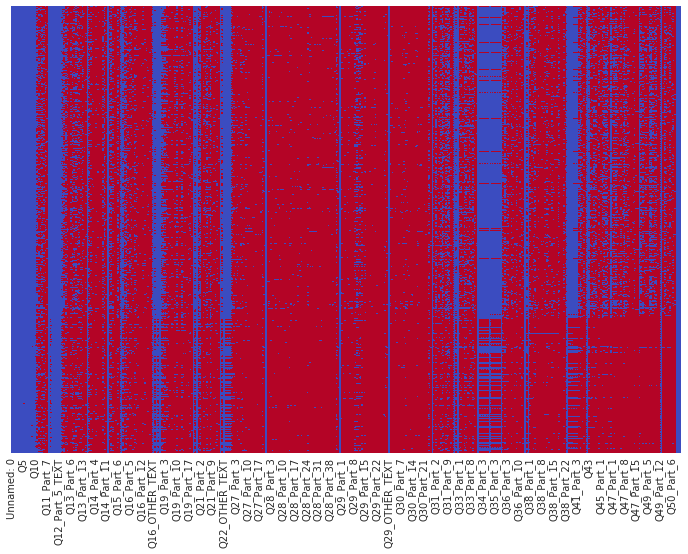

In [298]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(data.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

As we can clearly observe, a substantial number of data points contain missing information. Simply dropping all the NaNs would get rid of too much valuable information. 

In order to properly clean the dataset, different features will be treated in accordance to their type and the information they contain, namely,

* Features that contain a selection of different options that can not be numbered in terms of maginitude will be converted to dummies, where each category becomes a new feature

* Features that are based on opinion about something (i.e. no / maybe not/ maybe/ probably/yes), will be converted to numbers (i.e. from 0 for 'no' to 4 for 'yes')

* Features that contain float or ranges may be converted to or maintained as floats


Let's see if there are any duplicates in the dataset, and remove them accordingly using the code from Indeed_web_scraper_v13.ipynb

In [299]:
# get the list of all columns:
cols_for_duplicate_check = data.columns
# get a boolean series that marks all rows that have duplicates (including first instances) as True
mask = data.duplicated(keep=False, subset=cols_for_duplicate_check)
# use the boolean mask to subset the DataFrame, sort results by 'job_title' and 'company_name'
data[mask].sort_values(by=['Time from Start to Finish (seconds)', 'Q4', 'Q9'])

Empty DataFrame
Columns: [Unnamed: 0, Time from Start to Finish (seconds), Q1, Q1_OTHER_TEXT, Q2, Q3, Q4, Q5, Q6, Q6_OTHER_TEXT, Q7, Q7_OTHER_TEXT, Q8, Q9, Q10, Q11_Part_1, Q11_Part_2, Q11_Part_3, Q11_Part_4, Q11_Part_5, Q11_Part_6, Q11_Part_7, Q11_OTHER_TEXT, Q12_MULTIPLE_CHOICE, Q12_Part_1_TEXT, Q12_Part_2_TEXT, Q12_Part_3_TEXT, Q12_Part_4_TEXT, Q12_Part_5_TEXT, Q12_OTHER_TEXT, Q13_Part_1, Q13_Part_2, Q13_Part_3, Q13_Part_4, Q13_Part_5, Q13_Part_6, Q13_Part_7, Q13_Part_8, Q13_Part_9, Q13_Part_10, Q13_Part_11, Q13_Part_12, Q13_Part_13, Q13_Part_14, Q13_Part_15, Q13_OTHER_TEXT, Q14_Part_1, Q14_Part_2, Q14_Part_3, Q14_Part_4, Q14_Part_5, Q14_Part_6, Q14_Part_7, Q14_Part_8, Q14_Part_9, Q14_Part_10, Q14_Part_11, Q14_OTHER_TEXT, Q15_Part_1, Q15_Part_2, Q15_Part_3, Q15_Part_4, Q15_Part_5, Q15_Part_6, Q15_Part_7, Q15_OTHER_TEXT, Q16_Part_1, Q16_Part_2, Q16_Part_3, Q16_Part_4, Q16_Part_5, Q16_Part_6, Q16_Part_7, Q16_Part_8, Q16_Part_9, Q16_Part_10, Q16_Part_11, Q16_Part_12, Q16_Part_13, Q16_Part_14, Q16_Part_15, Q16_Part_16, Q16_Part_17, Q16_Part_18, Q16_OTHER_TEXT, Q17, Q17_OTHER_TEXT, Q18, Q18_OTHER_TEXT, Q19_Part_1, Q19_Part_2, Q19_Part_3, Q19_Part_4, Q19_Part_5, Q19_Part_6, Q19_Part_7, Q19_Part_8, Q19_Part_9, Q19_Part_10, Q19_Part_11, ...]
Index: []

[0 rows x 398 columns]

No duplicates have been found. Now, let's look at the features where the respondent can choose only one options among many to see which ones have missing data (NaN's):

In [300]:
#check if any of the basic identifier features have NaN's
print('gender data (Q1) has {} NaNs'.format(data.iloc[:,2].isnull().sum()))
print('age data (Q2) has {} NaNs'.format(data.iloc[:,4].isnull().sum()))
print('country data (Q3) has {} NaNs'.format(data.iloc[:,5].isnull().sum()))
print('degree data (Q4) has {} NaNs'.format(data.iloc[:,6].isnull().sum()))
print('major data (Q5) has {} NaNs'.format(data.iloc[:,7].isnull().sum()))
print('title data (Q6) has {} NaNs'.format(data.iloc[:,8].isnull().sum()))
print('title-other (Q6_OTHER_TEXT) data has {} NaNs'.format(data.iloc[:,9].isnull().sum()))
print('industry data (Q7) has {} NaNs'.format(data.iloc[:,10].isnull().sum()))
print('industry-other (Q7_OTHER_TEXT) data has {} NaNs'.format(data.iloc[:,11].isnull().sum()))
print('experience (Q8) data has {} NaNs'.format(data.iloc[:,12].isnull().sum()))
print('salary data (Q9) has {} NaNs'.format(data.iloc[:,13].isnull().sum()))
print('ML-incorporate (Q10) data has {} NaNs'.format(data.iloc[:,14].isnull().sum()))
print('primary tools (Q12_MULTIPLE_CHOICE) data has {} NaNs'.format(data.iloc[:,23].isnull().sum()))
print('programming language (Q17) data has {} NaNs'.format(data.iloc[:,85].isnull().sum()))
print('ML library (Q20) data has {} NaNs'.format(data.iloc[:,109].isnull().sum()))
print('coding time (Q23) percent data has {} NaNs'.format(data.iloc[:,127].isnull().sum()))
print('how long coding (Q24) years data has {} NaNs'.format(data.iloc[:,128].isnull().sum()))
print('ML_years (Q25) data has {} NaNs'.format(data.iloc[:,129].isnull().sum()))
print('data_scientist (Q26) data has {} NaNs'.format(data.iloc[:,130].isnull().sum()))
print('online_platform (Q37) data has {} NaNs'.format(data.iloc[:,306].isnull().sum()))
print('q_online_platform (Q39_Part_1) data has {} NaNs'.format(data.iloc[:,331].isnull().sum()))
print('q_in_person_bootcamp (Q39_Part_2) has {} NaNs'.format(data.iloc[:,332].isnull().sum()))
print('data_science_expertise (Q40) has {} NaNs'.format(data.iloc[:,333].isnull().sum()))
print('fairness_bias (Q41_Part_1) data has {} NaNs'.format(data.iloc[:,334].isnull().sum()))
print('explain_ML (Q41_Part_2) data has has {} NaNs'.format(data.iloc[:,335].isnull().sum()))
print('reproducibility (Q41_Part_3) data has {} NaNs'.format(data.iloc[:,336].isnull().sum()))
print('percent_unfair_bias (Q43) data has {} NaNs'.format(data.iloc[:,343].isnull().sum()))
print('percent_model_insights (Q46) data has {} NaNs'.format(data.iloc[:,356].isnull().sum()))
print('black_boxes (Q48) data has {} NaNs'.format(data.iloc[:,373].isnull().sum()))

gender data (Q1) has 0 NaNs
age data (Q2) has 0 NaNs
country data (Q3) has 0 NaNs
degree data (Q4) has 0 NaNs
major data (Q5) has 135 NaNs
title data (Q6) has 0 NaNs
title-other (Q6_OTHER_TEXT) data has 0 NaNs
industry data (Q7) has 0 NaNs
industry-other (Q7_OTHER_TEXT) data has 0 NaNs
experience (Q8) data has 76 NaNs
salary data (Q9) has 0 NaNs
ML-incorporate (Q10) data has 292 NaNs
primary tools (Q12_MULTIPLE_CHOICE) data has 1572 NaNs
programming language (Q17) data has 4341 NaNs
ML library (Q20) data has 5769 NaNs
coding time (Q23) percent data has 1968 NaNs
how long coding (Q24) years data has 1988 NaNs
ML_years (Q25) data has 2014 NaNs
data_scientist (Q26) data has 2023 NaNs
online_platform (Q37) data has 8140 NaNs
q_online_platform (Q39_Part_1) data has 3699 NaNs
q_in_person_bootcamp (Q39_Part_2) has 3699 NaNs
data_science_expertise (Q40) has 3763 NaNs
fairness_bias (Q41_Part_1) data has 4352 NaNs
explain_ML (Q41_Part_2) data has has 4352 NaNs
reproducibility (Q41_Part_3) data h

We can observe that some of the features correspond to basic biographic information (gender, country, degree), whereas others refer more to hard and soft skills (programming language, online platforms used, understanding about ML algorithms, among others). Skill-based features have a high number of missing values (almost 1/3 of data points is missing in some cases), and bio-based features are almost complete with very few missing points.

Given the fact that some of the features have a high number of missing points, simply removing these points (rows) could lead to a substantial reduction in the number of data points, and a consequent loss of valuable information. At this stage, only bio-features are used for removing missing points:  

In [301]:
print(len(data))
data=data.dropna(subset=['Q5', 'Q8'])

print(len(data))

15429
15219


### 2.1. Bio-Based Features

One way to visualize categorical features requires changing them into numerical features, which is shown as follows:

In [302]:
# sort all data based on salary (from smallest to largest salaries)
data=data.sort_values('Q9', ascending=True)
num_data=pd.DataFrame(data.iloc[:,-1])
num_d=pd.DataFrame(num_data)
num_d['gender'] = pd.factorize(data.iloc[:,2])[0] + 1
num_d['country'] = pd.factorize(data.iloc[:,5])[0] + 1
num_d['degree'] = pd.factorize(data.iloc[:,6])[0] + 1
num_d['major'] = pd.factorize(data.iloc[:,7])[0] + 1
num_d['title'] = pd.factorize(data.iloc[:,8])[0] + 1
num_d['industry'] = pd.factorize(data.iloc[:,10])[0] + 1
num_d['role_experience'] = pd.factorize(data.iloc[:,12])[0] + 1
num_d['salary']=data['Q9']

Let's look at those variables which can be converted to numbers easily:

In [303]:
l=data.iloc[:,12].value_counts().index
l

Index(['0-1', '1-2', '2-3', '5-10', '3-4', '4-5', '10-15', '15-20', '20-25',
       '30 +', '25-30'],
      dtype='object')

In [304]:
num_d['role_experience'] = data.iloc[:,12].replace([l[0], l[1], l[2], l[3], l[4], l[5], l[6],
                                                   l[7],l[8],l[9],l[10]], [0.5, 1.5, 2.5, 7.5, 3.5, 4.5,
                                                                          12.5, 17.5, 22.5, 35, 27.5])
num_d['role_experience'].fillna(round(num_d['role_experience'].mean(),1), inplace=True)

In order to visualize how features correlates, some functions that plot boxplots and lines plots are defined as follows:

In [305]:
def plot_box_sal(sal_data, groupby_data):
    #plt.figure(figsize=(15,10))
    pd_data=pd.concat([sal_data.copy(), groupby_data.copy()], axis=1)
    pd_data=pd_data.sort_values(str(groupby_data.name), ascending=True)
    m=(pd_data.iloc[:,0].groupby(pd_data.iloc[:,1]))
    m=m.apply(pd.DataFrame)
    m=(m-sal_data.mean()).div(sal_data.std())
    m_median=m.median()
    m_mean=m.mean()
    m_std=m.std()
    y_pos=pd_data.iloc[:,1].unique()
    plt.plot(y_pos,m.median())
    plt.fill_between(y_pos,m_mean - 2*m_std,m_mean + 2*m_std, alpha=0.1, color="b")
    plt.ylabel('Normalized salary distribution',size=14)
    #plt.xlabel('Mean number of years of ML experience',y=1.1,size=14)
#plt.yscale('log')

def plot_cat_trends(sal_data, groupby_data):
    #plt.figure(figsize=(15,10))
    pd_data=pd.concat([sal_data.copy(), groupby_data.copy()], axis=1)
    pd_data=pd_data.sort_values(str(groupby_data.name), ascending=True)
    m=(pd_data.iloc[:,0].groupby(pd_data.iloc[:,1]))
    m=m.apply(pd.DataFrame)
    m=(m-sal_data.mean()).div(sal_data.std())
    m_mean=m.mean()
    m_std=m.std()
    y_pos=np.arange(len(pd_data.iloc[:,1].unique())-1)
    print(len(m.mean()))
    print(len(y_pos))
    plt.plot(y_pos,m.mean())
    plt.fill_between(y_pos,m_mean - 2*m_std,m_mean + 2*m_std, alpha=0.1, color="b")
    plt.ylabel('Normalized salary distribution',size=14)
    #plt.xlabel('Mean number of years of ML experience',y=1.1,size=14)
#plt.yscale('log')

def plot_boxplot(sal_data, groupby_data):
    #plt.figure(figsize=(15,10))
    pd_data=pd.concat([sal_data.copy(), groupby_data.copy()], axis=1)
    pd_data=pd_data.sort_values(str(groupby_data.name), ascending=True)
    m=(pd_data.iloc[:,0].groupby(pd_data.iloc[:,1]))
    m=m.apply(pd.DataFrame)
    m=(m-sal_data.mean()).div(sal_data.std())
    m_mean=m.mean()
    m_std=m.std()
    y_pos=np.arange(len(pd_data.iloc[:,1].unique())-1)
    m.boxplot()
    plt.ylabel('Normalized salary distribution',size=14)

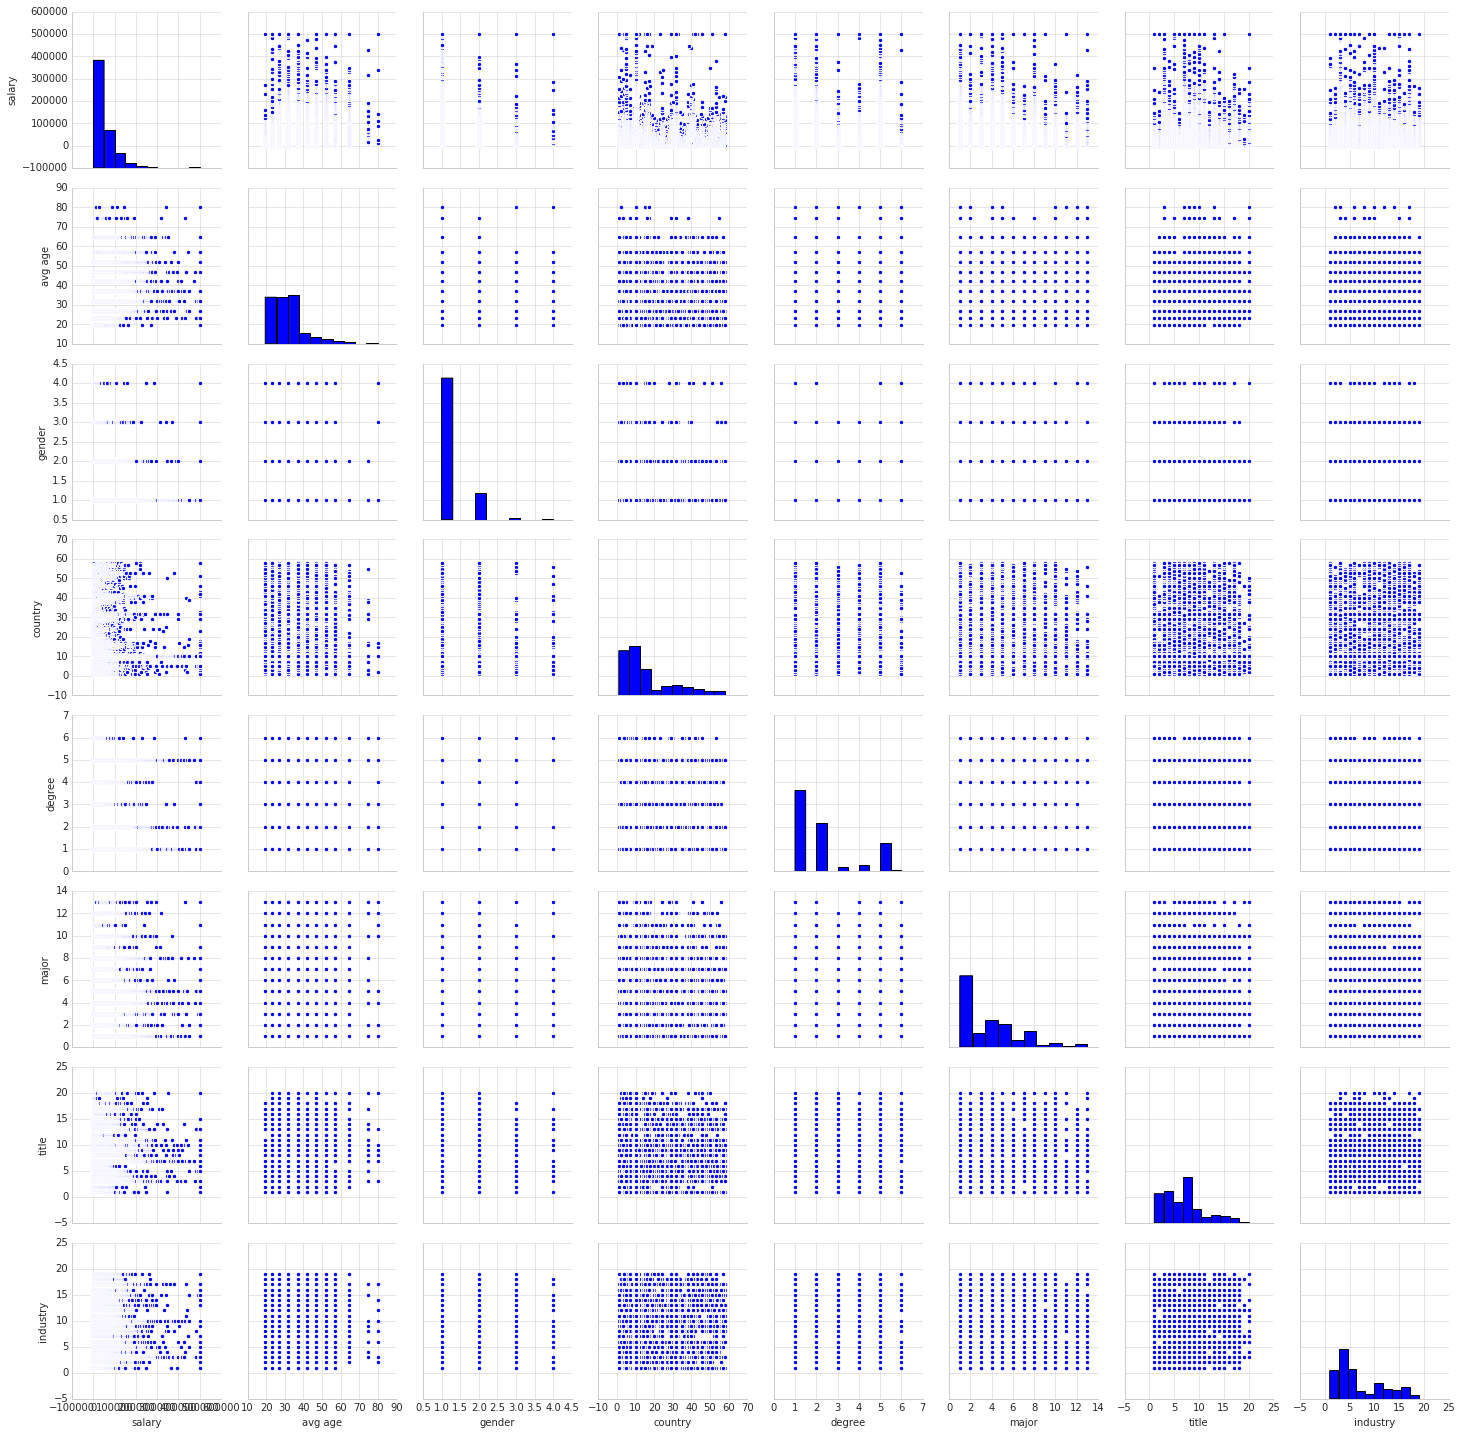

In [306]:
sns.pairplot(pd.concat([num_d['salary'], num_d.iloc[:,:7]],axis=1),palette='rainbow')
plt.show()

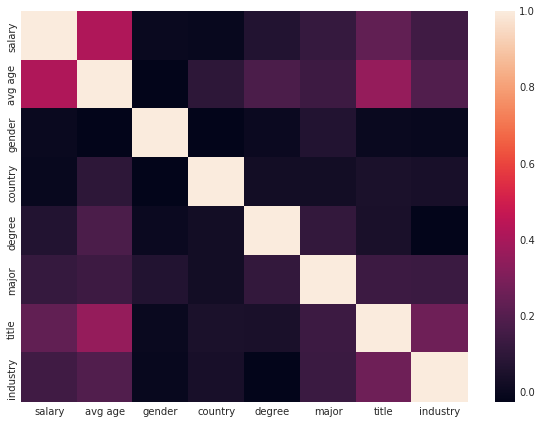

In [307]:
plt.figure(figsize=(10,7))
corr = pd.concat([num_d['salary'], num_d.iloc[:,:7]],axis=1).corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

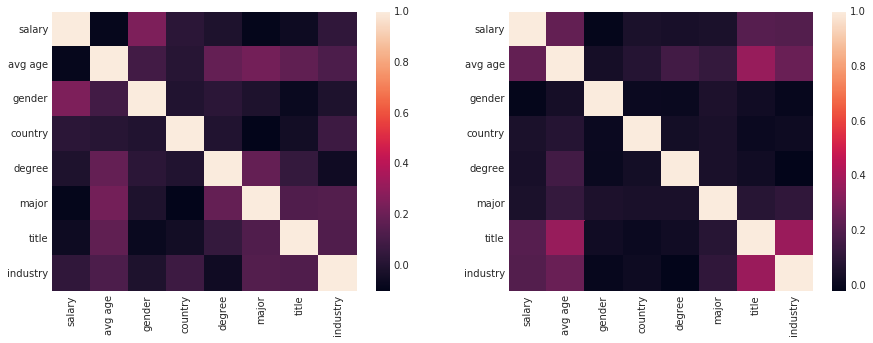

In [308]:
plt.figure(figsize=(15,5))
hs=200000
corr = pd.concat([(num_d['salary'])[num_d['salary']>hs], (num_d.iloc[:,:7])[num_d['salary']>hs]],axis=1).corr()
plt.subplot(1,2,1)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

ls=20000
corr = pd.concat([(num_d['salary'])[num_d['salary']<ls], (num_d.iloc[:,:7])[num_d['salary']<ls]],axis=1).corr()
plt.subplot(1,2,2)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

At high salaries (left plot), salaries correlates more strongly with gender, followed by industry. At low salaries (right plot), salaries correlates more strongly with job title, industry and average age of worker. Overall, this implies that the age tends to be a factor most in the determination of who have the lower salaries, but may not play a significant role in determining the salaries of those earning very high. This may be in part due to the fact that given the relative level of recent innovation in the data scientist field, many of the more high earning positions which demand high levels of expertise and responsility are not necessarily filled by older people, as there probably aren't that many.


Looking at correlation between salary to 

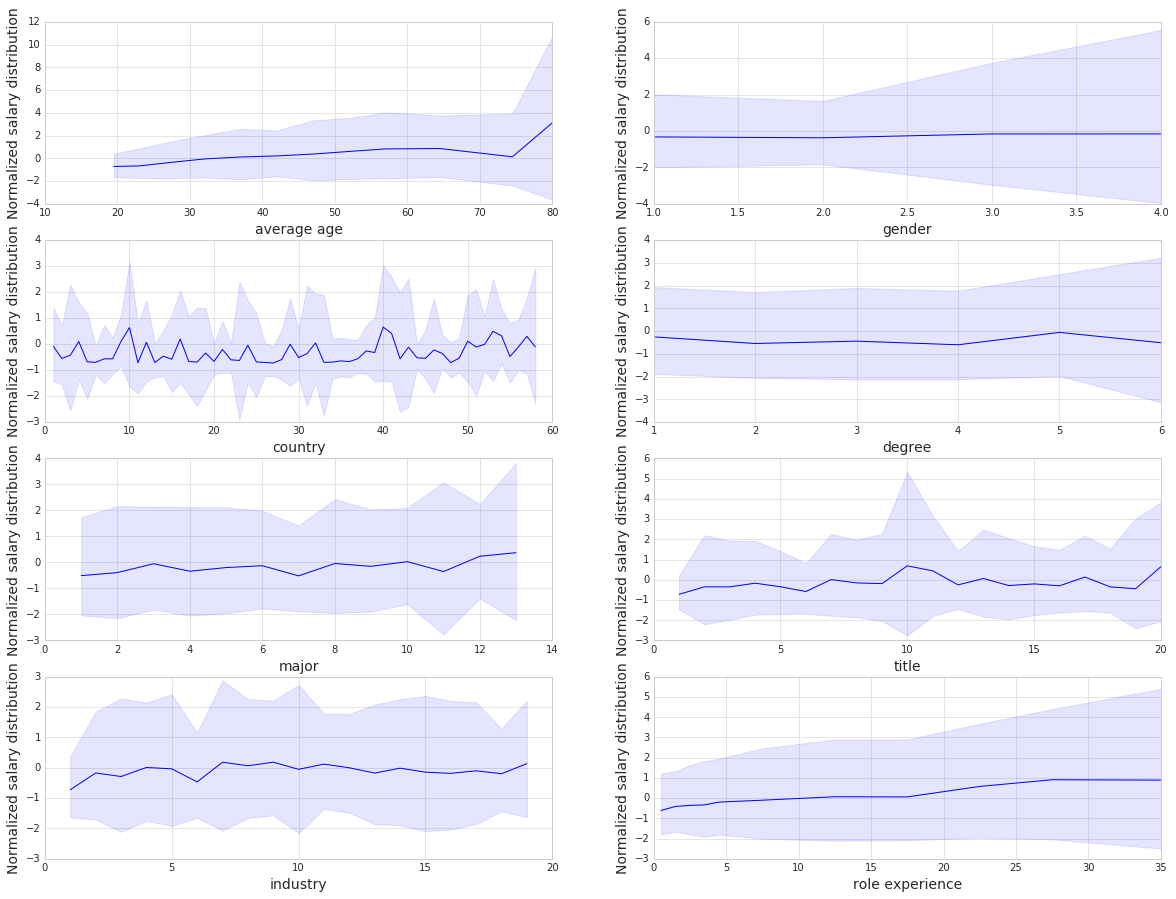

In [309]:
plt.figure(figsize=(20,15))
plt.subplot(4,2,1)
plot_box_sal(num_d['salary'], num_d.iloc[:,0])
plt.xlabel('average age',y=1.1,size=14)
plt.subplot(4,2,2)
plot_box_sal(num_d['salary'], num_d.iloc[:,1])
plt.xlabel('gender',y=1.1,size=14)
plt.subplot(4,2,3)
plot_box_sal(num_d['salary'], num_d.iloc[:,2])
plt.xlabel('country',y=1.1,size=14)
plt.subplot(4,2,4)
plot_box_sal(num_d['salary'], num_d.iloc[:,3])
plt.xlabel('degree',y=1.1,size=14)
plt.subplot(4,2,5)
plot_box_sal(num_d['salary'], num_d.iloc[:,4])
plt.xlabel('major',y=1.1,size=14)
plt.subplot(4,2,6)
plot_box_sal(num_d['salary'], num_d.iloc[:,5])
plt.xlabel('title',y=1.1,size=14)
plt.subplot(4,2,7)
plot_box_sal(num_d['salary'], num_d.iloc[:,6])
plt.xlabel('industry',y=1.1,size=14)
plt.subplot(4,2,8)
plot_box_sal(num_d['salary'], num_d.iloc[:,7])
plt.xlabel('role experience',y=1.1,size=14)

We can observe substantial variation of the median salaries for different countries, age, and industry. In addition, we see that degree and gender do not appear to affect median salaries considerably, although the 95% percent intervals do change. This implies reinforces the idea of outliers in salary can be affected by variables that do not necessarily impact the median.

### 2.2. Skill-Based Features

Let's look at categorical values that can be easily converted to numerical values:

In [310]:
l=data.iloc[:,14].value_counts().index
l
#num_d['ML_incorporation']


Index(['We are exploring ML methods (and may one day put a model into production)',
       'No (we do not use ML methods)',
       'We recently started using ML methods (i.e., models in production for less than 2 years)',
       'We have well established ML methods (i.e., models in production for more than 2 years)',
       'We use ML methods for generating insights (but do not put working models into production)',
       'I do not know'],
      dtype='object')

In [311]:
num_d['ML_incorporation'] = data.iloc[:,14].replace([l[0], l[1], l[2], l[3], l[4], l[5]], [1, 0, 2, 4, 3, 0])
num_d['ML_incorporation'].fillna(0.0, inplace=True)

In [312]:
l=data.iloc[:,127].value_counts().index
l

Index(['50% to 74% of my time', '25% to 49% of my time',
       '1% to 25% of my time', '75% to 99% of my time', '0% of my time',
       '100% of my time'],
      dtype='object')

Replace missing values in coding time by the average coding time of the other points

In [313]:
num_d['coding_time']=data.iloc[:,127].replace([l[0], l[1], l[2], l[3], l[4], l[5]], [62, 37, 13, 87, 0, 100])
num_d['coding_time'].fillna(round(num_d['coding_time'].mean(),1), inplace=True)

In [314]:
l=data.iloc[:,128].value_counts().index
l

Index(['1-2 years', '3-5 years', '< 1 year', '5-10 years', '10-20 years',
       'I have never written code but I want to learn', '20-30 years',
       '30-40 years', '40+ years',
       'I have never written code and I do not want to learn'],
      dtype='object')

In [315]:
num_d['years_coding']=data.iloc[:,128].replace([l[0], l[1], l[2], l[3], l[4], 
                                                l[5], l[6], l[7], l[8], l[9]], [1.5, 4, 0.5, 7.5, 15, 0, 25,
                                                35, 50,0])
num_d['years_coding'].fillna(round(num_d['years_coding'].mean(),1), inplace=True)

In [316]:
l=data.iloc[:,129].value_counts().index
print(l)
print(len(l))

Index(['< 1 year', '1-2 years', '2-3 years',
       'I have never studied machine learning but plan to learn in the future',
       '3-4 years', '5-10 years', '4-5 years', '10-15 years', '20+ years',
       'I have never studied machine learning and I do not plan to'],
      dtype='object')
10


In [317]:
num_d['ML_years']=data.iloc[:,129].replace([l[0], l[1], l[2], l[3], l[4], 
                                                l[5], l[6], l[7], l[8], l[9]], [0.5, 1.5, 2.5, 0,3.5,7.5,4.5,
                                                12.5, 30,0])
num_d['ML_years'].fillna(round(num_d['ML_years'].mean(),1), inplace=True)

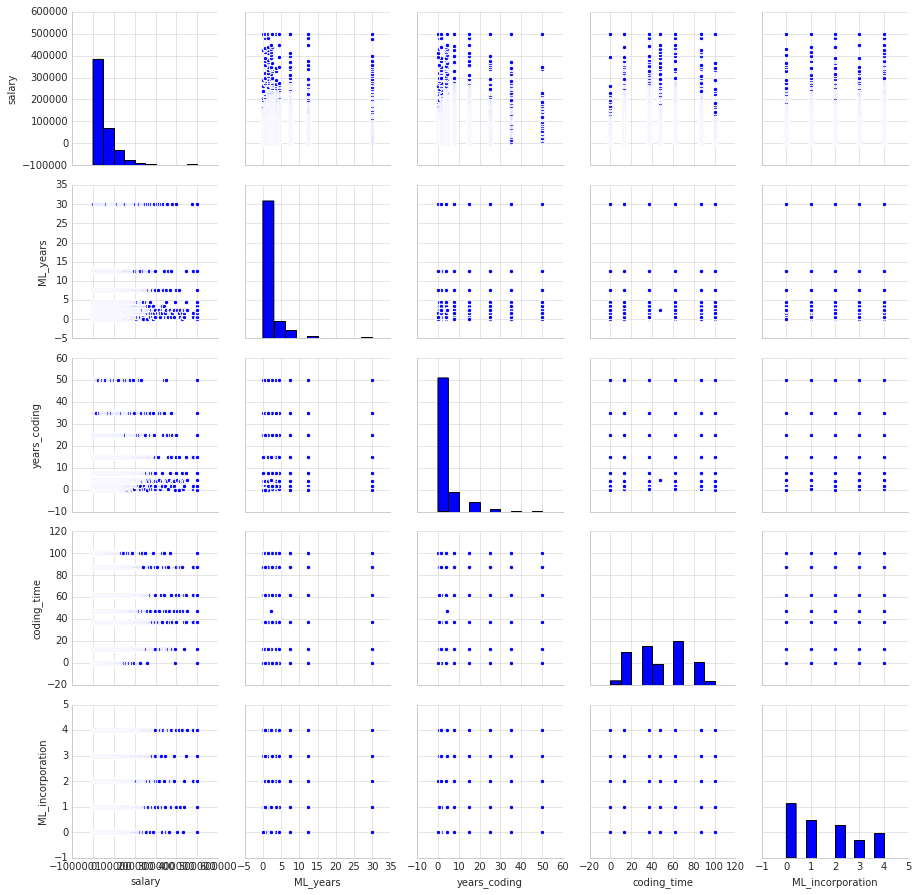

In [318]:
sns.pairplot(pd.concat([num_d['salary'], num_d['ML_years'], num_d['years_coding'], 
                        num_d['coding_time'], num_d['ML_incorporation']],axis=1),palette='rainbow')


Let's look at the features which are already numerical:

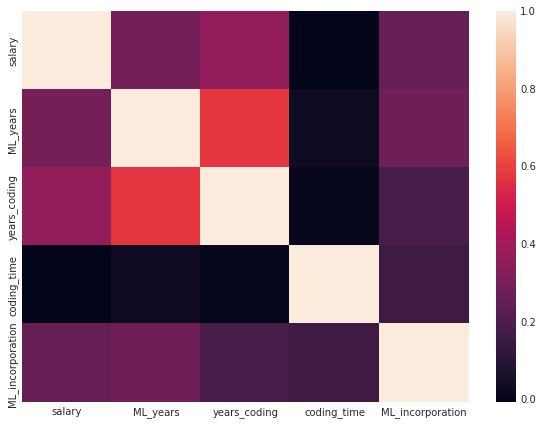

In [319]:
plt.figure(figsize=(10,7))
data_skill_features=pd.concat([num_d['salary'], num_d['ML_years'], num_d['years_coding'], 
                        num_d['coding_time'], num_d['ML_incorporation']],axis=1)
corr = data_skill_features.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

We can observe that salaries tend to correlate more with features such as number of years coding, and to some extent to the number of years of ML experience and level of ML incorporation in the workplace.

We can observe that the percent of time coding during work appears to play almost no significance in determining one's salary overall. Let's look at how the skills feature and salary data cluster:

In [320]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_skill_features)
y_kmeans = kmeans.predict(data_skill_features)

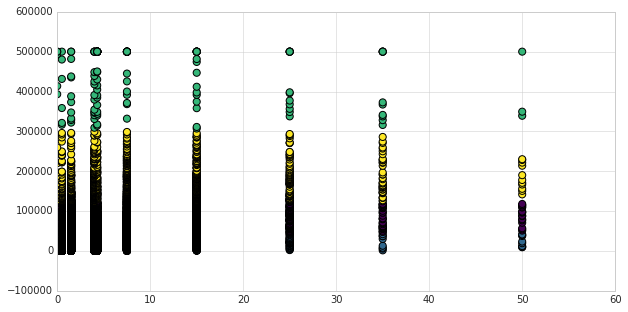

In [321]:
plt.scatter(data_skill_features['years_coding'], data_skill_features['salary'], c=y_kmeans, s=50, cmap='viridis')
plt.xlim([0, 60])
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

We can observe that kmeans clustering shows that data tends to cluster in terms of ranges of salaries, especially from 0 to ~200,000, from 200,000 to 300,000, and from 300,000 to 500,000. Let's evaluate the correlation of these features for specific ranges of salaries

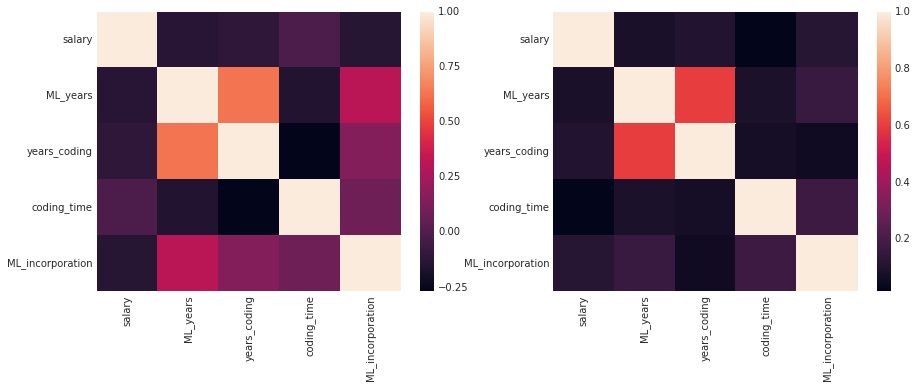

In [322]:
plt.figure(figsize=(15,5))
hs=300000
corr = pd.concat([(num_d['salary'])[num_d['salary']>hs], (num_d['ML_years'])[num_d['salary']>hs], 
                  (num_d['years_coding'])[num_d['salary']>hs], (num_d['coding_time'])[num_d['salary']>hs], 
                  (num_d['ML_incorporation'])[num_d['salary']>hs]],axis=1).corr()
plt.subplot(1,2,1)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

ls=20000
corr = pd.concat([(num_d['salary'])[num_d['salary']<ls], (num_d['ML_years'])[num_d['salary']<ls], 
                  (num_d['years_coding'])[num_d['salary']<ls], (num_d['coding_time'])[num_d['salary']<ls], 
                  (num_d['ML_incorporation'])[num_d['salary']<ls]],axis=1).corr()
plt.subplot(1,2,2)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)


We can observe that in the case of high salaries, the coding time of each participants appears to have the largest (although very low overall) with respect to salaries. This does not hold true for low salaries.

We can also evaluate the median salaries within a 95% confidence interval for each of these numerical features

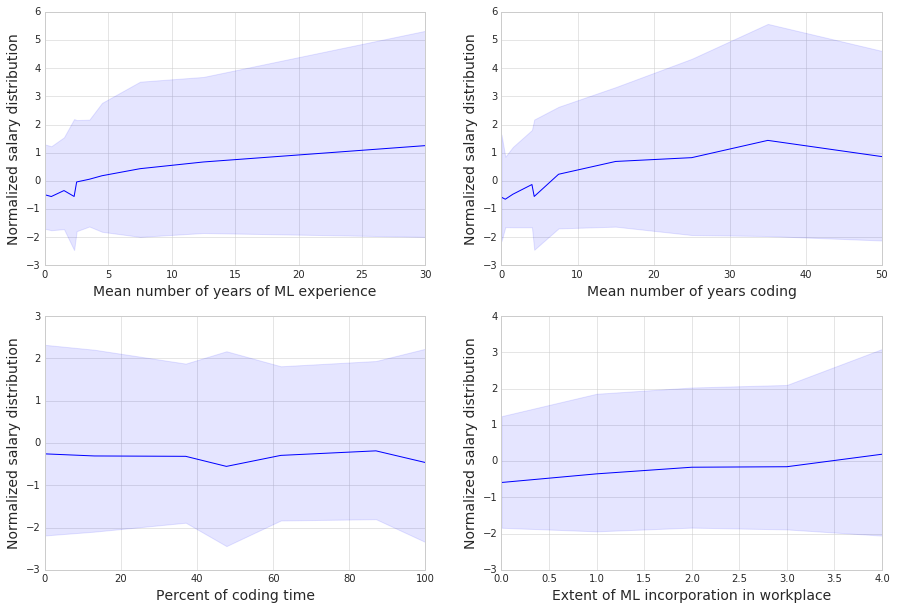

In [323]:
#sns.pairplot(pd.concat([num_d['salary'], num_d['ML_years'], num_d['years_coding'], 
#                        num_d['coding_time'], num_d['ML_incorporation']],axis=1),palette='rainbow')
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_box_sal(data['Q9'], num_d['ML_years'])
plt.xlabel('Mean number of years of ML experience',y=1.1,size=14)
#plt.yscale('log')

plt.subplot(2,2,2)
plot_box_sal(data['Q9'], num_d['years_coding'])
plt.xlabel('Mean number of years coding',y=1.1,size=14)

plt.subplot(2,2,3)
plot_box_sal(data['Q9'], num_d['coding_time'])
plt.xlabel('Percent of coding time',y=1.1,size=14)

plt.subplot(2,2,4)
plot_box_sal(data['Q9'], num_d['ML_incorporation'])
plt.xlabel('Extent of ML incorporation in workplace',y=1.1,size=14)
plt.show()

Percent of coding time: coding does not appear to play a major role at dictating salary, although those whose central job role is coding (100% coding time) have a salary that is slightly smaller than those who spend less time coding.

ML incorporation by an employer appears to be related to a small increase in median income

Number of years coding and on ML appears to be related to higher salaries to some extent

Let's evaluate the relationship between role at work with the different job roles undertaken by professionals in data science:

In [324]:
dummies_role_at_work = pd.get_dummies(data.iloc[:,15:22], prefix='role_at_work')
dummies_role_at_work.rename(columns={ dummies_role_at_work.columns[0]: "Analytics for product & product decision" }, inplace=True)
dummies_role_at_work.rename(columns={ dummies_role_at_work.columns[1]: "ML for improving product+workflow" },inplace=True)
dummies_role_at_work.rename(columns={ dummies_role_at_work.columns[2]: "Build data infrastructure for storing and analytics" },inplace=True)
dummies_role_at_work.rename(columns={ dummies_role_at_work.columns[3]: "Prototype building for ML in new areas" },inplace=True)
dummies_role_at_work.rename(columns={ dummies_role_at_work.columns[4]: "Research advancing ML" },inplace=True)
dummies_role_at_work.rename(columns={ dummies_role_at_work.columns[5]: "None of the described activities" },inplace=True)
dummies_role_at_work.rename(columns={ dummies_role_at_work.columns[6]: "Other" },inplace=True)


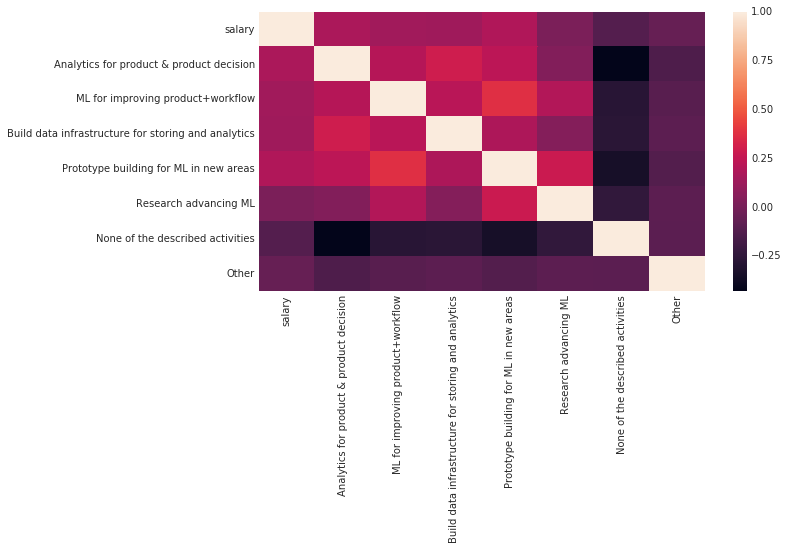

In [325]:
data_salary_and_roles=pd.concat([num_d['salary'], dummies_role_at_work],axis=1).corr()
sns.heatmap(data_salary_and_roles, xticklabels=data_salary_and_roles.columns, 
            yticklabels=data_salary_and_roles.columns)

As we can observe in the above correlation plot, features such as analytics for product and product decision,ML for improving products and workflow, building data infrastrucutre for businesses, and prototype building for ML in new areas have an observable degree of correlation with salary.

Let's evaluate how salaries tend to distribute as a function of tools and online platforms used by data scientists and analysts

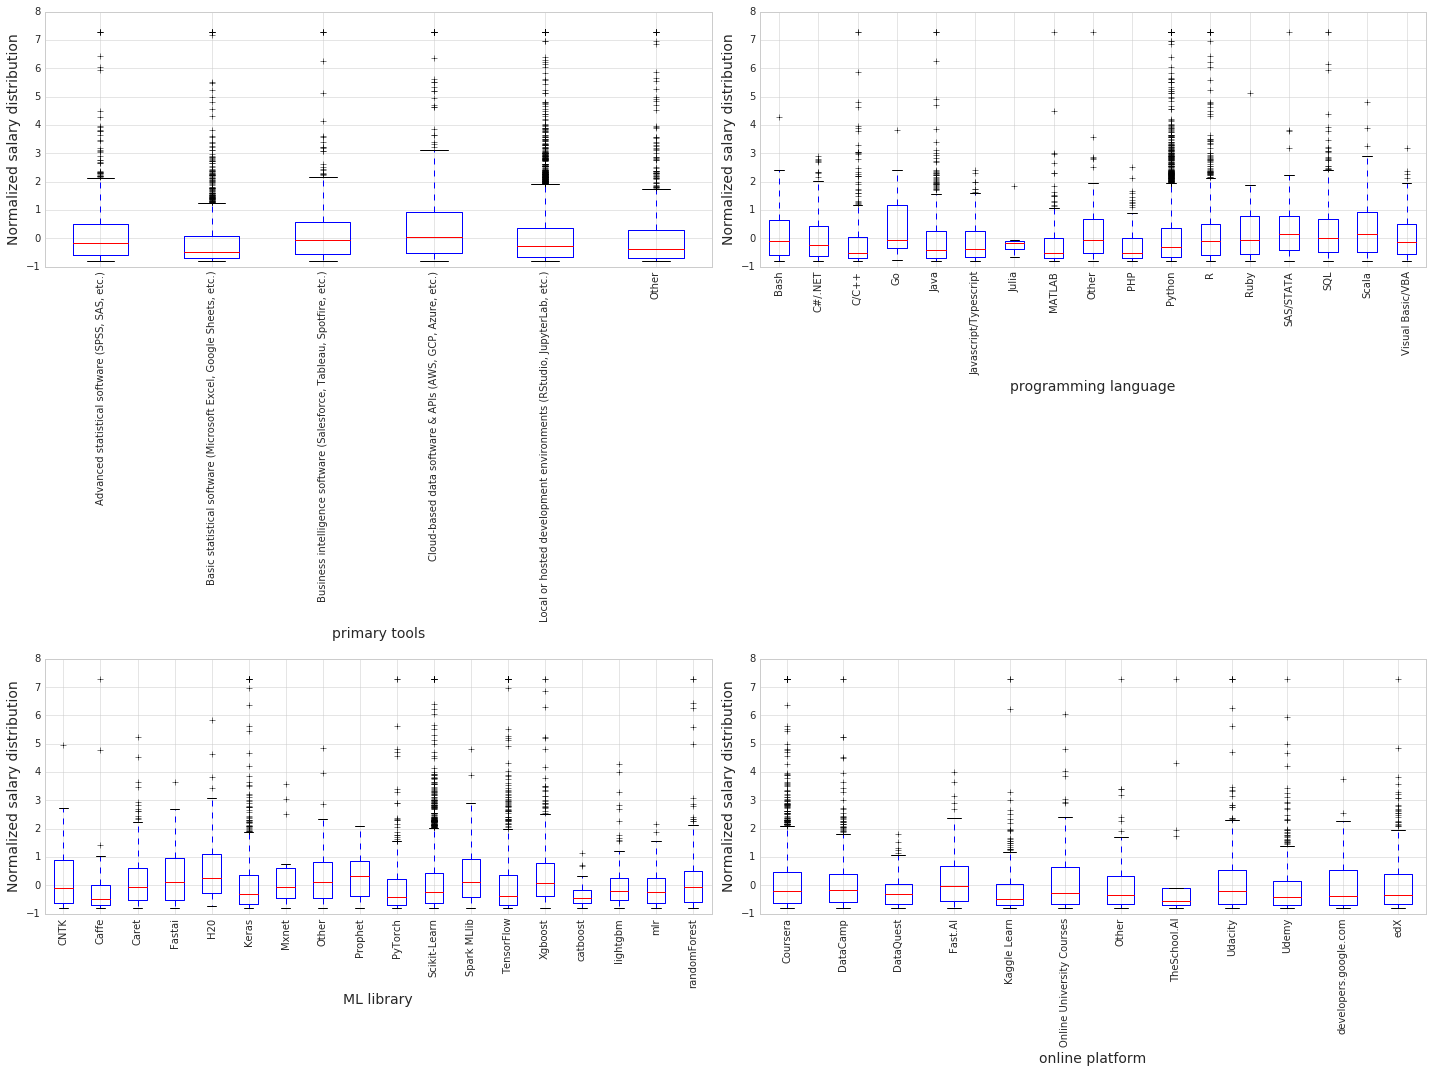

In [326]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plot_boxplot(num_d['salary'], data.iloc[:,23])
plt.xlabel('primary tools',y=1.1,size=14)
plt.xticks(rotation=90)
plt.subplot(2,2,2)
plot_boxplot(num_d['salary'], data.iloc[:,85])
plt.xlabel('programming language',y=1.1,size=14)
plt.xticks(rotation=90)
plt.subplot(2,2,3)
plot_boxplot(num_d['salary'], data.iloc[:,109])
plt.xlabel('ML library',y=1.1,size=14)
plt.xticks(rotation=90)
plt.subplot(2,2,4)
plot_boxplot(num_d['salary'], data.iloc[:,306])
plt.xlabel('online platform',y=1.1,size=14)
plt.xticks(rotation=90)
plt.tight_layout()

num_d['primary_tools'] = pd.factorize(data.iloc[:,23])[0] + 1
num_d['programming_language'] = pd.factorize(data.iloc[:,85])[0] + 1
num_d['ML_library'] = pd.factorize(data.iloc[:,109])[0] + 1
num_d['online_platform'] = pd.factorize(data.iloc[:,306])[0] + 1

We can also observe the correlation of different machine learning tools and computing languages

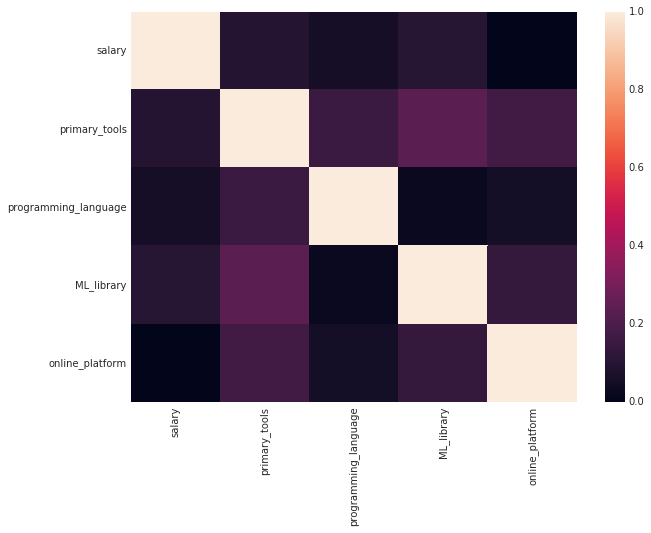

In [327]:
plt.figure(figsize=(10,7))
data_tools_features=pd.concat([num_d['salary'], num_d['primary_tools'], num_d['programming_language'], 
                        num_d['ML_library'], num_d['online_platform']],axis=1)
data_tools_features_actual=pd.concat([data['Q9'],data.iloc[:,23],data.iloc[:,85],data.iloc[:,109],data.iloc[:,306]],axis=1)
corr = data_tools_features.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

The correlation of salary with features are overall very low, but does appear to be slightly high for primary tools and ML libraries.

Let's evaluate the categorical features that could be converted into a sequence of numbers. 

In [328]:
l=data.iloc[:,130].value_counts().index
print(l)
print(len(l))

Index(['Probably yes', 'Definitely yes', 'Maybe', 'Probably not',
       'Definitely not'],
      dtype='object')
5


In [329]:
num_d['data_scientist']=data.iloc[:,130].replace([l[0], l[1], l[2], l[3], l[4]], [3, 4, 2, 1,0])
num_d['data_scientist'].fillna(num_d['data_scientist'].mean(), inplace=True)

In [330]:
l=data.iloc[:,306].value_counts().index
print(l)
print(len(l))


Index(['Coursera', 'DataCamp', 'Udemy', 'Udacity', 'edX', 'Kaggle Learn',
       'Online University Courses', 'Other', 'Fast.AI',
       'developers.google.com', 'DataQuest', 'TheSchool.AI'],
      dtype='object')
12


In [331]:
l=data.iloc[:,331].value_counts().index
print(l)
print(len(l))

Index(['Slightly better', 'Much better', 'Neither better nor worse',
       'Slightly worse', 'No opinion; I do not know', 'Much worse'],
      dtype='object')
6


In [332]:
num_d['q_online_platform']=data.iloc[:,331].replace([l[0], l[1], l[2], l[3],l[4], l[5]], [3,4,2,1,0,0])
num_d['q_online_platform'].fillna(num_d['q_online_platform'].mean(), inplace=True)


In [333]:
l=data.iloc[:,332].value_counts().index
print(l)
print(len(l))

Index(['No opinion; I do not know', 'Slightly better',
       'Neither better nor worse', 'Much better', 'Slightly worse',
       'Much worse'],
      dtype='object')
6


In [334]:
num_d['q_in_person_bootcamp']=data.iloc[:,332].replace([l[0], l[1], l[2], l[3],l[4], l[5]], [0,3,2,4,1,0])
num_d['q_in_person_bootcamp'].fillna(num_d['q_in_person_bootcamp'].mean(), inplace=True)

In [335]:
l=data.iloc[:,333].value_counts().index
print(l)
print(len(l))

Index(['Independent projects are much more important than academic achievements',
       'Independent projects are slightly more important than academic achievements',
       'Independent projects are equally important as academic achievements',
       'Independent projects are slightly less important than academic achievements',
       'No opinion; I do not know',
       'Independent projects are much less important than academic achievements'],
      dtype='object')
6


In [336]:
num_d['data_science_expertise']=data.iloc[:,333].replace([l[0], l[1], l[2], l[3],l[4], l[5]], [4,3,2,1,0,0])
num_d['data_science_expertise'].fillna(num_d['data_science_expertise'].mean(), inplace=True)

In [337]:
l=data.iloc[:,334].value_counts().index
print(l)
print(len(l))

Index(['Very important', 'Slightly important', 'No opinion; I do not know',
       'Not at all important'],
      dtype='object')
4


In [338]:
num_d['fairness_bias']=data.iloc[:,334].replace([l[0], l[1], l[2], l[3]], [2,1,0,0])
num_d['fairness_bias'].fillna(num_d['fairness_bias'].mean(), inplace=True)

In [339]:
l=data.iloc[:,335].value_counts().index
print(l)
print(len(l))

Index(['Very important', 'Slightly important', 'No opinion; I do not know',
       'Not at all important'],
      dtype='object')
4


In [340]:
num_d['explain_ML']=data.iloc[:,334].replace([l[0], l[1], l[2], l[3]], [2,1,0,0])
num_d['explain_ML'].fillna(num_d['fairness_bias'].mean(), inplace=True)

In [341]:
l=data.iloc[:,336].value_counts().index
print(l)
print(len(l))

Index(['Very important', 'Slightly important', 'No opinion; I do not know',
       'Not at all important'],
      dtype='object')
4


In [342]:
num_d['reproducibility']=data.iloc[:,334].replace([l[0], l[1], l[2], l[3]], [2,1,0,0])
num_d['reproducibility'].fillna(num_d['reproducibility'].mean(), inplace=True)

In [343]:
l=data.iloc[:,343].value_counts().index
print(l)
print(len(l))

Index(['0', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70',
       '70-80', '90-100', '80-90'],
      dtype='object')
11


In [344]:
num_d['percent_unfair_bias']=data.iloc[:,343].replace([l[0], l[1], l[2], l[3], l[4], l[5], l[6], l[7],
                                                  l[8], l[9], l[10]], [0,5,15,25,35,45,55,65,75,95,85])
num_d['percent_unfair_bias'].fillna(num_d['percent_unfair_bias'].mean(), inplace=True)

In [345]:
l=data.iloc[:,356].value_counts().index
print(l)
print(len(l))

Index(['10-20', '0-10', '20-30', '0', '90-100', '30-40', '40-50', '70-80',
       '50-60', '60-70', '80-90'],
      dtype='object')
11


In [346]:
num_d['percent_model_insights']=data.iloc[:,356].replace([l[0], l[1], l[2], l[3], l[4], l[5], l[6], l[7],
                                                  l[8], l[9], l[10]], [15,5,25,0,95,35,45,75,55,65,85])
num_d['percent_model_insights'].fillna(num_d['percent_model_insights'].mean(), inplace=True)

In [347]:
l=data.iloc[:,373].value_counts().index
print(l)
print(len(l))

Index(['I am confident that I can understand and explain the outputs of many but not all ML models',
       'I view ML models as "black boxes" but I am confident that experts are able to explain model outputs',
       'Yes, most ML models are "black boxes"',
       'I am confident that I can explain the outputs of most if not all ML models',
       'I do not know; I have no opinion on the matter'],
      dtype='object')
5


In [348]:
num_d['black_boxes']=data.iloc[:,373].replace([l[0], l[1], l[2], l[3], l[4]], [2, 4, 3, 1, 0])
num_d['black_boxes'].fillna(num_d['black_boxes'].mean(), inplace=True)

Let's evaluate the correlation among features that are related to inisights and opinion regarding data science projects/work:

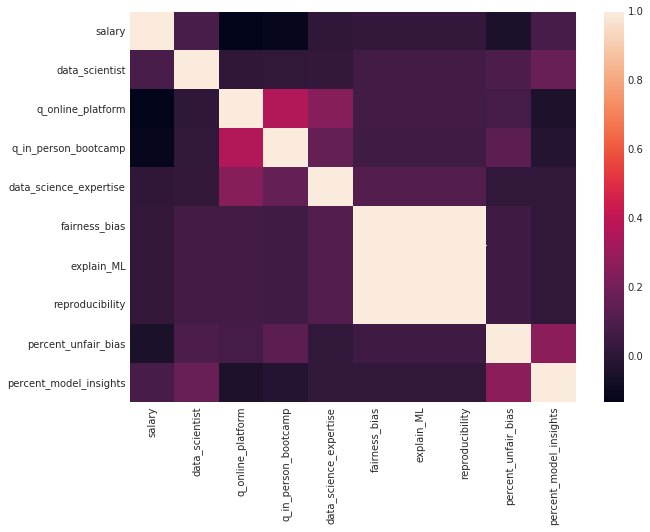

In [349]:
plt.figure(figsize=(10,7))
data_insight_features=pd.concat([num_d['salary'], num_d['data_scientist'], num_d['q_online_platform'], 
                        num_d['q_in_person_bootcamp'], num_d['data_science_expertise'],
                        num_d['fairness_bias'], num_d['explain_ML'], num_d['reproducibility'],
                        num_d['percent_unfair_bias'],num_d['percent_model_insights']], axis=1)
corr = data_insight_features.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

We can observe that in spite of the low overall correlation between salary and other features, the opinion of the participant on whether he/she considers themselves to be a data scientist and model insights have a slight impact on salary. 

In [350]:
#categorical features that cannot be numbered 
data_temp=pd.concat([data.iloc[:,1], num_d],axis=1)
#drop a few features that have to be added as dummy in the next step
data_temp=data_temp.drop(['gender','country','degree','major','title','degree','industry',
                         'primary_tools','programming_language','ML_library','online_platform'],axis=1)
#make dummy variables out of the ones that have just been dropped
dummies_gender=pd.get_dummies(data.iloc[:,2], prefix='gender')
dummies_country=pd.get_dummies(data.iloc[:,5], prefix='country')
dummies_degree=pd.get_dummies(data.iloc[:,6], prefix='degree')
dummies_major=pd.get_dummies(data.iloc[:,7], prefix='major')
dummies_title=pd.get_dummies(data.iloc[:,8], prefix='title')
dummies_industry=pd.get_dummies(data.iloc[:,10], prefix='industry')
dummies_primary_tools=pd.get_dummies(data.iloc[:,23], prefix='primary_tools')
dummies_programming_language=pd.get_dummies(data.iloc[:,85], prefix='programming_language')
dummies_ML_library=pd.get_dummies(data.iloc[:,109], prefix='ML_library')
dummies_online_platform=pd.get_dummies(data.iloc[:,306], prefix='online_platform')

data_temp=pd.concat([data_temp, dummies_gender, dummies_country, dummies_degree, dummies_major, dummies_title, dummies_industry,
                     dummies_primary_tools, dummies_programming_language, dummies_ML_library, dummies_online_platform],axis=1)

In [351]:
#leave only data that is for Male and female genders
#data=data[(data.iloc[:,2]=='Male')|(data.iloc[:,2]=='Female')]
#leave only data that is for Bachelor's, Master's and Doctors
labels=data.iloc[:,6].value_counts().index
data=data[(data.iloc[:,6]==labels[0])|(data.iloc[:,6]==labels[1])|(data.iloc[:,6]==labels[2])]

Let's look at the variables where the user can select among different options, and each pick corresponds to a feature 

In [352]:
def median_tools(sal_data,data_skill):
    pd_data=pd.concat([sal_data.copy(), data_skill.copy()], axis=1)
    m_mat=pd.DataFrame()
    for i in range((data_skill.shape[1])):
        m=(pd_data.iloc[:,0].groupby(data_skill.iloc[:,i]))
        m=m.apply(pd.DataFrame)
        m=(m-sal_data.mean()).div(sal_data.std())
        m_mat=pd.concat([m_mat,m],axis=1)
    m_mat.boxplot()

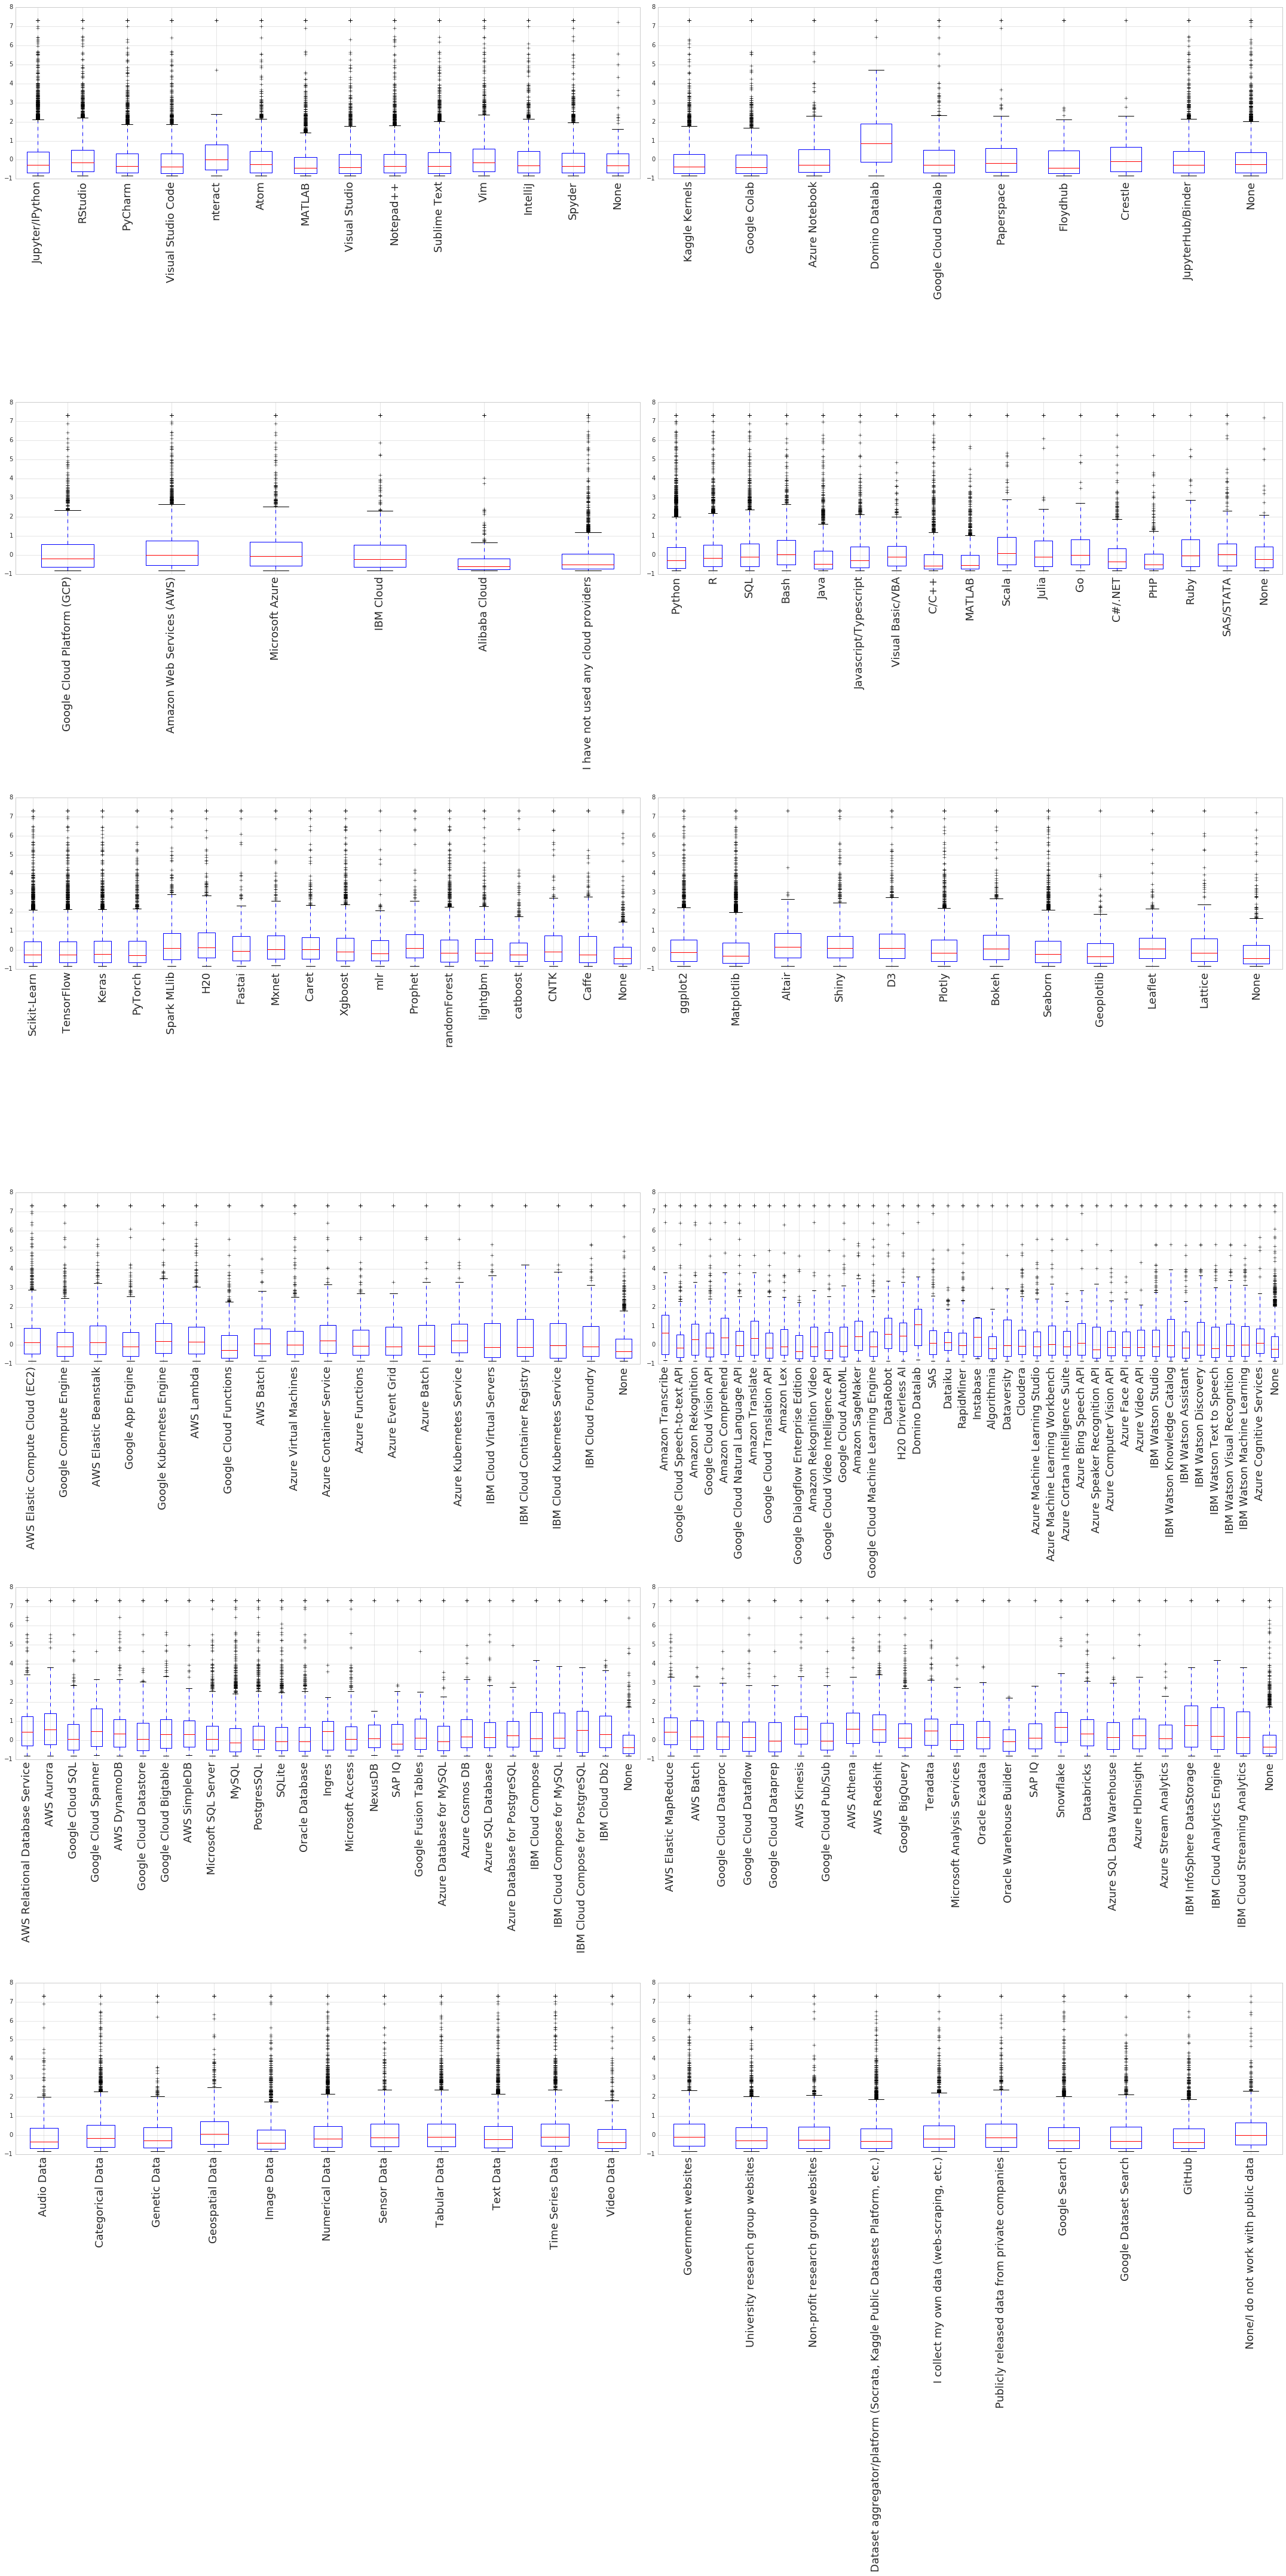

In [353]:
plt.figure(figsize=(30,60))
plt.subplot(6,2,1)
median_tools(data['Q9'],data.iloc[:,30:44])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,2)
median_tools(data['Q9'],data.iloc[:,46:56])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,3)
median_tools(data['Q9'],data.iloc[:,58:64])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,4)
median_tools(data['Q9'],data.iloc[:,66:83])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,5)
median_tools(data['Q9'],data.iloc[:,89:107])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,6)
median_tools(data['Q9'],data.iloc[:,111:123])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,7)
median_tools(data['Q9'],data.iloc[:,131:150])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,8)
median_tools(data['Q9'],data.iloc[:,152:194])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,9)
median_tools(data['Q9'],data.iloc[:,196:223])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,10)
median_tools(data['Q9'],data.iloc[:,225:249])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,11)
median_tools(data['Q9'],data.iloc[:,251:262])
plt.xticks(rotation=90,size=18)
plt.subplot(6,2,12)
median_tools(data['Q9'],data.iloc[:,266:276])
plt.xticks(rotation=90,size=18)
plt.tight_layout()

As we can observe, there is little observable variation between each specific feature. This demonstrates the possible difficulty in determining salaries, especially the higher values. 


Create dummies to prepare data for training later. Dummies essentially transform a categorical feature with many options into several features with values of 1 or 0. This step is needed as the supervised machine learning models require numerical inputs

In [354]:
#dummies_role_at_work = pd.get_dummies(data.iloc[:,15:22], prefix='role_at_work')
dummies_IDE = pd.get_dummies(data.iloc[:,30:44], prefix='IDE')
dummies_notebooks = pd.get_dummies(data.iloc[:,46:56], prefix='notebooks')
dummies_cloud = pd.get_dummies(data.iloc[:,58:64], prefix='cloud')
dummies_programming_languages = pd.get_dummies(data.iloc[:,66:83], prefix='programming_languages')
dummies_ML_frameworks = pd.get_dummies(data.iloc[:,89:107], prefix='ML_frameworks')
dummies_visualization = pd.get_dummies(data.iloc[:,111:123], prefix='visualization')
dummies_cloud_products = pd.get_dummies(data.iloc[:,131:150], prefix='cloud_products')
dummies_ML_products = pd.get_dummies(data.iloc[:,152:194], prefix='ML_products')
dummies_relational_database = pd.get_dummies(data.iloc[:,196:223], prefix='relational_database')
dummies_big_data = pd.get_dummies(data.iloc[:,225:249], prefix='big_data')
dummies_type_of_data = pd.get_dummies(data.iloc[:,251:262], prefix='type_of_data')
dummies_public_datasets = pd.get_dummies(data.iloc[:,266:276], prefix='public_datasets')
data_science_time_proportion = data.iloc[:,278:283].copy()
training_proportion = data.iloc[:,285:290].copy()
training_proportion.fillna(training_proportion.mean(), inplace=True)
data_science_time_proportion.fillna(data_science_time_proportion.mean(), inplace=True)
dummies_online_platforms = pd.get_dummies(data.iloc[:,292:304], prefix='online_platforms')
dummies_media_source = pd.get_dummies(data.iloc[:,308:329], prefix='media_source')
dummies_metrics = pd.get_dummies(data.iloc[:,337:341], prefix='metrics')
dummies_difficulties = pd.get_dummies(data.iloc[:,344:349], prefix='difficulties')
dummies_model_insights = pd.get_dummies(data.iloc[:,350:355], prefix='model_insights')
dummies_interpretation_methods = pd.get_dummies(data.iloc[:,357:372], prefix='interpretation_methods')
dummies_methods_reproducibility = pd.get_dummies(data.iloc[:,374:385], prefix='methods_reproducibility')
dummies_barriers = pd.get_dummies(data.iloc[:,387:394], prefix='barriers')




In [355]:
data_temp=pd.concat([data_temp, dummies_IDE, dummies_notebooks,
                     dummies_cloud, dummies_programming_languages, dummies_ML_frameworks, dummies_visualization, dummies_cloud_products,
                     dummies_ML_products, dummies_relational_database, dummies_big_data, dummies_type_of_data, dummies_public_datasets,
                     dummies_online_platforms, dummies_media_source, dummies_metrics, dummies_difficulties, dummies_model_insights, 
                     dummies_interpretation_methods, dummies_methods_reproducibility, dummies_barriers, data_science_time_proportion, training_proportion,
                     dummies_role_at_work, data['Q9']],axis=1)
 #data_science_time_proportion, training_proportion
data_temp=data_temp.sort_values('Q9', ascending=True)
data_temp2=data_temp.copy()
data_temp=data_temp.dropna()

### 3. Feature selection

The results shown above show that features appear to play a more significant importance on salary are as follows: avg age, 
gender, 
country, 
title, 
industry, 
ML years, 
years_coding, 
ML_incorporation, 
coding_time, 
ML_library, 
Data_scientist
Role_work
We can use also use statistical tools to evaluate features that may be more relevant to determining salary. 

Let's look at some feature selections, namely low variance feature selection, and univariate feature selection (as discussed in https://scikit-learn.org/stable/modules/feature_selection.html). 

Variance uses a threshold to remove features with low variance, keeping those only with high variance. Variables that have a low variance may be discarded.
Univariate selection basically uses the F-test between each parameter and the target variable to determine which values have the largest correlation.

In [356]:
#low variance feature selection:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
variance_data=sel.fit_transform(data_temp.drop(columns=['Q9','salary']))

#
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
feat_selection=SelectKBest(f_regression, k=10)
univariate_data = SelectKBest(f_regression, k=15).fit_transform(data_temp.drop(columns=['Q9','salary']), data_temp['Q9'])

print(variance_data.shape)
print(univariate_data)

(10756, 128)
[[23.   3.5  0.  ...  0.   0.   0. ]
 [27.   0.5  0.  ...  0.   0.   0. ]
 [23.   2.5  2.  ...  0.   0.   1. ]
 ...
 [23.   2.5  2.  ...  0.   1.   1. ]
 [52.   7.5  1.  ...  0.   1.   0. ]
 [23.  17.5  2.  ...  0.   0.   1. ]]


With univariate feature selection, we can observe the 10 features with the highest F and lowest p-values:

In [357]:
F, pval=f_regression(data_temp.drop(columns=['Q9','salary']), data_temp['Q9'])
print(len(F))
print(len(pval))
print(data_temp.shape)
pd_feature_f_test=pd.DataFrame({'feature F':F, 'feature p':pval, 'features':(list(data_temp.drop(columns=['Q9','salary'])))})
pd_feature_f_test.nlargest(15, ['feature F']) 

495
495
(10756, 497)


feature F      feature p  \
77   2527.611199   0.000000e+00   
1    2269.430958   0.000000e+00   
5    2028.284606   0.000000e+00   
6    1200.877976  1.501798e-249   
2    1072.092532  3.101591e-224   
117   894.733768  6.521405e-189   
3     827.442395  2.285181e-175   
125   765.138377  9.357651e-163   
215   559.550457  1.227248e-120   
267   524.312360  2.438291e-113   
431   486.480594  1.773695e-105   
42    458.988999  9.534099e-100   
491   455.887994   4.232389e-99   
363   445.590417   5.990509e-97   
421   389.250573   3.824051e-85   

                                           features  
77                 country_United States of America  
1                                           avg age  
5                                      years_coding  
6                                          ML_years  
2                                   role_experience  
117                                   title_Student  
3                                  ML_incorporation  
125                         industry_I am a student  
215                 cloud_Amazon Web Services (AWS)  
267  cloud_products_AWS Elastic Compute Cloud (EC2)  
431           metrics_Revenue and/or business goals  
42                                    country_India  
491          Prototype building for ML in new areas  
363                           big_data_AWS Redshift  
421                media_source_FiveThirtyEight.com

It is interesting to notice what features might be more significantly correlated to salary. We  can observe that  being in the USA or not can be a significant factor in predicting someone's salary. In addition, age and the number of years a person is coding can be quite significant. The incorporation and experience in ML also appears to be important, as well as the fact someone is a student or not. Exposure and experience to some cloud tools can also have some effect

The following subset contains features that are deemed to be the most relevant by inspecting the correlation plots shown previously.

In [358]:
data_rel_feat=pd.concat([data['avg age'], pd.get_dummies(data.iloc[:,2], prefix='gender'), pd.get_dummies(data.iloc[:,5], prefix='country'),
                         pd.get_dummies(data.iloc[:,8], prefix='title'), pd.get_dummies(data.iloc[:,10], prefix='industry'), num_d['ML_years'],
                         num_d['years_coding'], num_d['ML_incorporation'], num_d['coding_time'], pd.get_dummies(data.iloc[:,109], prefix='ML_library'),
                         num_d['data_scientist'], num_d['percent_model_insights'], dummies_role_at_work, data['Q9']], axis=1)
                         
data_rel_feat=data_rel_feat.dropna() 
print(len(data_rel_feat))

14122


Given the fact that different feature selection methods may lead to different answers, the best way 
to know which method to choose is by comparing their training and testing accuracy in the prediction of the same target variable, namely salary.

### 4. Data Visualization

Let's look at the distribution of respondents according to gender:

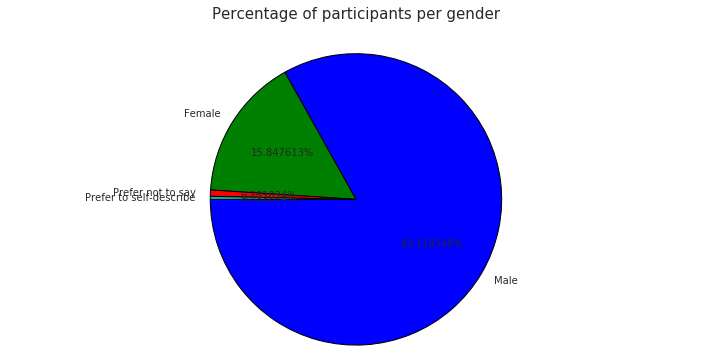

In [359]:
data_gender_array=data.iloc[:,2].groupby(data.iloc[:,2]).count()
#print(data_country_array)
labels=data.iloc[:,2].value_counts().index
values=data.iloc[:,2].value_counts().values
genders=data.iloc[:,2].unique()
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
plt.title('Percentage of participants per gender',y=1.1,size=15)
plt.tight_layout()
plt.show()

As we can observe, a substantial percentage of data scientists and analysts is male (more than 80%). Females are a significant minority

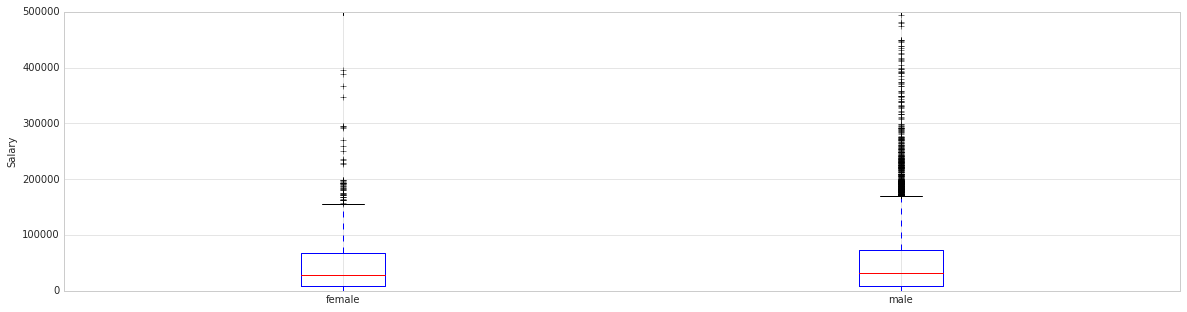

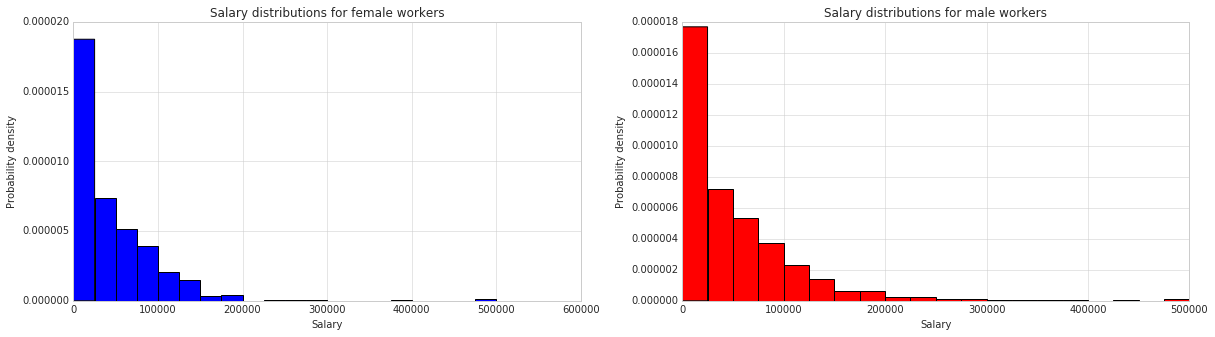

In [360]:
male_data=data[data.iloc[:,2]=='Male']
female_data=data[data.iloc[:,2]=='Female']
plt.figure(figsize=(20,5))
plt.ylabel('Salary')
sal_per_gender=plt.boxplot([list(female_data.iloc[:,13].astype(float)),list(male_data.iloc[:,13].astype(float))])
plt.xticks([1,2],['female','male'])
#plt.yscale('log')
plt.show()
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(list(female_data.iloc[:,13].astype(float)), normed=True, bins=20, color='b')
plt.xlabel('Salary'); plt.ylabel('Probability density'); plt.title('Salary distributions for female workers')
plt.subplot(1,2,2)
plt.hist(list(male_data.iloc[:,13].astype(float)), normed=True, bins=20, color='r')
plt.xlabel('Salary'); plt.ylabel('Probability density'); plt.title('Salary distributions for male workers')
plt.show()


We can see in the boxplot the the overall median salaries between males and females is very much the same. However, we can observe that for males there is a significant number of large outliers. This can either imply a significant difference between the two groups, or because the number of males far surpasses the number of females, which means more outliers are common. More statistical analysis would be required to determine if the differences are statistically signficant.

Let's evaluate the relationship between degree and salaries.

'Doctoral degree'

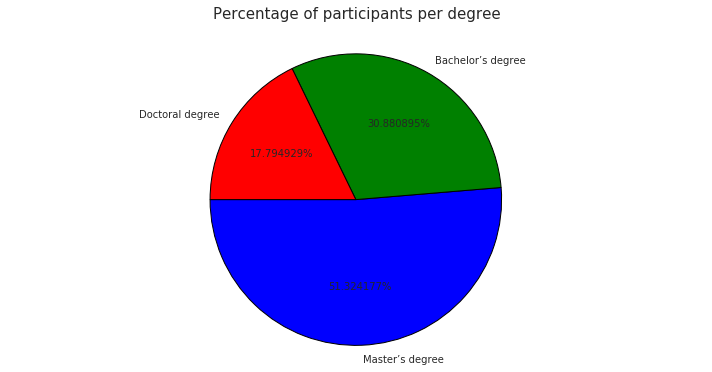

In [361]:
data_degree_array=data.iloc[:,6].groupby(data.iloc[:,6]).count()
#print(data_country_array)
labels=data.iloc[:,6].value_counts().index
values=data.iloc[:,6].value_counts().values
degrees=data.iloc[:,6].unique()
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
plt.title('Percentage of participants per degree',y=1.1,size=15)
plt.tight_layout()
#plt.show()
labels[2]

([<matplotlib.axis.XTick at 0x7fda684db390>,
 <a list of 3 Text xticklabel objects>)

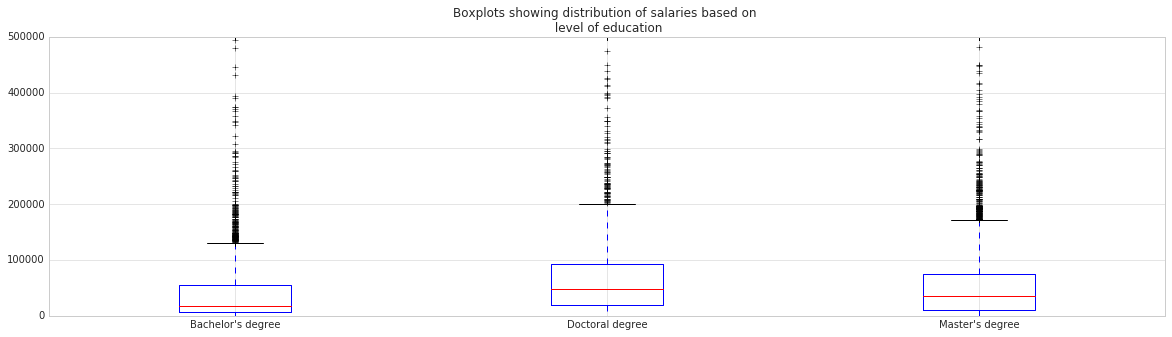

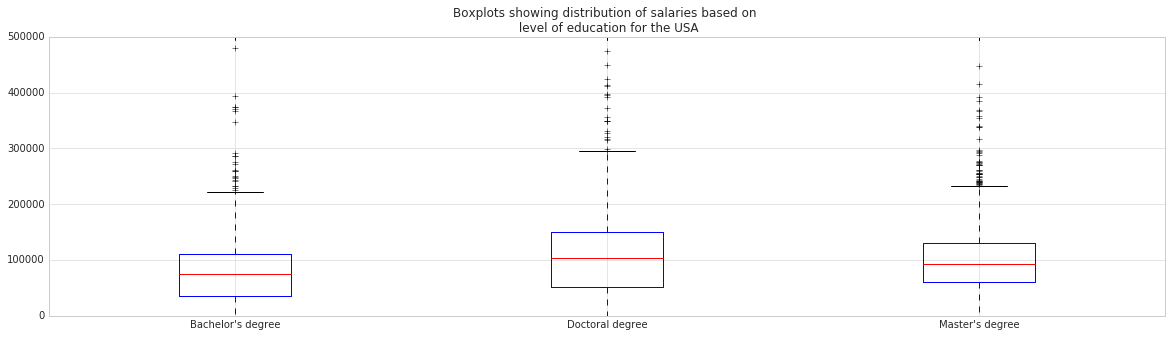

In [362]:
bachelor_data=data[(data.iloc[:,6]==labels[1])]
doctoral_data=data[(data.iloc[:,6]=="Doctoral degree")]
master_data=data[(data.iloc[:,6]==labels[0])]
#print(doctoral_data)
plt.figure(figsize=(20,5))

sal_per_deg=plt.boxplot([list(bachelor_data.iloc[:,13].astype(float)),list(doctoral_data.iloc[:,13].astype(float)),list(master_data.iloc[:,13].astype(float))])
plt.xticks([1,2,3],["Bachelor's degree","Doctoral degree","Master's degree"])
plt.title('Boxplots showing distribution of salaries based on \n level of education')
bachelor_data=data[(data.iloc[:,6]==labels[1]) & (data.iloc[:,5] == "United States of America")]
doctoral_data=data[(data.iloc[:,6]=="Doctoral degree") & (data.iloc[:,5] == "United States of America")]
master_data=data[(data.iloc[:,6]==labels[0]) & (data.iloc[:,5] == "United States of America")]
plt.figure(figsize=(20,5))
plt.title('Boxplots showing distribution of salaries based on \n level of education for the USA')
sal_per_deg=plt.boxplot([list(bachelor_data.iloc[:,13].astype(float)),list(doctoral_data.iloc[:,13].astype(float)),list(master_data.iloc[:,13].astype(float))])
plt.xticks([1,2,3],["Bachelor's degree","Doctoral degree","Master's degree"])

Doctoral degrees appear to lead to slightly larger median salaries. Overall, the outliers (high salaries) are not explained well by the level of education.

Let's evaluate the influence the relationship between country with salaries. The bubble plots go from low salaries (smaller, light bubbles), to higher salaries (larger, darker bubble)

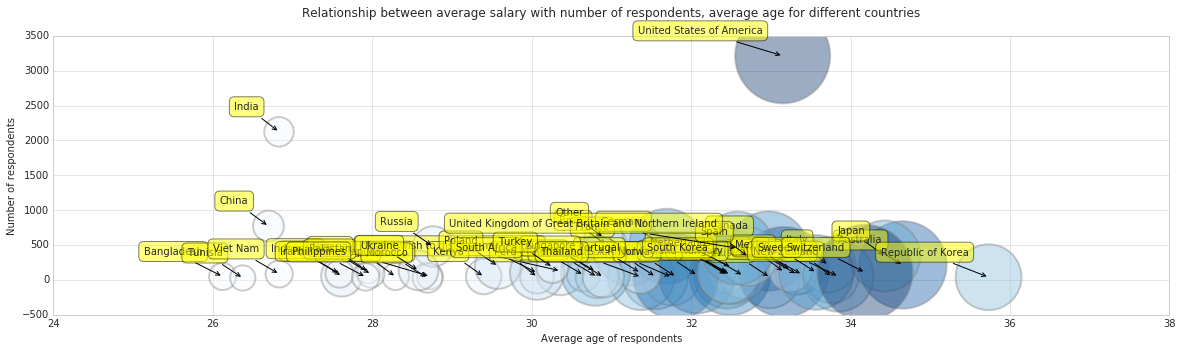

In [363]:
list_of_countries=data.iloc[:,5].value_counts().index
list_of_countries=sorted(list_of_countries)
mean_sal_per_country=data.iloc[:,13].groupby(data.iloc[:,5]).median()
mean_age_per_country=data.iloc[:,-1].groupby(data.iloc[:,5]).mean()
num_prof_per_country=data.iloc[:,5].groupby(data.iloc[:,5]).count()
females_to_males_per_country=(female_data.iloc[:,5].groupby(female_data.iloc[:,5]).count())/(male_data.iloc[:,5].groupby(male_data.iloc[:,5]).count())

plt.figure(figsize=(20,5))
plt.scatter(mean_age_per_country,num_prof_per_country, s=mean_sal_per_country*0.1, c=mean_sal_per_country, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)

for label, x, y in zip(list_of_countries, mean_age_per_country, num_prof_per_country):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

#plt.annotate(data.iloc[:,5].unique())
# Add titles (main and on axis)

plt.xlabel("Average age of respondents")
plt.ylabel("Number of respondents")
ttl=plt.title("Relationship between average salary with number of respondents, average age for different countries")
ttl.set_position([.5, 1.05])
plt.show()

We can observe some interesting trends on how data tends to cluster with respect to countries. The two countries that have the largest number of respondents are the US and India. US appears to have the largest median salary, along with other European countries. India appears to have an overall low median salary. Developing nations tends to cluster on the left side of the plot, whereas developed nations tend to cluster more on the right hand side, where professionals who answered the survey are often older.

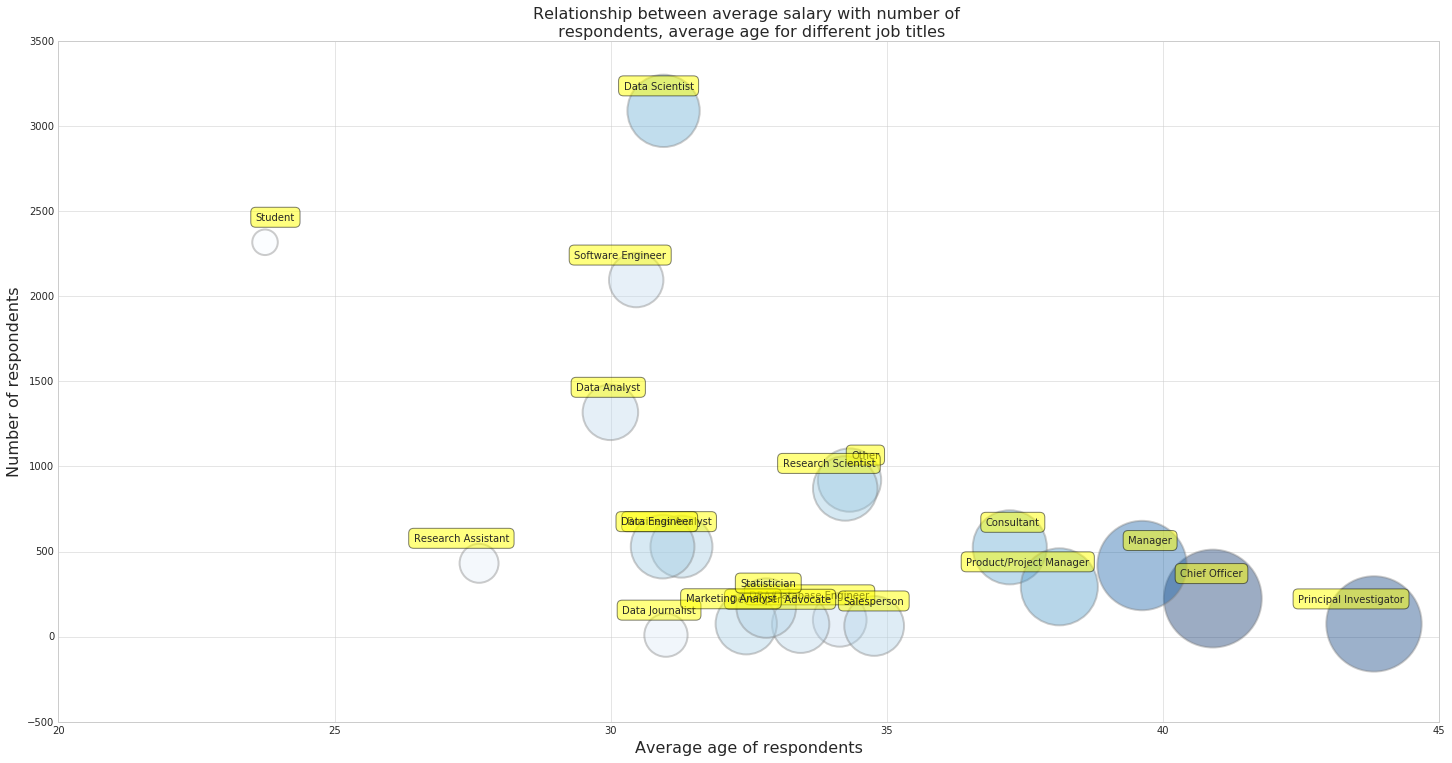

In [364]:
list_of_roles=data.iloc[:,8].value_counts().index
list_of_roles=sorted(list_of_roles)
mean_sal_per_role=data.iloc[:,13].groupby(data.iloc[:,8]).median()
mean_age_per_role=data.iloc[:,-1].groupby(data.iloc[:,8]).mean()
num_prof_per_role=data.iloc[:,5].groupby(data.iloc[:,8]).count()
plt.figure(figsize=(20,10))
plt.scatter(mean_age_per_role,num_prof_per_role, s=mean_sal_per_role*0.1, c=mean_sal_per_role, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)

for label, x, y in zip(list_of_roles, mean_age_per_role, num_prof_per_role):
    plt.annotate(
        label,
        xy=(x, y), xytext=(30, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))


# Add titles (main and on axis)
plt.tight_layout()
plt.xlabel("Average age of respondents",size=16)
plt.ylabel("Number of respondents",size=16)
plt.title("Relationship between average salary with number of \n respondents, average age for different job titles",size=16)
plt.show()

The above figure shows the relationship between job title and median salaries given the number of respondents and the mean age of respondents with each job title. We can observe that the higher median salaries are observed for principal investigators, chief officers, and managers. These are also generally older individuals, as well as less common.

We can also observe that jobs such as research assistant, data journalist and even data analysts are often younger and have lower median salaries. In this plot, we can observe a prospective career path for a data analyst, starting from a student and branching into different options.

Let's evaluate the relationship between median salary, average age, number of respondents and level of education.

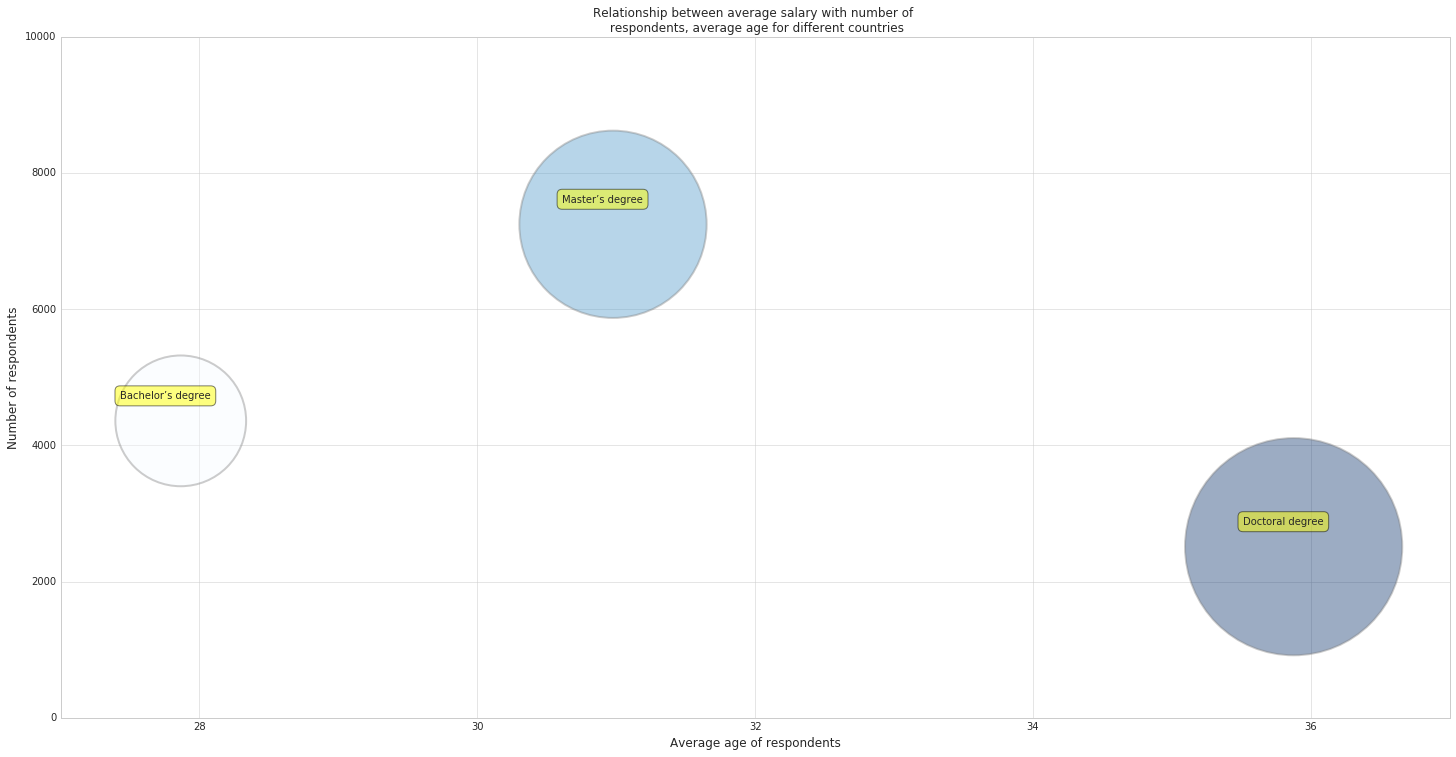

In [365]:
list_of_deg=data.iloc[:,6].value_counts().index
list_of_deg=sorted(list_of_deg)
mean_sal_per_deg=data.iloc[:,13].groupby(data.iloc[:,6]).median()
mean_age_per_deg=data.iloc[:,-1].groupby(data.iloc[:,6]).mean()
num_prof_per_deg=data.iloc[:,5].groupby(data.iloc[:,6]).count()
plt.figure(figsize=(20,10))
plt.scatter(mean_age_per_deg,num_prof_per_deg, s=mean_sal_per_deg*1, c=mean_sal_per_deg, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)

for label, x, y in zip(list_of_deg, mean_age_per_deg, num_prof_per_deg):
    plt.annotate(
        label,
        xy=(x, y), xytext=(30, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

#plt.annotate(data.iloc[:,5].unique())
# Add titles (main and on axis)
plt.tight_layout()
plt.xlabel("Average age of respondents",size=12)
plt.ylim([0, 10000])
plt.ylabel("Number of respondents",size=12)
plt.title("Relationship between average salary with number of \n respondents, average age for different countries",size=12)
plt.show()

We can observe that level of education does appear to be related to median salary. It also correlates clearly with average age. 

In the plot shown above, there appears to be a clear progression of salaries from bachelor to master's and to doctoral degrees. Professional with Bachelor's are often younger (lower average age), while master and doctoral professionals are increasingly older.

As it can be observed, respondents with doctoral degrees have the oldest average age, as well as some of the highest average salaries. It is interesting to observe that people with no formal education past high school also appear to have very high salaries overall, although the number of samples is too small to make any significant inference.

Let's evaluate the percentage of other features on the dataset:

In [366]:
#bubble plot the results as a way to demonstrate salary with respect to other variables
def bubble_plot(index_val):
    list_of_deg=data.iloc[:,index_val].value_counts().index
    list_of_deg=sorted(list_of_deg)

    mean_sal_per_deg=data.iloc[:,13].groupby(data.iloc[:,index_val]).median()
    mean_age_per_deg=data.iloc[:,-1].groupby(data.iloc[:,index_val]).mean()
    num_prof_per_deg=data.iloc[:,5].groupby(data.iloc[:,index_val]).count()
    #plt.figure(figsize=(20,10))
    plt.scatter(mean_age_per_deg,num_prof_per_deg, s=mean_sal_per_deg*0.1, c=mean_sal_per_deg, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)

    for label, x, y in zip(list_of_deg, mean_age_per_deg, num_prof_per_deg):
        plt.annotate(
            label,
            xy=(x, y), xytext=(30, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    plt.xlabel("Average age of respondents",size=12)
    plt.ylim([0, 10000])
    plt.ylabel("Number of respondents",size=12)

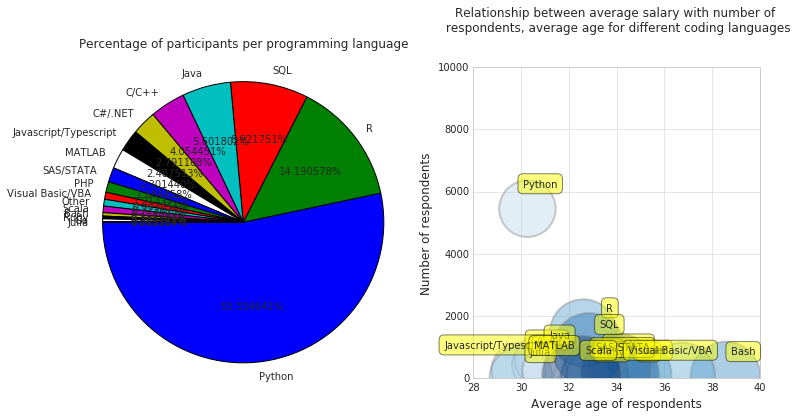

In [367]:
plt.subplot(1,2,1)
programming_language=data.iloc[:,85].groupby(data.iloc[:,85]).count()
labels=data.iloc[:,85].value_counts().index
values=data.iloc[:,85].value_counts().values
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
ttl=plt.title('Percentage of participants per programming language',y=1.1,size=12)
ttl.set_position([.5, 1.05])
plt.tight_layout();

plt.subplot(1,2,2)
bubble_plot(85)
ttl=plt.title("Relationship between average salary with number of \n respondents, average age for different coding languages",size=12)
ttl.set_position([.5, 1.1])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

Python programming language appears to be used the most among the data analytics community, followed by R and SQL

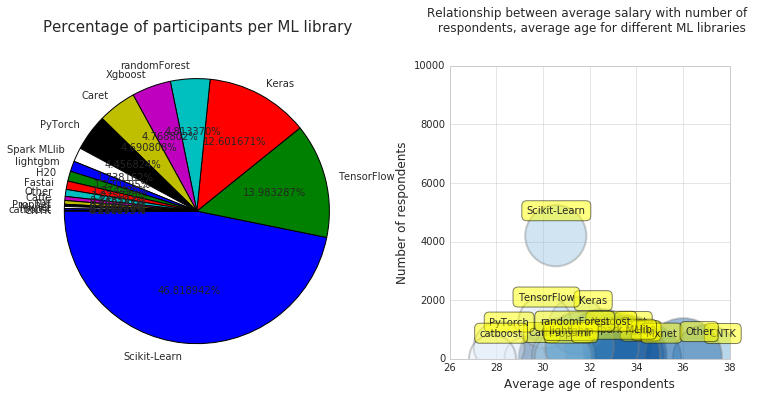

In [368]:
plt.subplot(1,2,1)
ML_library=data.iloc[:,109].groupby(data.iloc[:,109]).count()
#print(data_country_array)
labels=data.iloc[:,109].value_counts().index
values=data.iloc[:,109].value_counts().values
#genders=data.iloc[:,2].unique()
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
plt.title('Percentage of participants per ML library',y=1.1,size=15)
plt.tight_layout();

plt.subplot(1,2,2)
bubble_plot(109)
ttl=plt.title("Relationship between average salary with number of \n respondents, average age for different ML libraries",size=12)
ttl.set_position([.5, 1.1])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

Scikit-Learn, which is a library often implemented in Python, is a commonly used library for ML training

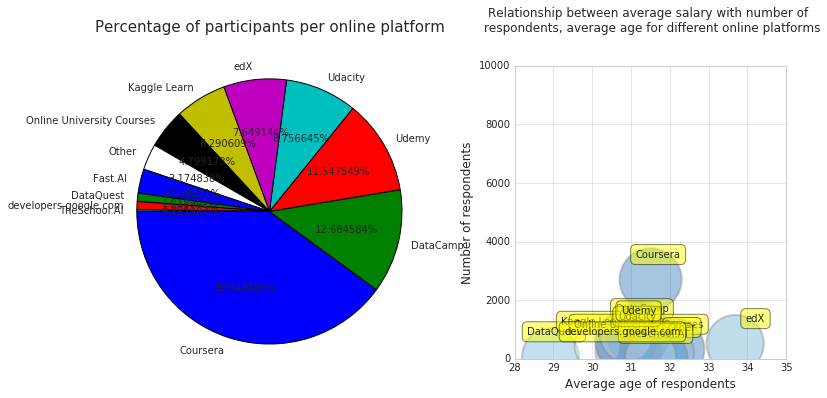

In [369]:
plt.subplot(1,2,1)
online_platform=data.iloc[:,306].groupby(data.iloc[:,306]).count()
#print(data_country_array)
labels=data.iloc[:,306].value_counts().index
values=data.iloc[:,306].value_counts().values
#genders=data.iloc[:,2].unique()
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
plt.title('Percentage of participants per online platform',y=1.1,size=15)
plt.tight_layout();

plt.subplot(1,2,2)
bubble_plot(306)
ttl=plt.title("Relationship between average salary with number of \n respondents, average age for different online platforms",size=12)
ttl.set_position([.5, 1.1])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

Coursera appears to be the most commonly used online platform for learning, with DataCamp and Udemy sharing a portion of the market.

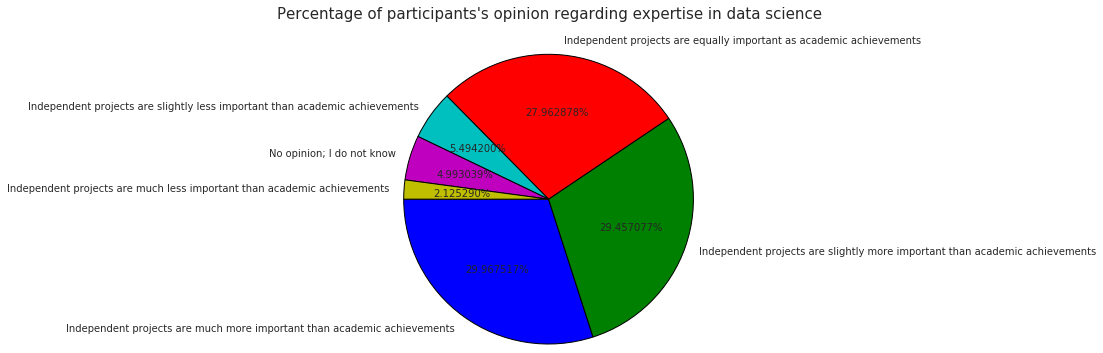

In [370]:
data_science_expertise=data.iloc[:,333].groupby(data.iloc[:,333]).count()
labels=data.iloc[:,333].value_counts().index
values=data.iloc[:,333].value_counts().values
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
plt.title("Percentage of participants's opinion regarding expertise in data science",y=1.1,size=15)
plt.tight_layout();


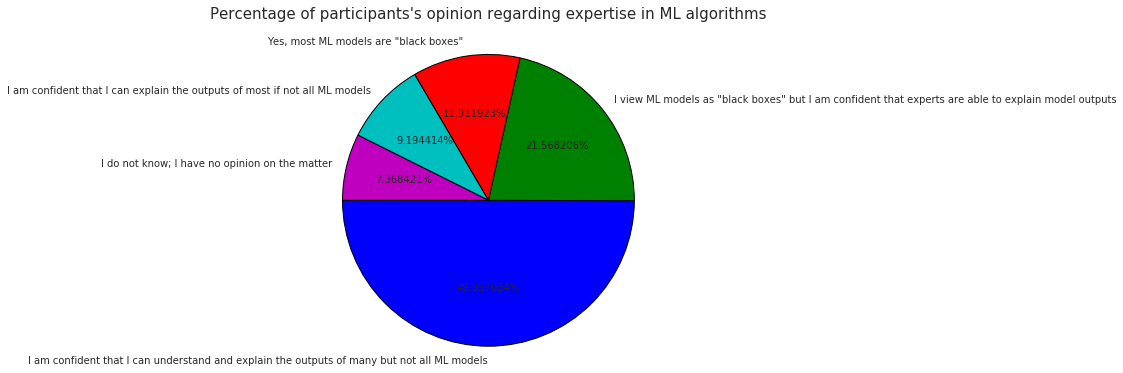

In [371]:
ML_expertise=data.iloc[:,373].groupby(data.iloc[:,373]).count()
labels=data.iloc[:,373].value_counts().index
values=data.iloc[:,373].value_counts().values
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
plt.title("Percentage of participants's opinion regarding expertise in ML algorithms",y=1.1,size=15)
plt.tight_layout();

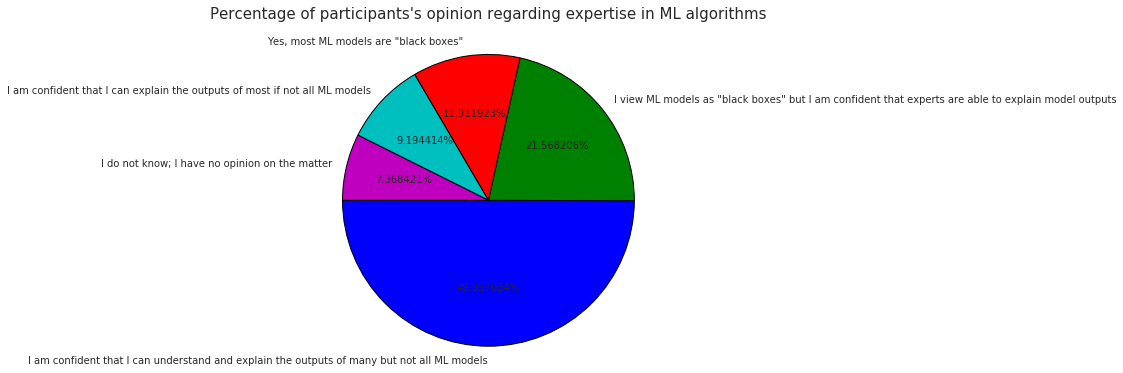

In [372]:
ML_expertise=data.iloc[:,373].groupby(data.iloc[:,373]).count()
labels=data.iloc[:,373].value_counts().index
values=data.iloc[:,373].value_counts().values
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
plt.title("Percentage of participants's opinion regarding expertise in ML algorithms",y=1.1,size=15)
plt.tight_layout();

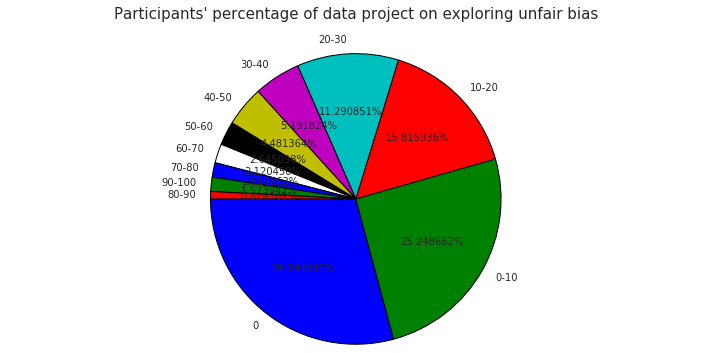

In [373]:
percent_unfair_bias=data.iloc[:,343].groupby(data.iloc[:,343]).count()
labels=data.iloc[:,343].value_counts().index
values=data.iloc[:,343].value_counts().values
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
plt.title("Participants' percentage of data project on exploring unfair bias",y=1.1,size=15)
plt.tight_layout();

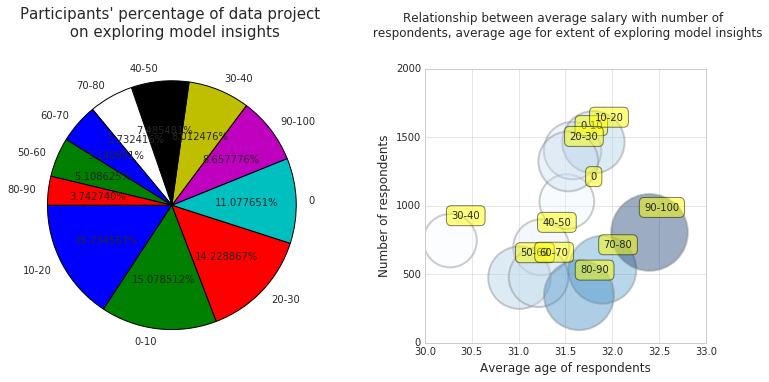

In [374]:
plt.subplot(1,2,1)
percent_model_insights=data.iloc[:,356].groupby(data.iloc[:,356]).count()
labels=data.iloc[:,356].value_counts().index
values=data.iloc[:,356].value_counts().values
plt.pie(values,labels=labels,autopct='%1f%%', shadow=False, startangle=180)
plt.axis('equal')
plt.title("Participants' percentage of data project \n on exploring model insights",y=1.1,size=15)
plt.tight_layout();


plt.subplot(1,2,2)
bubble_plot(356)
ttl=plt.title("Relationship between average salary with number of \n respondents, average age for extent of exploring model insights",size=12)
ttl.set_position([.5, 1.1])
plt.ylim([0,2000])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

Those who spend a major portion of their time at work looking for model insights (70-100%) are often slightly older, and tend to have a higher median salary. 

Another plausible way to evaluate the relationship between features is to use unsupervised learning.
The following function definitions are used for hierarchical clustering algorithms:

In [375]:
#
def fix_list(list_index, cut_from):
    list_to_return=[]
    for i in list_index:
        list_to_return.append(i[cut_from:])
    return list_to_return

In [376]:
# function to obtain hierarchical cluster of features or samples using a predefined distance metrics
def dendogram_features(data_to_cluster, method, metric,color_threshold):
    list_cluster=list(data_to_cluster)
    xx=data_to_cluster.copy()
    xx=StandardScaler().fit_transform(xx)
    Z = hierarchy.linkage(xx.T, method, metric=metric)
    plt.figure(figsize=(10,10))
    dn = hierarchy.dendrogram(Z,orientation='right', labels=list_cluster,
                             leaf_font_size=12,color_threshold=color_threshold)


Let's evaluate how each industry area and job title relate to the tools used in each:

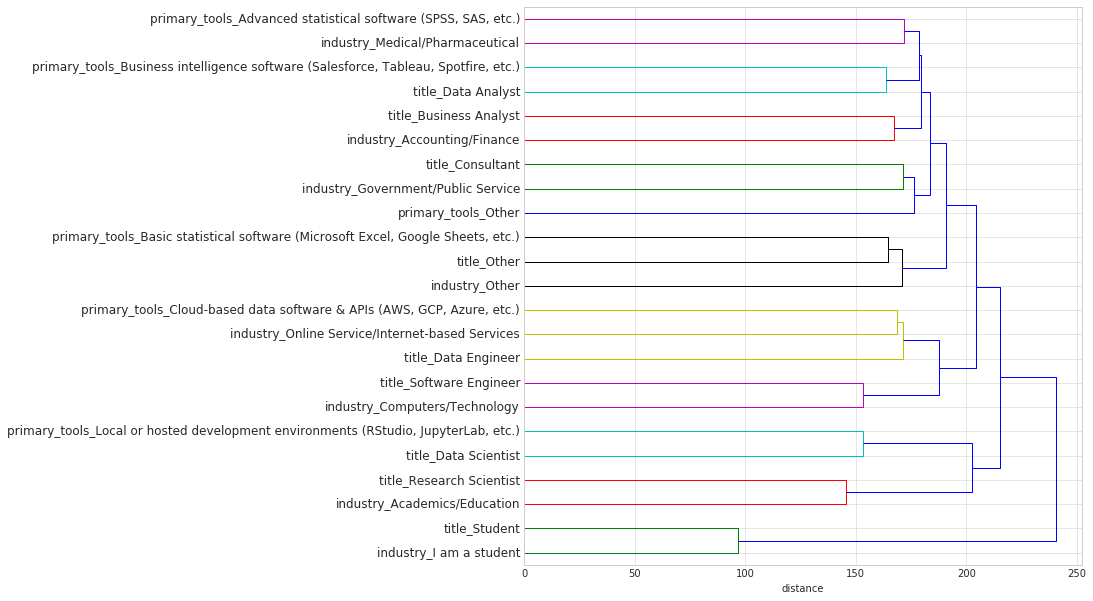

In [377]:
data_to_cluster=pd.concat([dummies_industry,dummies_title,dummies_primary_tools], axis=1)
droplist = [i for i in list(data_to_cluster) if data_to_cluster[i].sum()<=500]
data_to_cluster.drop(droplist,axis=1,inplace=True)
dendogram_features(data_to_cluster, 'ward', 'euclidean',175)
plt.xlabel('distance')

As we can observe, a signficant number of data scientists tend to rely on local or hosted environments for their data science projects, whereas for financial and accounting, data analysts tend to use business intelligence software more often. Online services tend to rely mostly on cloud-based data and API's, and software engineers appear to use a variety of software and tools that are not identifiable here.

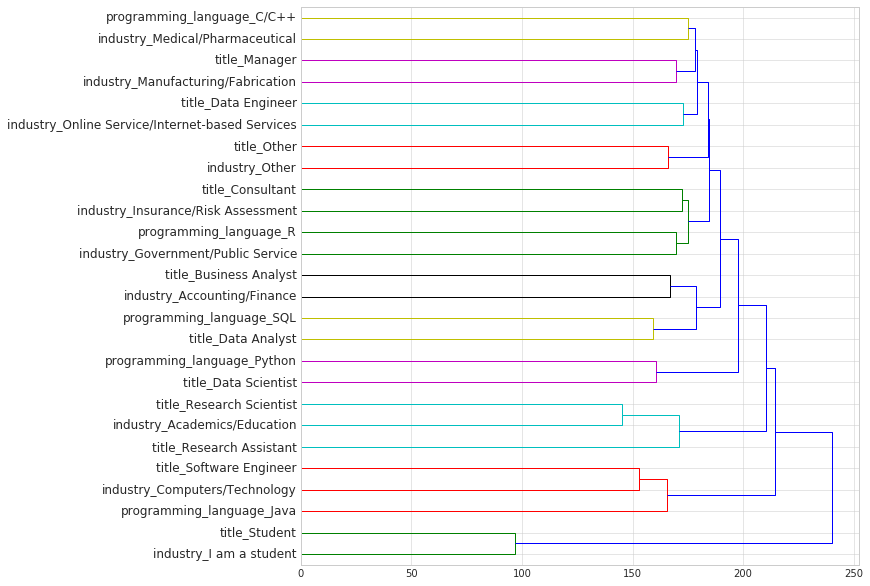

In [378]:
data_to_cluster=pd.concat([dummies_industry,dummies_title,dummies_programming_language], axis=1)
droplist = [i for i in list(data_to_cluster) if data_to_cluster[i].sum()<=400]
data_to_cluster.drop(droplist,axis=1,inplace=True)
dendogram_features(data_to_cluster, 'ward', 'euclidean',175)

In the above dendogram, we can identify some trends. Python appears to be the prefered choice for data scientists. Software engineers, who often work on the computer/technology industry, as identified by the clustering algorithm, often rely on programming languages such as Java for software development. SQL seems to be a common choice for data analysts and those who work on accounting and financial services. The coding language R appears to be predominant among engineers and those who work in the medical and pharmaceutical industries.

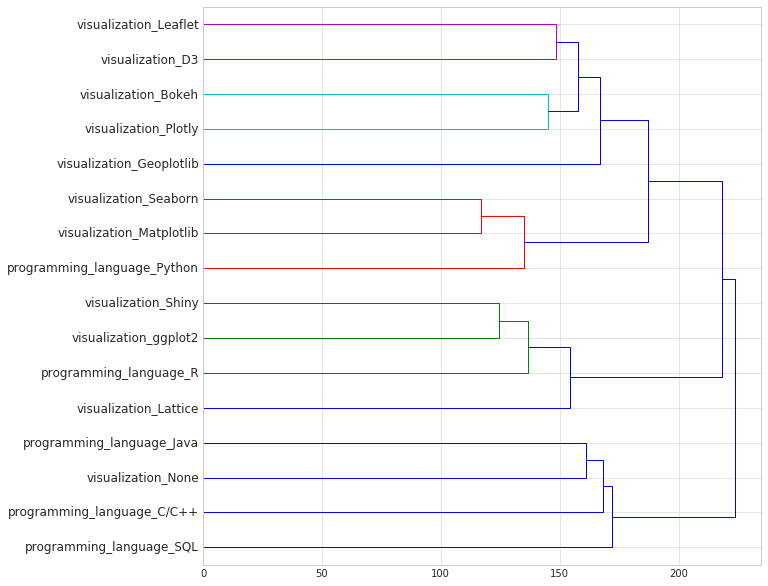

In [379]:
data_to_cluster=pd.concat([dummies_visualization,dummies_programming_language], axis=1)
droplist = [i for i in list(data_to_cluster) if data_to_cluster[i].sum()<=400]
data_to_cluster.drop(droplist,axis=1,inplace=True)
data_to_cluster=data_to_cluster.dropna()
dendogram_features(data_to_cluster, 'ward', 'euclidean',150)

With respect to visualization techniques, languages such as SQL (for managing databases) and Java (software development) tend to not be used primarily for visualization. Python is closely correlated with seaborn and matplotlib. Overall, the clustering algorithm seems to correlctly identify the visualization tool with the languages in which they are most often used for. This is a good sanity check for the algorithm

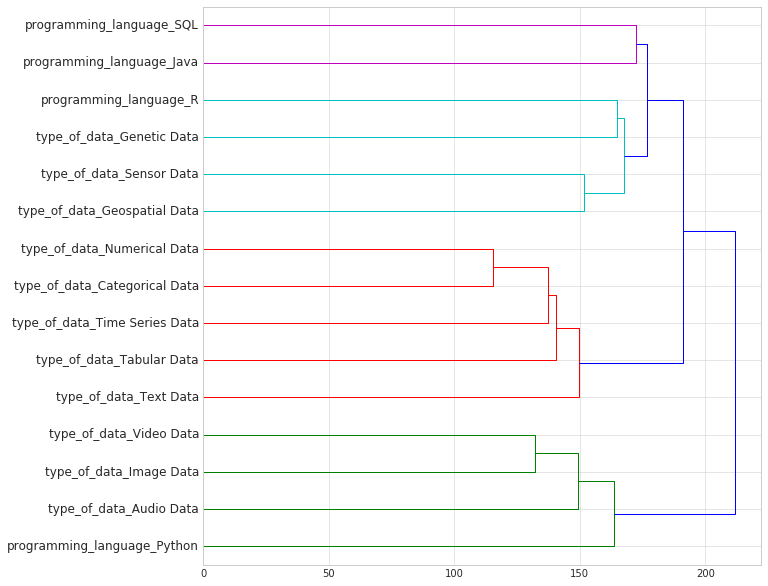

In [380]:
data_to_cluster=pd.concat([dummies_type_of_data,dummies_programming_language], axis=1)
droplist = [i for i in list(data_to_cluster) if data_to_cluster[i].sum()<=500]
data_to_cluster.drop(droplist,axis=1,inplace=True)
data_to_cluster=data_to_cluster.dropna()
dendogram_features(data_to_cluster, 'ward', 'euclidean',175)

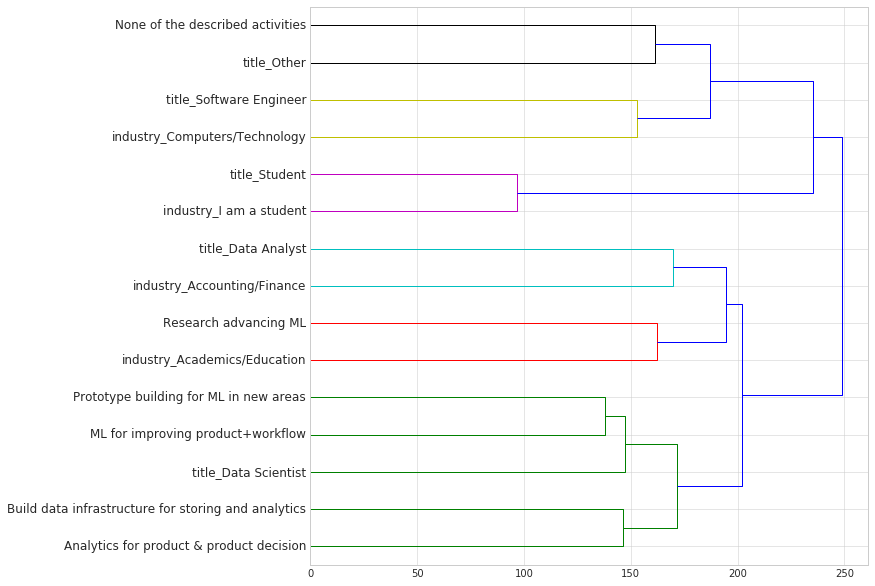

In [381]:
data_to_cluster=pd.concat([dummies_industry,dummies_title,dummies_role_at_work], axis=1)
droplist = [i for i in list(data_to_cluster) if data_to_cluster[i].sum()<=1000]
data_to_cluster.drop(droplist,axis=1,inplace=True)
data_to_cluster=data_to_cluster.dropna()
dendogram_features(data_to_cluster, 'ward', 'euclidean',175)

As we can observe in the above plot, data scientists are more closely related to several roles, such as building machine learning tools for improving products, bulding protocols for machine learning implementation, building data infrastructure, and analyzing data for decision making. Academy and education are more focused on research and advancement of machine learning algorithms. 

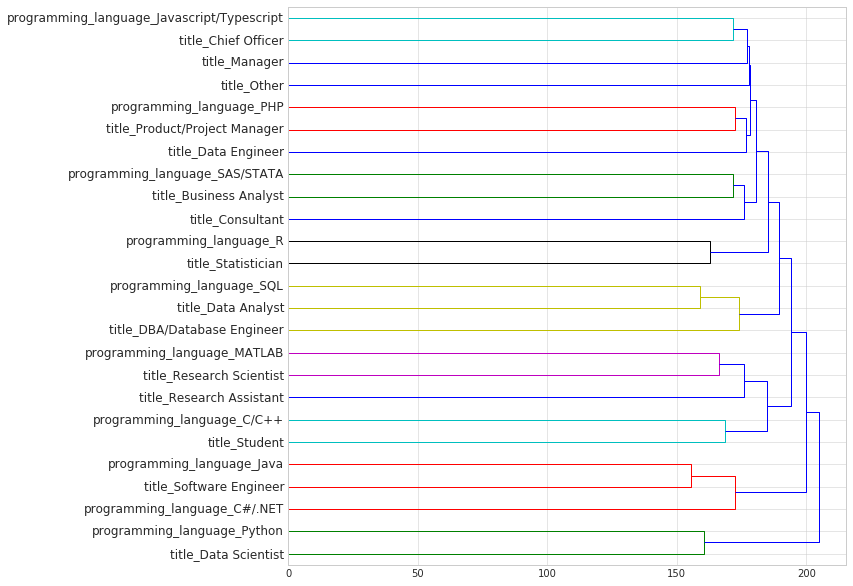

In [382]:
data_to_cluster=pd.concat([dummies_title,dummies_programming_language], axis=1)
droplist = [i for i in list(data_to_cluster) if data_to_cluster[i].sum()<=100]
data_to_cluster.drop(droplist,axis=1,inplace=True)
dendogram_features(data_to_cluster, 'ward', 'euclidean',175)

In the above dendrogram, we see that data scientists often use Python as their programming languages. Software engineers implement programming languages (Java/C#) which are traditionally more implemented for software development. Students tend to rely more on C++, and research scientists use MATLAB given its multiple tools. Business analysts and consultants often rely on SAS.

### 5. Implementation of Supervised Learning algorithms

Given the previous results showing the relationship between some of the features, we can now implement machine learning algorithms to undestand how each feature may or may not affect salary. The data is randomly splitted into 70% training set and 30% testing set. In what follows, the implementation of several learning algorithms are shown:

In [383]:
# functions to run cross-validation checks given a model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
def ml_score(clf,X,Y):
    cv=ShuffleSplit(n_splits=10, test_size=0.3)
    scores=cross_val_score(clf, X, Y, cv=cv) 
    return scores.mean(), scores.std()

def ml_score_train(clf,X,Y):
    cv=ShuffleSplit(n_splits=10, test_size=0.3)
    scores=cross_validate(clf, X, Y, return_train_score=True, cv=cv) 
    return clf, scores['test_score'].mean(), scores['train_score'].mean()

def ml_score_std(clf,X,Y):
    cv=ShuffleSplit(n_splits=10, test_size=0.3)
    scores=cross_validate(clf, X, Y, return_train_score=True, cv=cv) 
    return clf, scores['test_score'].mean(), scores['train_score'].mean(), scores['test_score'].std(), scores['train_score'].std()


def ml_acc(clf,X,Y):
    mdl=clf.fit(X, Y)
    acc=clf.score(X,Y)
    return acc


def simple_score(clf,X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
    clf.fit(X_train,y_train)
    y_test_pred=clf.predict(X_test)
    acc=clf.score(X_test, y_test)
    train_acc=clf.score(X_train, y_train)
    return clf, acc, train_acc

def bias_variance_cv(clf,X,Y,xlabel,y_pos):
    n_samples = 20
    f_x, f_y = f(n_samples)
    n_models = 100
    max_degree = 15
    var_vals =[]
    bias_vals = []
    error_vals = []
    for degree in xrange(1, max_degree):
        avg_y = np.zeros(n_samples)
        models = []
        for i in xrange(n_models):
            (x,y) = sample(n_samples)
            model = fit_polynomial(x, y, degree)
            p_y = apply_polynomial(model, x)
            avg_y = avg_y + p_y
            models.append(p_y)
        avg_y = avg_y / n_models
        bias_2 = norm(avg_y - f_y)/f_y.size
        bias_vals.append(bias_2)
        variance = 0
        for p_y in models:
            variance += norm(avg_y - p_y)
        variance /= f_y.size * n_models
        var_vals.append(variance)
        error_vals.append(variance + bias_2)
    pl.plot(range(1, max_degree), bias_vals, label='bias')
    pl.plot(range(1, max_degree), var_vals, label='variance')
    pl.plot(range(1, max_degree), error_vals, label='error')
    pl.legend()

Define functions that trains a series of ML algorithms and output their respective accuracies, given the features (X) and the target (Y). The score for regression is simply the coefficient of determination R^2, which reveals how well fitted the data is. The reason for this choice is its simplicity and for the fact that it is commonly used and easy to understand. It does not provide all information required about the fitting, such the impact that outliers could have or if the regression is properly capturing the target variable in its entire range. This will later be discussed when presenting the target vs. predicted plots. 

The functions ML_train_test_cv and ML_train_test run five machine learning algorithms as a quick way to screen their performance against the training and testing sets. The algorithms chosen are Linear regression, LASSO regression, decision tree, random forest, and k-Nearest Neighbors

In [384]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# function to train, test data and plot results using several ML algorithms for easy comparison:
def ML_train_test_cv (X,Y):
    arr=[]
    reg=LinearRegression()
    reg, LINREG_test_acc, LINREG_train_acc,l_std_test,l_std_train=ml_score_std(reg,X,Y)
    reg = linear_model.Lasso(alpha=1)
    reg, LASREG_test_acc, LASREG_train_acc, l1_std_test,l1_std_train=ml_score_std(reg,X,Y)
    reg=tree.DecisionTreeRegressor(min_samples_leaf=6)
    reg, TREEREG_test_acc, TREEREG_train_acc, t_std_test,t_std_train=ml_score_std(reg,X,Y)
    reg = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=10)
    reg, RFREG_test_acc, RFREG_train_acc, r_std_test,r_std_train=ml_score_std(reg,X,Y)
    reg = KNeighborsRegressor(n_neighbors=2)
    reg, knn_test, knn_train,k_std_test,k_std_train=ml_score_std(reg,X,Y)
    arr=[LINREG_test_acc,LINREG_train_acc,LASREG_test_acc,LASREG_train_acc,TREEREG_test_acc,TREEREG_train_acc,
        RFREG_test_acc,RFREG_train_acc, knn_test, knn_train]
    plt.plot([arr[0],arr[2],arr[4],arr[6], arr[8]],"o-",color='r', label="Testing score")
    plt.plot([arr[1],arr[3],arr[5],arr[7], arr[9]],"o-",color='b', label="Training score")
    plt.fill_between(np.arange(5), np.array([arr[0],arr[2],arr[4],arr[6],arr[8]]) - 2*np.array([l_std_test,l1_std_test,t_std_test,r_std_test,k_std_test]), 
                                             np.array([arr[0],arr[2],arr[4],arr[6],arr[8]]) + 2*np.array([l_std_test,l1_std_test,t_std_test,r_std_test,k_std_test]), alpha=0.1, color="r")
    plt.fill_between(np.arange(5), np.array([arr[1],arr[3],arr[5],arr[7],arr[9]]) - 2*np.array([l_std_train,l1_std_train,t_std_train,r_std_train,k_std_train]),\
                     np.array([arr[1],arr[3],arr[5],arr[7],arr[9]]) + 2*np.array([l_std_train,l1_std_train,t_std_train,r_std_train,k_std_train]), alpha=0.1, \
                     color="b")
    plt.xticks([0,1,2,3,4],['Linear Regression', 'LASSO', 'Decision Tree', 'Random Forest','kNN'], rotation=90)
    plt.ylim([-1, 1.1])
    plt.ylabel('accuracy')
    plt.legend(loc="best")
    return [LINREG_test_acc, LINREG_train_acc, LASREG_test_acc, LASREG_train_acc, 
            TREEREG_test_acc, TREEREG_train_acc, RFREG_test_acc, RFREG_train_acc, 
            knn_test, knn_train, l_std_test,l_std_train, l1_std_test,l1_std_train,
            t_std_test,t_std_train, r_std_test,r_std_train,k_std_test,k_std_train]

def ML_train_test (X,Y):
    reg=LinearRegression()
    reg, LINREG_test_acc, LINREG_train_acc=simple_score(reg,X,Y)
    reg = linear_model.Lasso(alpha=0.1)
    reg, LASREG_test_acc, LASREG_train_acc=simple_score(reg,X,Y)
    reg=tree.DecisionTreeRegressor(min_samples_leaf=5)
    reg, TREEREG_test_acc, TREEREG_train_acc=simple_score(reg,X,Y)
    reg = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=10)
    reg, RFREG_test_acc, RFREG_train_acc=simple_score(reg,X,Y)
    reg = KNeighborsRegressor(n_neighbors=2)
    reg, knn_test, knn_train=simple_score(reg,X,Y)
    arr=[LINREG_test_acc,LINREG_train_acc,LASREG_test_acc,LASREG_train_acc,TREEREG_test_acc,TREEREG_train_acc,
        RFREG_test_acc,RFREG_train_acc, knn_test, knn_train]
    plt.plot([arr[0],arr[2],arr[4],arr[6], arr[8]],"o-",color='r', label="Testing score")
    plt.plot([arr[1],arr[3],arr[5],arr[7], arr[9]],"o-",color='b', label="Training score")
    plt.xticks([0,1,2,3,4],['Linear Regression', 'LASSO', 'Decision Tree', 'Random Forest', 'k-NN'], rotation=90)
    plt.ylim([-1, 1.1])
    plt.ylabel('accuracy')
    plt.legend(loc="best")
    return [LINREG_test_acc, LINREG_train_acc, LASREG_test_acc, LASREG_train_acc, TREEREG_test_acc, TREEREG_train_acc, RFREG_test_acc, RFREG_train_acc]


The following functions are mostly for hyperparameter tuning using different algorithms:

In [385]:
def ML_reg_lasso (X,Y,cross_val):
    test_arr=[]
    train_arr=[]
    test_std=[]
    train_std=[]
    alpha_val=[0, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000];
    for i in range(len(alpha_val)):
        reg = linear_model.Lasso(alpha=alpha_val[i])
        if (cross_val==1):
            reg, LASREG_test, LASREG_train, std_test, std_train=ml_score_std(reg,X,Y)
        else:
            reg, LASREG_test, LASREG_train=simple_score(reg,X,Y)
            std_test=LASREG_test/2
            std_train=LASREG_train/2
        test_arr.append(LASREG_test)
        train_arr.append(LASREG_train)
        test_std.append(std_test)
        train_std.append(std_train); y_pos=np.arange(20)*1000
    plt.figure(figsize=(20,5))
    plt.plot(alpha_val,test_arr,"o-",color='r', label="Testing score")
    plt.plot(alpha_val,train_arr,"o-",color='b', label="Training score")
    plt.fill_between(alpha_val, np.array(test_arr) - 2*np.array(test_std), np.array(test_arr) + 2*np.array(test_std), alpha=0.1, color="r")
    plt.fill_between(alpha_val, np.array(train_arr) - 2*np.array(train_std),\
                     np.array(train_arr) + 2*np.array(train_std), alpha=0.1, \
                     color="b")
    plt.xlabel('alpha')
    plt.ylabel('accuracy')
    return test_arr, train_arr, test_std, train_std

def ML_tree (X,Y):
    test_arr=[]
    train_arr=[]    
    test_std=[]
    train_std=[]
    for i in range(20):
        reg = tree.DecisionTreeRegressor(min_samples_leaf=i*5+1)
        reg, TREEREG_test, TREEREG_train, std_test, std_train=ml_score_std(reg,X,Y)
        test_arr.append(TREEREG_test)
        train_arr.append(TREEREG_train)
        test_std.append(std_test)
        train_std.append(std_train)
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(20)*5+1,test_arr,"o-",color='r', label="Testing score")
    plt.plot(np.arange(20)*5+1,train_arr,"o-",color='b', label="Training score")
    plt.fill_between(np.arange(20)*5+1, np.array(test_arr) - 2*np.array(test_std), np.array(test_arr) + 2*np.array(test_std), alpha=0.1, color="r")
    plt.fill_between(np.arange(20)*5+1, np.array(train_arr) - 2*np.array(train_std),\
                     np.array(train_arr) + 2*np.array(train_std), alpha=0.1, \
                     color="b")
    plt.xlabel('Minimum samples per leaf')
    plt.ylabel('accuracy')
    return test_arr, train_arr, test_std, train_std

def ML_random_forest (X,Y):
    test_arr=[]
    train_arr=[]
    test_std=[]
    train_std=[]
    max_acc=0
    for i in range(5):
        reg = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=100*i+100)
        reg, TREEREG_test, TREEREG_train, std_test, std_train=ml_score_std(reg,X,Y)
        test_arr.append(TREEREG_test)
        train_arr.append(TREEREG_train)
        test_std.append(std_test)
        train_std.append(std_train)
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(5)*100+100,test_arr,"o-",color='r', label="Testing score")
    plt.plot(np.arange(5)*100+100,train_arr,"o-",color='b', label="Training score")
    plt.fill_between(np.arange(5)*100+100, np.array(test_arr) - 2*np.array(test_std), 
                     np.array(test_arr) + 2*np.array(test_std), alpha=0.1, color="r")
    plt.fill_between(np.arange(5)*100+100, np.array(train_arr) - 2*np.array(train_std),\
                     np.array(train_arr) + 2*np.array(train_std), alpha=0.1, \
                     color="b")
    plt.xlabel('Number of estimators')
    plt.ylabel('accuracy')
    return test_arr, train_arr, test_std, train_std

def ML_random_forest_msl (X,Y):
    test_arr=[]
    train_arr=[]
    test_std=[]
    train_std=[]
    for i in range(5):
        reg = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=100, min_samples_leaf=1+i*5, min_samples_split=2)
        reg, TREEREG_test, TREEREG_train, std_test, std_train=ml_score_std(reg,X,Y)
        test_arr.append(TREEREG_test)
        train_arr.append(TREEREG_train)
        test_std.append(std_test)
        train_std.append(std_train)
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(5)*5+1,test_arr,"o-",color='r', label="Testing score")
    plt.plot(np.arange(5)*5+1,train_arr,"o-",color='b', label="Training score")
    plt.fill_between(np.arange(5)*5+1, np.array(test_arr) - 2*np.array(test_std), 
                     np.array(test_arr) + 2*np.array(test_std), alpha=0.1, color="r")
    plt.fill_between(np.arange(5)*5+1, np.array(train_arr) - 2*np.array(train_std),\
                     np.array(train_arr) + 2*np.array(train_std), alpha=0.1, \
                     color="b")
    plt.xlabel('Maximum depth for trees')
    plt.ylabel('accuracy')
    return test_arr, train_arr, test_std, train_std

def ML_random_forest_mss (X,Y):
    test_arr=[]
    train_arr=[]
    test_std=[]
    train_std=[]
    for i in range(10):
        reg = RandomForestRegressor(max_depth=6, n_estimators=100,min_samples_split=2*i+2)
        reg, TREEREG_test, TREEREG_train, std_test, std_train=ml_score_std(reg,X,Y)
        test_arr.append(TREEREG_test)
        train_arr.append(TREEREG_train)
        test_std.append(std_test)
        train_std.append(std_train)
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(10)*2+1,test_arr,"o-",color='r', label="Testing score")
    plt.plot(np.arange(10)*2+1,train_arr,"o-",color='b', label="Training score")
    plt.fill_between(np.arange(10)*2+1, np.array(test_arr) - 2*np.array(test_std), 
                     np.array(test_arr) + 2*np.array(test_std), alpha=0.1, color="r")
    plt.fill_between(np.arange(10)*2+1, np.array(train_arr) - 2*np.array(train_std),\
                     np.array(train_arr) + 2*np.array(train_std), alpha=0.1, \
                     color="b")
    plt.xlabel('Minimum samples per split')
    plt.ylabel('accuracy')
    return test_arr, train_arr, test_std, train_std

#hyperparameter tuning with kNN, where accuracy is predicted for different number of neighbors
def kNN_reg (X,Y):
    test_arr=[]
    train_arr=[]
    test_std=[]
    train_std=[]
    for i in range(10):
        reg = KNeighborsRegressor(n_neighbors=1+i*5)
        train_acc=[]; test_acc=[]; std_test=[]; std_train=[]
        for j in range(10):
            reg, test, train=simple_score(reg,X,Y)
            train_acc.append(train)
            test_acc.append(test)
        test_arr.append(np.mean(test_acc))
        train_arr.append(np.mean(train_acc))
        test_std.append(np.std(test_acc))
        train_std.append(np.std(train_acc))
    plt.figure(figsize=(20,5)); y_pos=np.arange(10)*5+1
    plt.plot(y_pos,test_arr,"o-",color='r', label="Testing score")
    plt.plot(y_pos,train_arr,"o-",color='b', label="Training score")
    plt.fill_between(y_pos, np.array(test_arr) - 2*np.array(test_std), np.array(test_arr) + 2*np.array(test_std), alpha=0.1, color="r")
    plt.fill_between(y_pos, np.array(train_arr) - 2*np.array(train_std),\
                     np.array(train_arr) + 2*np.array(train_std), alpha=0.1, \
                     color="b")
    plt.xlabel('Number of neighbors')
    plt.ylabel('accuracy')
    return test_arr,train_arr,test_std,train_std


#plot target versus predicted values for testing set:
def plot_scatter(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
    reg = linear_model.Lasso(alpha=0.1)
    reg.fit(X_train,y_train)
    LASSO_y=reg.predict(X_test)
    reg=tree.DecisionTreeRegressor(min_samples_leaf=5)
    reg.fit(X_train,y_train)
    DTREE_y=reg.predict(X_test)
    reg = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=10)
    reg.fit(X_train,y_train)
    RFOREST_y=reg.predict(X_test)
    reg = KNeighborsRegressor(n_neighbors=2)
    reg.fit(X_train,y_train)
    KNN_y=reg.predict(X_test)
    plt.subplot(2,2,1, aspect='equal'); plt.plot(y_test,LASSO_y,"o",color='b'); plt.plot([0,0],[5e5,5e5],'k-'); 
    plt.title('LASSO'); plt.ylabel('Predicted'); plt.xlabel('Target'); plt.ylim([0, LASSO_y.max()]); 
    plt.text(y_test.max()*0.8,y_test.max()*0.2 , 'R2='+str(round(r2_score(y_test, LASSO_y),4)),bbox={'facecolor': 'red', 'alpha': 0.9, 'pad': 5})
    plt.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    plt.subplot(2,2,2,aspect='equal'); plt.plot(y_test,DTREE_y,"o",color='g'); plt.plot([0,0],[5e5,5e5],'k-'); 
    plt.title('Decision Tree'); plt.ylabel('Predicted'); plt.xlabel('Target'); plt.ylim([0, DTREE_y.max()])
    plt.text(y_test.max()*0.8,y_test.max()*0.2, 'R2='+str(round(r2_score(y_test, DTREE_y),4)),bbox={'facecolor': 'red', 'alpha': 0.9, 'pad': 5})
    plt.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    plt.subplot(2,2,3, aspect='equal'); plt.plot(y_test,RFOREST_y,"o",color='r'); plt.plot([0,0],[5e5,5e5],'k-'); 
    plt.title('Random Forest'); plt.ylabel('Predicted'); plt.xlabel('Target'); plt.ylim([0, RFOREST_y.max()])
    plt.text(y_test.max()*0.8,y_test.max()*0.2, 'R2='+str(round(r2_score(y_test, RFOREST_y),4)),bbox={'facecolor': 'red', 'alpha': 0.9, 'pad': 5})
    plt.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    plt.subplot(2,2,4, aspect='equal'); plt.plot(y_test,KNN_y,"o",color='m'); plt.plot([0,0],[5e5,5e5],'k-'); 
    plt.title('k-NN'); plt.ylabel('Predicted'); plt.xlabel('Target'); plt.ylim([0, KNN_y.max()])
    plt.text(y_test.max()*0.8,y_test.max()*0.2, 'R2='+str(round(r2_score(y_test, KNN_y),4)),bbox={'facecolor': 'red', 'alpha': 0.9, 'pad': 5})
    plt.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    plt.tight_layout(); plt.show()
    
    y_pos=np.arange(len(y_test))
    plt.subplot(2,2,1); plt.plot(y_pos,np.subtract(y_test,LASSO_y),"o",color='b'); 
    plt.title('LASSO (residual)'); plt.ylabel('residual'); plt.xlabel('index'); 
    plt.subplot(2,2,2); plt.plot(y_pos,np.subtract(y_test,DTREE_y),"o",color='g');
    plt.title('Decision Tree (residual)'); plt.ylabel('residual'); plt.xlabel('index');  
    plt.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    plt.subplot(2,2,3); plt.plot(y_pos,np.subtract(y_test,RFOREST_y),"o",color='r');
    plt.title('Random Forest (residual)'); plt.ylabel('residual'); plt.xlabel('index'); 
    plt.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    plt.subplot(2,2,4); plt.plot(y_pos,np.subtract(y_test,KNN_y),"o",color='m'); 
    plt.title('k-NN (residual)'); plt.ylabel('residual'); plt.xlabel('index'); 
    plt.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    plt.tight_layout(); plt.show()

def plot_cv_tunning(test_arr, train_arr, test_std, train_std,xlabel,y_pos,xlog):
    #plt.figure(figsize=(20,5))
    plt.plot(y_pos,test_arr,"o-",color='r', label="Testing score")
    plt.plot(y_pos,train_arr,"o-",color='b', label="Training score")
    plt.fill_between(y_pos, np.array(test_arr) - 2*np.array(test_std), np.array(test_arr) + 2*np.array(test_std), alpha=0.1, color="r")
    plt.fill_between(y_pos, np.array(train_arr) - 2*np.array(train_std),\
                     np.array(train_arr) + 2*np.array(train_std), alpha=0.1, \
                     color="b")
    plt.xlabel(xlabel)
    if (xlog==1):
        plt.xscale('log')
    plt.ylabel('accuracy')
    plt.legend(loc="best") 
    
def pca_test(X):
    pca_acc=[]
    for i in range(20):  
        pca = PCA(n_components=i+1)
        pca.fit(X)  
        pca_acc.append(sum((pca.explained_variance_ratio_)))
    return pca_acc

In [386]:
from numpy.linalg import norm
def bias_var(clf,X,Y):
    clf.fit(X,Y)
    p_y=clf.predict(X)
    bias = np.sum(norm(np.mean(p_y)- Y))/(len(Y))
    variance = np.sum(norm(np.mean(p_y) - p_y))/(len(Y))
    return bias, variance


We can now separate data into features (X) and target (Y). To start, the complete dataset (all features) are utilized for training. The output for linear regression, LASSO-regularized linear regression, Decision trees, random forests and k-NN are shown 

Firstly, the performance of all algorithms  using all the features available will be evaluated, as a cursory way to determine their performance in comparison with the subsets containing only the selected features as shown previously. 

In [387]:
data_temp.iloc[:,0].astype(float)
data_temp=data_temp.drop(['salary'],axis=1)

In [388]:
#separate dataset into input features and target feature for regression:
X=data_temp.iloc[:,:data_temp.shape[1]-1].values
Y=data_temp['Q9'].values
X=StandardScaler().fit_transform(X)
### code below contains cross-validation and takes a while to run. Its corresponding output is shown below:
#print('Number of points considered is '+str(len(X)))
#arr=ML_train_test_cv (X,Y)
#print(arr)

Number of points considered is 10756

output accuracies from cross-validated results:

                      Testing:                                   Training:
* Linear:..............0.4951978224896626(0.01987917882436733).........0.553418722607640 (0.008381563191608248)  

* LASSO:............0.4862432948619988(0.02021790145656793).........0.556973545293974 (0.009684537472351653) 

* Dec. Tree:.........0.2471702816336644(0.02920114967757138)..........0.729498088563404 (0.01210914178570208)

* Random Forest:.0.4312617419476349(0.01517969027992868)..........0.887579414577037 (0.0036858405847051265)

* k-NN:...............-0.020278927001043 (0.0361155136707218).............0.670932048602041 (0.015276824816646054)

The code below simply plots the values above in order to provide with a clearer 
description of the performance of each trained algorithm

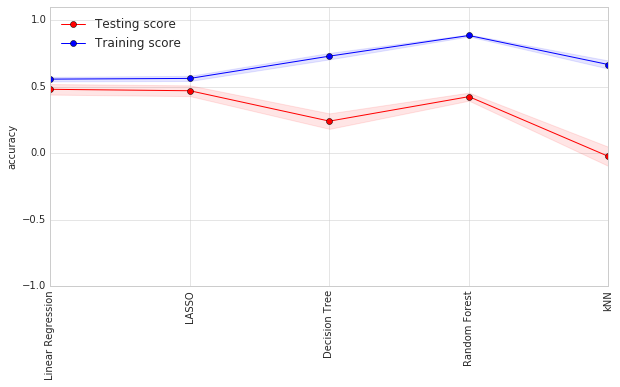

In [389]:
arr=[0.48172996729916057, 0.55841407298185, 0.4710130894108274, 0.5638361688482233, 0.2422737382153893, 
 0.7314884247969229, 0.4265978025991828, 0.8868594489657079, -0.023266510484565784, 0.6680588940371407, 
 0.01987917882436733, 0.008381563191608248, 0.020217901456567926, 0.009684537472351653, 0.029201149677571384, 
 0.01210914178570208, 0.015179690279928677, 0.0036858405847051265, 0.036115513670721834, 0.015276824816646054]

plt.plot([arr[0],arr[2],arr[4],arr[6], arr[8]],"o-",color='r', label="Testing score")
plt.plot([arr[1],arr[3],arr[5],arr[7], arr[9]],"o-",color='b', label="Training score")
plt.fill_between(np.arange(5), np.array([arr[0],arr[2],arr[4],arr[6],arr[8]]) - 2*np.array([arr[10],arr[12],arr[14],arr[16],arr[18]]), 
                                             np.array([arr[0],arr[2],arr[4],arr[6],arr[8]]) + 2*np.array([arr[10],arr[12],arr[14],arr[16],arr[18]]), alpha=0.1, color="r")
plt.fill_between(np.arange(5), np.array([arr[1],arr[3],arr[5],arr[7],arr[9]]) - 2*np.array([arr[11],arr[13],arr[15],arr[17],arr[19]]),\
                     np.array([arr[1],arr[3],arr[5],arr[7],arr[9]]) + 2*np.array([arr[11],arr[13],arr[15],arr[17],arr[19]]), alpha=0.1, \
                     color="b")
plt.xticks([0,1,2,3,4],['Linear Regression', 'LASSO', 'Decision Tree', 'Random Forest','kNN'], rotation=90)
plt.ylim([-1, 1.1])
plt.ylabel('accuracy')
plt.legend(loc="best")


As we can observe, the low testing accuracy for decision tree coupled with the relatively high training accuracy (around 75%) reveals a high level of overfitting. LASSO and random forest are better able to reduce the gap between training and testing accuracies. These results demonstrate that depending on the model we choose, there may be a compromise between having a high accuracy training accuracy/very low testing accuracy, or less overfitting but low testing and training accuracies. 

Another important aspect to point out is the fact that results seem to be consistent throughout the several folds of the cross validation, as we can see a thin confidence interval, especially for the training accuracies.  For all plots shown on accuracies, the 95% confidence intervals will be shown. 

We can observe the bias and variance relationships and compare it with the results shown above 

In [390]:
clf_arr=[linear_model.Lasso(alpha=0), linear_model.Lasso(alpha=0.1), tree.DecisionTreeRegressor(min_samples_leaf=5),
        RandomForestRegressor(max_depth=20, random_state=0, n_estimators=10), KNeighborsRegressor(n_neighbors=2)];
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
#cv=10
#var_vals =[]; var_vals_test =[]
#bias_vals = []; bias_vals_test = []
#error_vals =[]; error_vals_test =[]
#for clf in clf_arr:
#    reg = clf
#    avg_y = np.zeros(len(y_train)); avg_y_test = np.zeros(len(y_test))
#    variance = 0
#    variance_test=0
#    for i in range(cv): 
#        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
#        reg.fit(X_train,y_train)
#        p_y=reg.predict(X_train)
#        t_y=reg.predict(X_test)
#        avg_y = avg_y + p_y
#        avg_y_test=avg_y_test+t_y
#        variance += norm(avg_y - p_y)
#        variance_test+=norm(avg_y_test - t_y)
#    avg_y = avg_y / cv
#    avg_y_test=avg_y_test/cv
#    bias_2 = norm(avg_y - y_train)/len(y_train)
#    bias_test=norm(avg_y_test - y_test)/len(y_test)
#    bias_vals.append(bias_2); bias_vals_test.append(bias_test)
#    variance /= len(y_train) * cv
#    variance_test /= len(y_test) * cv
#    var_vals.append(variance); var_vals_test.append(variance_test)
#    error_vals.append(variance + bias_2)
#    error_vals_test.append(variance_test + bias_test)


In [391]:
#print(bias_vals); print(bias_vals_test); 
#print(var_vals); print(var_vals_test); 

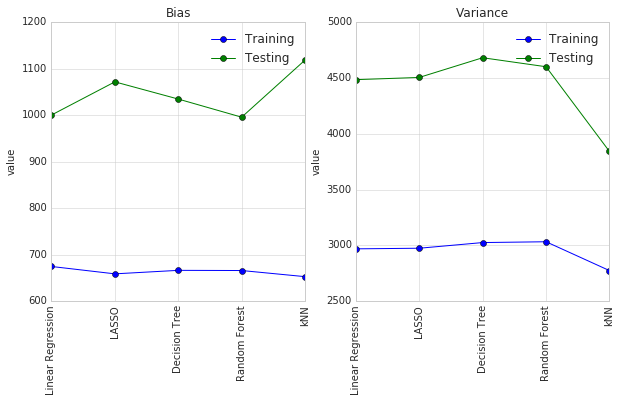

In [392]:
bias_vals=[674.6304059554157, 658.7632497977582, 666.2863803201957, 665.905564642098, 652.7292740199896]
bias_vals_test=[1000.2941769351305, 1071.6417098794911, 1034.6603732829512, 995.6830364159115, 1118.6384016582886]
var_vals=[2968.9204020737902, 2974.3586481431057, 3025.168265281948, 3032.4662550322896, 2774.148967625392]
var_vals_test=[4484.913849612362, 4504.81017907882, 4681.386640008378, 4600.715793159452, 3841.62017380914]
plt.subplot(1,2,1)
plt.plot(np.arange(len(clf_arr)), bias_vals,"o-", label='Training')
plt.plot(np.arange(len(clf_arr)), bias_vals_test,"o-", label='Testing')
plt.ylabel('value'); plt.xticks([0,1,2,3,4],['Linear Regression', 'LASSO', 'Decision Tree',
                                             'Random Forest','kNN'], rotation=90); 
plt.title('Bias')
plt.legend()
#plt.show()

plt.subplot(1,2,2)
plt.plot(np.arange(len(clf_arr)), var_vals,"o-", label='Training')
plt.plot(np.arange(len(clf_arr)), var_vals_test,"o-", label='Testing')
plt.ylabel('value'); plt.xticks([0,1,2,3,4],['Linear Regression', 'LASSO', 'Decision Tree',
                                             'Random Forest','kNN'], rotation=90);
plt.title('Variance')
plt.legend()
plt.show()

We can observe that the bias for the training set is nearly constant for distinct models, with an observable increase for LASSO and kNN for the testing set. The variances are all larger than the bias, which indicates overfit. An increase in variance (under nearly constant bias across different algorithms) is characterized by larger overfit between training and testing accuracies.

Let's look at LASSO hyperparameter tuning using all features available in the dataset:

In [393]:
#test_arr,train_arr,test_std, train_std=ML_reg_lasso (X,Y,1)
#print(test_arr)
#print(train_arr)
#print(test_std)
#print(train_std)

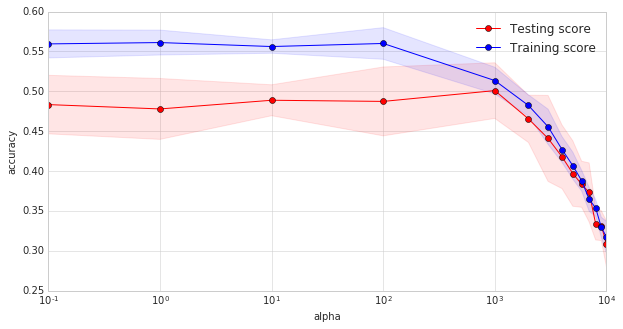

In [394]:
### results from LASSO hyperparameter tuning:
#the following arrays were printed from the above commented lines 
test_arr=[0.5005014687578724, 0.4832122057010452, 0.4777681631473256, 0.48866114142338335, 0.4872084628545812, 
 0.5007751026792694, 0.4653420918770695, 0.44076931086281784, 0.4176998211691897, 0.39670376334369656, 
 0.38326045595336555, 0.3729440373560634, 0.3337400420111611, 0.3313316967524278, 0.3083911078317528]
train_arr=[0.5506474372578621, 0.5593546124635383, 0.5610383475521137, 0.556049860298318, 0.5599050883750072, 
 0.5133576263850637, 0.4821281105304619, 0.4553739304458505, 0.42688000160053396, 0.4065576843275447, 
 0.3876722116744919, 0.36431392388819345, 0.3536104866140183, 0.32923346883628224, 0.3170016522095058]
test_std=[0.0200245322033037, 0.018354861858505173, 0.019097967468356097, 0.00971189610184234, 0.021596835299705696, 
 0.01746100362206419, 0.014825690584677026, 0.026968674821654014, 0.019949027140424073, 0.02051405814699665, 
 0.014454662315896361, 0.018538741805392656, 0.010175855818072534, 0.009363281994323335, 0.014474955837853201]
train_std=[0.008615011778139928, 0.008794178495490749, 0.007816311325370067, 0.004213031333883805, 0.009925271462025204, 
 0.008362773725034573, 0.006690038198850503, 0.01104169404994934, 0.008115289907331897, 0.008481075410272937, 
 0.006509997482874826, 0.007467182950453009, 0.005346469477918756, 0.006301464426201096, 0.009967943236624366]
alpha_val=[0, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000];
#plot results from cross-validated results for easier visualization
plot_cv_tunning(test_arr,train_arr,test_std,train_std,'alpha',alpha_val,1)

It is interesting to observe the extremely large confidence intervals for both training and testing accuracies. This indicates a high level of uncertainity in defining the accuracies using the LASSO trained algorithm.

We can employ LASSO to establish the importance of different features, which is shown below:

In [395]:
feature_importance=pd.Series()
#10-fold cross validation for lasso/feature selection
for i in range(10):
    clf= linear_model.Lasso(alpha=1000)
    clf, test_acc, train_acc=simple_score(clf,X,Y)
    feature_importance=pd.concat([feature_importance,pd.Series(list(clf.coef_ ))],axis=1)
feature_importance=feature_importance.div(10)
feature_importance=list(feature_importance.sum(axis=1))
pd_feature_importance=pd.DataFrame({'feature_importance':feature_importance, 'features':(list(data_temp.iloc[:,:data_temp.shape[1]-1]))})
                                    #(list(data_temp.iloc[:,:data_temp.shape[1]-1]))
#pd_feature_importance=pd_feature_importance[pd_feature_importance['feature_importance']>1e-5]
print('Number of features above threshold is '+str(len(pd_feature_importance)))
pd_feature_importance.nlargest(10, ['feature_importance']) 
#feature_importance=list(feature_importance)

Number of features above threshold is 495


feature_importance                          features
77        21448.854425  country_United States of America
1          8922.186663                           avg age
2          5566.661158                   role_experience
3          5050.679332                  ML_incorporation
99         4501.653778               title_Chief Officer
71         3828.116598               country_Switzerland
6          3563.474029                          ML_years
22         3481.961880                 country_Australia
28         3424.422700                    country_Canada
5          3219.933970                      years_coding

According to these results, the main factors that determine salaries are whether an individual resides in the US, and their age. Other variables such as years of coding experience, incorporation of ML algorithms into the workplace, among others display some importance as well. These results are however limited given the low accuracy obtained using regularized linear regression.


Principal component analysis (PCA) is also evaluated using all features:

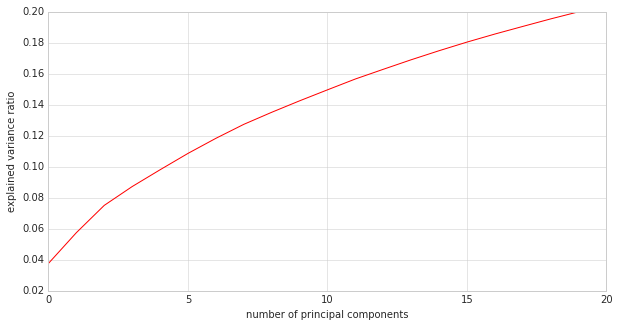

In [396]:
pca_arr=pca_test(X)
plt.plot(np.arange(len(pca_arr)),pca_arr,color='r')
plt.ylabel('explained variance ratio')
plt.xlabel('number of principal components')

#### Training and testing ML algorithms using feature select subsets:
As shown in previously in section 2, different feature selection methods have been used to pick the variables that are more likely to have an influence in determining salary. The performance of each using the four ML algorithms will be shown as follows:



Firstly, the features deemed to be the most relevant will be used for training and testing:

Number of points considered is 14122


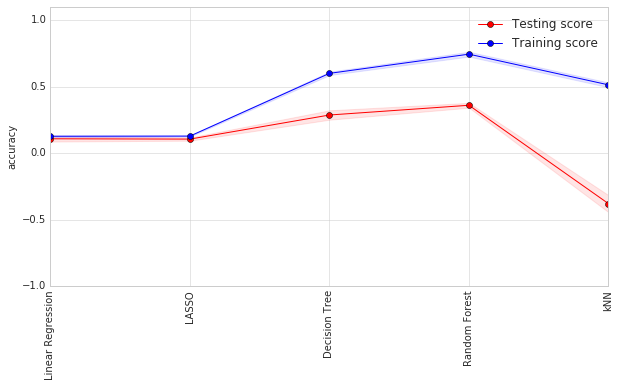

In [397]:
X_rf=data_rel_feat.iloc[:,:data_rel_feat.shape[1]-1].values
Y_rf=data['Q9'].values
X_rf=StandardScaler().fit_transform(X_rf)
print('Number of points considered is '+str(len(X_rf)))
arr=ML_train_test_cv (X_rf,Y_rf)

As we can observe using only the relevant features subset (rf), the accuracy of linear regression and LASSO has become considerably worse, indicating that possible features that have a heavy impact on salary may be missing from the model. Only tree-based methods appear to demonstrate higher level of training accuracies (R^2>0.5)

Let's look at those features chosen using standard feature selection methods, namely low variance (lv), and univariate (uv):

In [398]:
#X_lv=variance_data
#Y_lv=data_temp['Q9'].values
#X_lv=StandardScaler().fit_transform(X_lv)
#print('Number of points considered is '+str(len(X_lv)))
#arr=ML_train_test_cv (X_lv,Y_lv)
#print(arr)

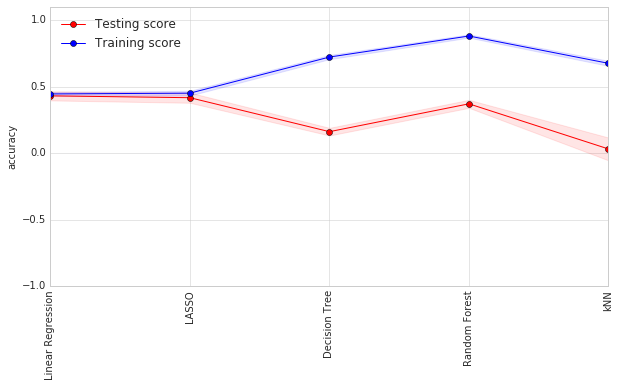

In [399]:
#output from above code and plotting:
#Number of points considered is 10756
arr=[0.43261476198193805, 0.44698331053391566, 0.41860417715524445, 0.4528885790503738, 0.16294705120172154,
     0.724531254314954, 0.37253558879341686, 0.8830271201870739, 0.03291969828589679, 0.6774774040085023, 
     0.01719512938646559, 0.007099164092947145, 0.01910011280991663, 0.008963637450522909, 0.014370614615038291, 
     0.00795317142933661, 0.015054387643784863, 0.006127202299644937, 0.04294226725273514, 0.009567534792248799]

plt.plot([arr[0],arr[2],arr[4],arr[6], arr[8]],"o-",color='r', label="Testing score")
plt.plot([arr[1],arr[3],arr[5],arr[7], arr[9]],"o-",color='b', label="Training score")
plt.fill_between(np.arange(5), np.array([arr[0],arr[2],arr[4],arr[6],arr[8]]) - 2*np.array([arr[10],arr[12],arr[14],arr[16],arr[18]]), 
                                             np.array([arr[0],arr[2],arr[4],arr[6],arr[8]]) + 2*np.array([arr[10],arr[12],arr[14],arr[16],arr[18]]), alpha=0.1, color="r")
plt.fill_between(np.arange(5), np.array([arr[1],arr[3],arr[5],arr[7],arr[9]]) - 2*np.array([arr[11],arr[13],arr[15],arr[17],arr[19]]),\
                     np.array([arr[1],arr[3],arr[5],arr[7],arr[9]]) + 2*np.array([arr[11],arr[13],arr[15],arr[17],arr[19]]), alpha=0.1, \
                     color="b")
plt.xticks([0,1,2,3,4],['Linear Regression', 'LASSO', 'Decision Tree', 'Random Forest','kNN'], rotation=90)
plt.ylim([-1, 1.1])
plt.ylabel('accuracy')
plt.legend(loc="best")

Number of points considered is 10756
[0.4236094219019946, 0.4336242477802655, 0.434571383062406, 0.42852909576980813, 0.3306558125745608, 0.6085561791659811, 0.33417986848346015, 0.8615452987405033, 0.2547305305132633, 0.743681324073231, 0.016876272946952608, 0.007863458271001844, 0.02076272203235169, 0.00900255153554776, 0.02616298437114246, 0.007164757742170893, 0.023783163070220006, 0.0032994541180258966, 0.03522727178515898, 0.005925735989608859]


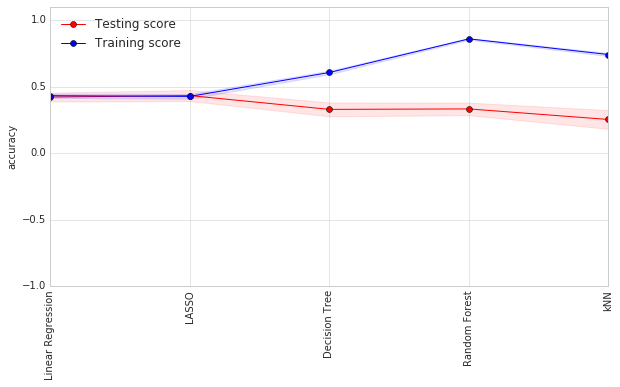

In [400]:
X_uv=univariate_data
Y_uv=data_temp['Q9'].values
X_uv=StandardScaler().fit_transform(X_uv)
print('Number of points considered is '+str(len(X_uv)))
arr=ML_train_test_cv (X_uv,Y_uv)
print(arr)

The accuracies otained using high variance features (lv subset) and univariate (uv subset) show remarkable performance when compared to the accuracy obtained using all available features. Even though accuracies are all small for the testing set (generally <50%), and the training score increases considerably for the tree based methods, it is quite interesting to see that using only 10 features can achieve results comparable to using more than 400. 

With regards to overfitting, we can observe that the univariate feature selection helps preventing overfitting for decision trees, and for k-NN by a slight extent. This appears to be an advantage of using a model with fewer features. We can also observe that there the variation of accuracy across the folds is very small, demonstrating that the model consistently gives a very similar accuracy overall.

For the sake of simplicity and speed, features chosen using the Univariate featurea selection will be used henceforth.

Let's look at the variance and bias relationship using the same subset of features (uv):

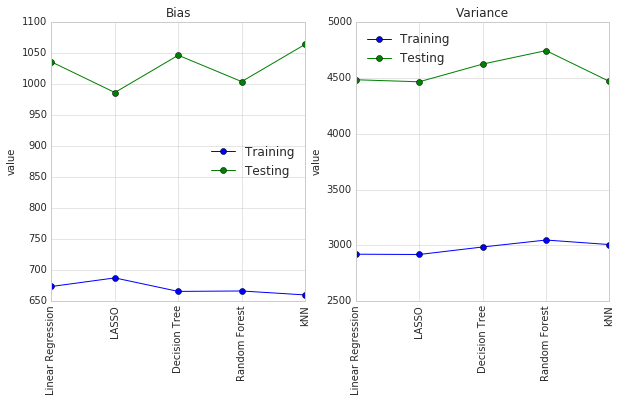

In [401]:
#code based on https://gist.github.com/fabgoos/6788818:
clf_arr=[linear_model.Lasso(alpha=0), linear_model.Lasso(alpha=0.1), tree.DecisionTreeRegressor(min_samples_leaf=5),
        RandomForestRegressor(max_depth=20, random_state=0, n_estimators=10), KNeighborsRegressor(n_neighbors=2)];
X_train, X_test, y_train, y_test = train_test_split(X_uv, Y_uv, test_size=0.30)
cv=10
var_vals =[]; var_vals_test =[]
bias_vals = []; bias_vals_test = []
error_vals =[]; error_vals_test =[]
for clf in clf_arr:
    reg = clf
    avg_y = np.zeros(len(y_train)); avg_y_test = np.zeros(len(y_test))
    variance = 0
    variance_test=0
    for i in range(cv): 
        X_train, X_test, y_train, y_test = train_test_split(X_uv, Y_uv, test_size=0.30)
        reg.fit(X_train,y_train)
        p_y=reg.predict(X_train)
        t_y=reg.predict(X_test)
        avg_y = avg_y + p_y
        avg_y_test=avg_y_test+t_y
        variance += norm(avg_y - p_y)
        variance_test+=norm(avg_y_test - t_y)
    avg_y = avg_y / cv
    avg_y_test=avg_y_test/cv
    bias_2 = norm(avg_y - y_train)/len(y_train)
    bias_test=norm(avg_y_test - y_test)/len(y_test)
    bias_vals.append(bias_2); bias_vals_test.append(bias_test)
    variance /= len(y_train) * cv
    variance_test /= len(y_test) * cv
    var_vals.append(variance); var_vals_test.append(variance_test)
    error_vals.append(variance + bias_2)
    error_vals_test.append(variance_test + bias_test)


plt.subplot(1,2,1)
plt.plot(np.arange(len(clf_arr)), bias_vals,"o-", label='Training')
plt.plot(np.arange(len(clf_arr)), bias_vals_test,"o-", label='Testing')
plt.ylabel('value'); plt.xticks([0,1,2,3,4],['Linear Regression', 'LASSO', 'Decision Tree',
                                             'Random Forest','kNN'], rotation=90); 
plt.title('Bias')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(np.arange(len(clf_arr)), var_vals,"o-", label='Training')
plt.plot(np.arange(len(clf_arr)), var_vals_test,"o-", label='Testing')
plt.ylabel('value'); plt.xticks([0,1,2,3,4],['Linear Regression', 'LASSO', 'Decision Tree',
                                             'Random Forest','kNN'], rotation=90);
plt.title('Variance')
plt.legend(loc="best")
plt.show()

Contrary to evaluating all features, when we use the univariate-selected features, the variance for random forest is larger than that for decision tree. This implies that using fewer features may lead to increased overfiting for random forest, which is a sacrifice in favor of simplicity and computational speed 

#### Implementing additional feature engineering
In order to enhance accuracy, additional feature engineering 
is implemented by creating new features, which are simply the products of numerical features. This is a way of taking into account the interaction between parameters as parameters themselves. 3-way interactions were also attempted, but they led to no observable improvement 

In [402]:
def features_for_ML(relevant_features,data):
    features=pd.DataFrame()
    for feature in relevant_features:
        features=pd.concat([features, 
                            pd.get_dummies(data[feature], 
                                           prefix=feature)],axis=1)
    return features
    
    
def features_int(data,features_to_comb):
    comb = combinations(features_to_comb, 2) 
    features=pd.DataFrame()
    #commbine features:
    df=pd.DataFrame()
    for f1, f2 in comb:
        #f1_data=data[f1]
        df[str(f1+f2)] = data[f1]*data[f2]
        features=pd.concat([features, df[str(f1+f2)] ],axis=1)
    
    features=features.loc[:, (features != 0).any(axis=0)]
    #feature_list=list(features)
    #comb_features=features_for_ML(feature_list,features)
    comb_features=features
    return comb_features      


def features_3int(data,features_to_comb):
    comb = combinations(features_to_comb, 3) 
    features=pd.DataFrame()
    #commbine features:
    df=pd.DataFrame()
    for f1, f2, f3 in comb:
        #f1_data=data[f1]
        df[str(f1+f2+f3)] = data[f1]*data[f2]*data[f3]
        features=pd.concat([features, df[str(f1+f2+f3)] ],axis=1)
    
    features=features.loc[:, (features != 0).any(axis=0)]
    #feature_list=list(features)
    #comb_features=features_for_ML(feature_list,features)
    comb_features=features
    return comb_features      
                            
    
    

In [403]:
X_uv=pd.DataFrame(data=univariate_data, columns=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15'])
comb_features=features_int(X_uv,['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15'])
#comb3_features=features_3int(X_uv,['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'])
#drop combinations that are very uncommon and only add columns that slow down code:
droplist = [i for i in list(comb_features) if comb_features[i].sum()<=2000]
comb_features.drop(droplist,axis=1,inplace=True)
X_uv=pd.concat([X_uv, comb_features],axis=1)
univariate_data_feat_eng=X_uv.copy()
X_uv.shape


(10756, 74)

Number of points considered is 10756


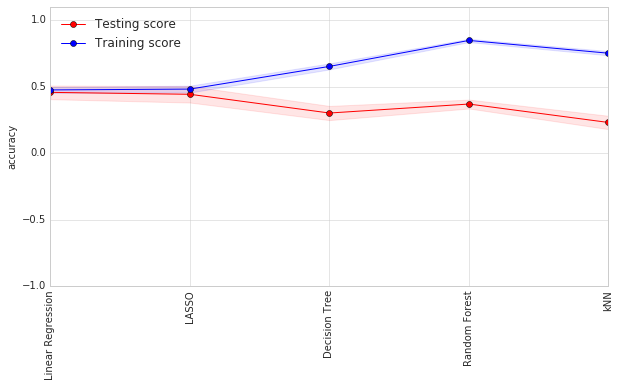

In [404]:
X_uv=StandardScaler().fit_transform(X_uv)
print('Number of points considered is '+str(len(X_uv)))
arr=ML_train_test_cv (X_uv,Y_uv)

Given the results shown above, we can further explore the regressions by looking at the scatter plots for target versus predicted values for the training samples, and their corresponding residual plots:

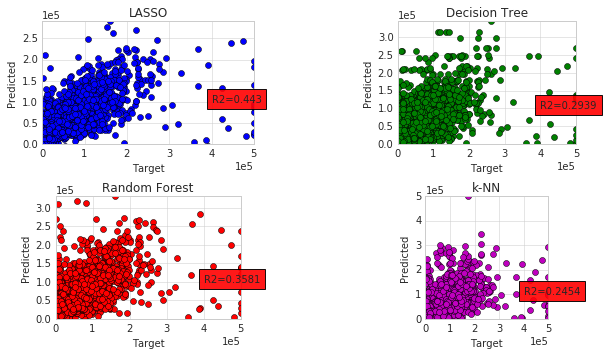

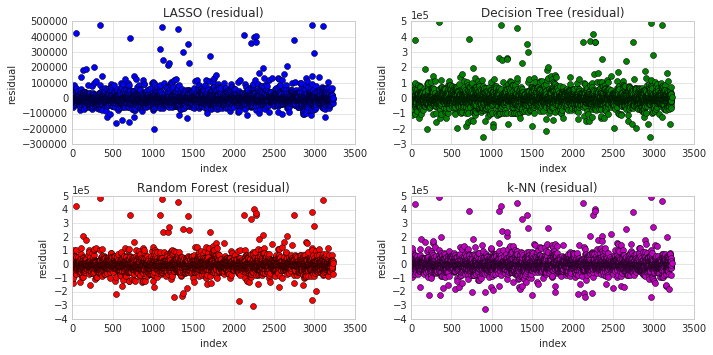

In [405]:
plot_scatter(X_uv,Y_uv)

Even though accuracies appear low, ss we can observe, LASSO and random forest perform slightly better in terms of testing accuracy. We can observe that some models miss the very high salaries around $500,000, and sometimes under or over estimate them. In adddition, the residual plots do not demonstrate a peculiar trend and appear to be somewhat normally distributed.

In what follows, a discussion of the results involving training and testing of the features deemed to be more closely correlated (as shown in exploratory data/feature selection section) with salary will be shown. 

### 6. Optimizing models
#### Hyperparameter tuning for LASSO

We can modify the power of regularization to evaluate its effect on the trade-off between training and testing accuracies:


In [406]:
### code for LASSO hyperparameter tuning: 
#test_arr,train_arr,std_test_arr,std_train_arr=ML_reg_lasso (X_uv,Y_uv,1)
#print(test_arr)
#print(train_arr)
#print(std_test_arr)
#print(std_train_arr)

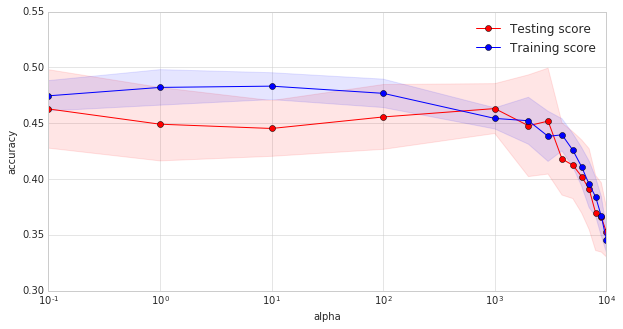

In [407]:
alpha_val=[0, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000];
#the following arrays were printed from the above commented lines 
test_arr=[0.46259697880177, 0.46270273302744264, 0.4490169126348958, 0.4451821355692146, 0.4555120956602788, 
          0.4630205946214473, 0.44763620860703285, 0.45177697667029537, 0.4178042446801963, 0.4123014042550374, 
          0.40214548955119095, 0.39080598888002915, 0.369391744979661, 0.36549502438286796, 0.35233401125258296]
train_arr=[0.47503924568376055, 0.4744439956552779, 0.4819817019316085, 0.4831088072138366, 0.47666670433577407,
           0.45419984031158844, 0.4521011572844581, 0.4381401259098783, 0.43949858977660694, 0.4257287332948255,
           0.41072777975983915, 0.3950552937013139, 0.38391434290228144, 0.3664826002112617, 0.34514217099792216]
std_test_arr=[0.020362933198789117, 0.017570206880440097, 0.01644454287488855, 0.012481817148641676, 0.014524412838378065, 
              0.011175209349103604, 0.022785679375322308, 0.023725089982515483, 0.016157990872824705, 0.014981817447494775,
              0.016393721440959404, 0.01812343945687644, 0.01680767366263176, 0.01553983803187741, 0.011138289927651117]
std_train_arr=[0.008936002675406155, 0.006810700663472155, 0.007961050481660834, 0.006020308755662176, 0.006363632284439516, 
               0.004725541850852767, 0.010512550820917722, 0.011236313144497155, 0.0072080299861984175, 0.007441955708583832,
               0.008671599885767886, 0.010440943425925463, 0.00869152605509532, 0.00888522913453696, 0.00547879079794895]
#plot results from cross-validated results for easier visualization
plot_cv_tunning(test_arr,train_arr,std_test_arr,std_train_arr,'alpha',alpha_val,1)

From the above result, we can see that as alpha increases beyond 10^3, there tends to be a substantial reduction in the accuracy metrics. A value of alpha such as 10^-1 or 10^3 appear to be a proper compromise between overall accuracy and reduction in overfit.

Let's evaluate the relationships between bias and variance for LASSO as the hyperparameter alpha changes


In [408]:
alpha_val=[0, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000];
#X_train, X_test, y_train, y_test = train_test_split(X_uv, Y_uv, test_size=0.30)
#cv=10
#var_vals =[]; var_vals_test =[]
#bias_vals = []; bias_vals_test = []
#error_vals =[]; error_vals_test =[]
#for alpha in alpha_val:
#    reg = linear_model.Lasso(alpha=alpha)
#    avg_y = np.zeros(len(y_train)); avg_y_test = np.zeros(len(y_test))
#    variance = 0
#    variance_test=0
#    for i in range(cv): 
#        X_train, X_test, y_train, y_test = train_test_split(X_uv, Y_uv, test_size=0.30)
#        clf.fit(X_train,y_train)
#        p_y=clf.predict(X_train)
#        t_y=clf.predict(X_test)
#        avg_y = avg_y + p_y
#        avg_y_test=avg_y_test+t_y
#        variance += norm(avg_y - p_y)
#        variance_test+=norm(avg_y_test - t_y)
#    avg_y = avg_y / cv
#    avg_y_test=avg_y_test/cv
#    bias_2 = norm(avg_y - y_train)/len(y_train)
#    bias_test=norm(avg_y_test - y_test)/len(y_test)
#    bias_vals.append(bias_2); bias_vals_test.append(bias_test)
#    variance /= len(y_train) * cv
#    variance_test /= len(y_test) * cv
#    var_vals.append(variance); var_vals_test.append(variance_test)
#    error_vals.append(variance + bias_2)
#    error_vals_test.append(variance_test + bias_test)
#print(bias_vals); print(bias_vals_test); 
#print(var_vals); print(var_vals_test); 

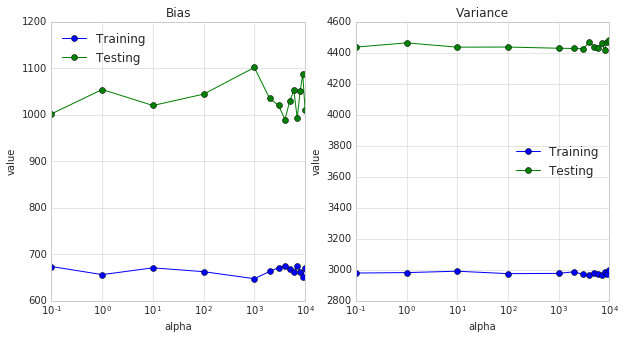

In [409]:
alpha_val=[0, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000];
### results from commented code above:
bias_vals=[667.6317102710526, 673.0983560392931, 655.6576922231687, 670.2346859219831, 661.9553079510273, 646.9080704278362,
 662.4154562442047, 670.5883276558571, 674.4305658630442, 668.5738762110598, 662.2829879171809, 674.4583428130844,
 662.1158037375967, 651.1906968093865, 670.7380580381796]
bias_vals_test=[1032.923848989183, 1001.3893074715095, 1053.7404296968753, 1019.3597538581704, 1043.8131427948597, 
 1101.1661378107883, 1034.4222643156806, 1019.8036497459567, 989.1174028307431, 1029.013620719824, 
 1052.2178189105728, 992.0419234403788, 1050.4270376222446, 1087.1340106582675, 1009.4132157970649]
var_vals=[2983.222964068736, 2977.2219567394527, 2980.0187994833286, 2988.978690952063, 2973.182177927119, 
 2974.970527792657, 2985.2972320460226, 2968.7511152667353, 2965.7374475323227, 2978.1730784101837, 
 2974.069671604967, 2961.9157176882213, 2981.391111343288, 2969.289542167873, 2994.67036303682]
var_vals_test=[4497.85404437788, 4434.780691000692, 4461.99761555599, 4434.470003139189, 4435.181674774601, 
 4427.499443601826, 4425.870444717567, 4423.963285627748, 4466.358262620615, 4438.03555872415, 
 4430.123449280157, 4461.184229970806, 4418.284387263209, 4468.56752037861, 4479.427469825172]
plt.subplot(1,2,1)
plt.plot(alpha_val, bias_vals,"o-", label='Training')
plt.plot(alpha_val, bias_vals_test,"o-", label='Testing')
plt.ylabel('value'); plt.xlabel('alpha');  plt.xscale('log')
plt.title('Bias')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(alpha_val, var_vals,"o-", label='Training')
plt.plot(alpha_val, var_vals_test,"o-", label='Testing')
plt.ylabel('value'); plt.xlabel('alpha');  plt.xscale('log')
plt.title('Variance')
plt.legend(loc="best")
plt.show()

We can look at feature importance for LASSO again using the same set of features

In [410]:
feature_importance=pd.Series()
for i in range(10):
    clf= linear_model.Lasso(alpha=0.1)
    clf, test_acc, train_acc=simple_score(clf,X_uv,Y_uv)
    feature_importance=pd.concat([feature_importance,pd.Series(list(clf.coef_ ))],axis=1)
feature_importance=feature_importance.div(10)
feature_importance=list(feature_importance.sum(axis=1))
#feature_importance=list(feature_importance)

In [411]:
pd_feature_importance=pd.DataFrame({'feature_importance':feature_importance, 'features':(list(univariate_data_feat_eng))})
                                    #(list(data_temp.iloc[:,:data_temp.shape[1]-1]))
pd_feature_importance=pd_feature_importance[pd_feature_importance['feature_importance']>1e-5]
print('Number of features above threshold is '+str(len(pd_feature_importance)))
pd_feature_importance.nlargest(10, ['feature_importance']) 

Number of features above threshold is 41


feature_importance features
3         23249.081208       x4
1         11433.461752       x2
0         11039.287650       x1
16         8636.472525     x1x3
10         8475.773871      x11
23         7132.281013    x1x10
6          7029.837955       x7
45         6751.874378     x3x7
5          6219.468762       x6
20         5255.022115     x1x7

#### K-NN hyperparameter tuning:

In [412]:
#test_arr,train_arr,std_test_arr,std_train_arr=kNN_reg (X_uv,Y_uv)
#print(test_arr)
#print(train_arr)
#print(std_test_arr)
#print(std_train_arr)


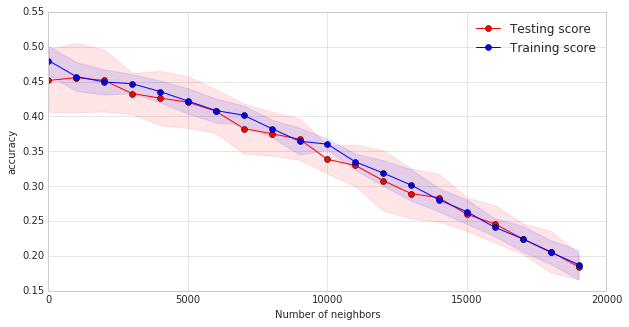

In [413]:
#the following arrays were printed from the above commented lines on k-NN using the cross-validation 
#hyperparameter tuning
test_arr=[0.4515553092816124, 0.4555924544121086, 0.4515469663513575, 0.4328289030588738, 0.42631327733878743, 
          0.4204588404679475, 0.4075532865388853, 0.38264733576947135, 0.37524452420580984, 0.3673829549042379,
          0.3384778431013787, 0.3297647219214229, 0.3080150800177307, 0.28939851165645913, 0.28352444920664877,
          0.25969199397477916, 0.24586912948152345, 0.22448256561613156, 0.2061021977093846, 0.18447992916403302]
train_arr=[0.4801382633668599, 0.4571188099377686, 0.44945890345358397, 0.44687685272966393, 0.43572538572404323, 
           0.4220463645323761, 0.40842482795182117, 0.40169157066162675, 0.3826419266273673, 0.3645245562719739, 
           0.3601953622188418, 0.334908846462397, 0.31876765867591794, 0.30162079966933525, 0.28037726077362785, 
           0.2633029316872336, 0.2410135441497067, 0.22449692571280747, 0.2053438518603503, 0.18757118264522568]
std_test_arr=[0.02257831683967419, 0.0248920887431442, 0.022234439994282738, 0.014712350278682102, 0.019446340755006317, 
              0.018508171059825176, 0.01558703174311432, 0.017871551559108738, 0.01571729120424249, 0.014718921357034884, 
              0.010114181156260496, 0.01502042572569327, 0.021531195239300516, 0.01801931783183049, 0.017008355291914173, 
              0.011949637110407495, 0.013351693999792247, 0.011009785798995735, 0.014877238376279299, 0.00912619344823874]
std_train_arr=[0.010422233967007383, 0.010408983497101124, 0.009038043969078063, 0.006829392649899109, 0.007834818766934381,
               0.009117752723986326, 0.008545450080672564, 0.006893758118867942, 0.006429598463480874, 0.009615329134837841,
               0.003958291118486775, 0.005852027763962196, 0.009181655855039876, 0.011227541555300147, 0.008374367142081443,
               0.008740001237425072, 0.006484957817316799, 0.009285873691302782, 0.008543635397458855, 0.010607663514765579]
#plot results from cross-validated results for easier visualization
plot_cv_tunning(test_arr,train_arr,std_test_arr,std_train_arr,'Number of neighbors',np.arange(20)*1000,0)

a total of 1000 neighbors appears to be a proper tradeoff between testing and training accuracies

### Decision tree hyperparameter tuning

Let's analyze how decision trees can be tuned in order to achieve the best compromise between training and testing accuracies. This will be achieved by changing the hyperparameter 'minimum samples per leaves'. After tuning, we will verify the results by looking at a bias-variance plot

In [414]:
#test_arr,train_arr,std_test_arr,std_train_arr=ML_tree (X_uv,Y_uv)
#print(test_arr)
#print(train_arr)
#print(std_test_arr)
#print(std_train_arr)

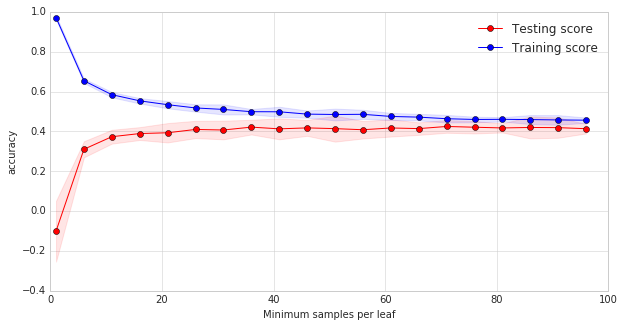

In [415]:
test_arr=[-0.10079985974943347, 0.3102562564215386, 0.37323152320580544, 0.38901547461952424, 0.39301166478325555, 
 0.4096762542044, 0.406909662625422, 0.4213304616385587, 0.41267627132517654, 0.4174854163055314, 
 0.4137155063898347, 0.40820276401140826, 0.41709388934695946, 0.41384952824811655, 0.42464555605546084, 
 0.4208004974274676, 0.4172043444060726, 0.4196018188903694, 0.41873654189734016, 0.41340656102824214]
train_arr=[0.9713120365639666, 0.6539717124743001, 0.5841448915040746, 0.5532461072352227, 0.5339387365797609, 0.5175528654366842,
 0.5100573152213801, 0.4987383764633647, 0.4983384801149275, 0.48657838092630945, 0.48467272185148547, 
 0.48561564785831435, 0.474938154837999, 0.4714735699095304, 0.46352392369115225, 0.459745831423804, 
 0.4604299121406619, 0.4592533679234836, 0.45736688350819055, 0.4561737376665328]
std_test_arr=[0.07626103345071313, 0.020171757428747803, 0.017354140157598872, 0.016139917999280332, 0.024265917016866787, 
 0.021676835259971848, 0.023398199443043464, 0.018440573563604803, 0.02625703736962479, 0.01995466313233393, 
 0.032595463478041924, 0.021925249128182556, 0.0215383264896323, 0.015704536789011247, 0.01582631559477634, 
 0.015590054305456152, 0.01136503538023445, 0.02753711333550566, 0.025335843341521776, 0.011853019197100191]
std_train_arr=[0.004709598069808924, 0.005415475227782927, 0.006656936654035394, 0.00672770356643771, 0.00907820051532784, 
 0.009128577323986172, 0.012618339585433916, 0.0067083395803961745, 0.012592701494551132, 0.00903911596513777, 
 0.014765655360832908, 0.011365655774491223, 0.008832832379758534, 0.00818130501638921, 0.009520065588150523, 
 0.006921751281018032, 0.005461570564326919, 0.011329360370932686, 0.012075410122699397, 0.006613447834782033]
#plot results from cross-validated results for easier visualization
plot_cv_tunning(test_arr,train_arr,std_test_arr,std_train_arr,'Minimum samples per leaf',np.arange(20)*5+1,0)

We can observe that for decision tree, the accuracies of the training set and testing sets tend to plateau after 40 minimum samples per leaf.  

Let's evaluate the importance of features using the algorithm above:

In [416]:
feature_importance=pd.Series()
for i in range(10):
    clf= tree.DecisionTreeRegressor(min_samples_leaf=40)
    clf, test_acc, train_acc=simple_score(clf,X_uv,Y_uv)
    feature_importance=pd.concat([feature_importance,pd.Series(list(clf.feature_importances_))],axis=1)
feature_importance=feature_importance.div(10)
feature_importance=list(feature_importance.sum(axis=1))

In [417]:
pd_feature_importance=pd.DataFrame({'feature_importance':feature_importance, 'features':(list(univariate_data_feat_eng))})
                                    #(list(data_temp.iloc[:,:data_temp.shape[1]-1]))
pd_feature_importance=pd_feature_importance[pd_feature_importance['feature_importance']>1e-5]
print('Number of features above threshold is '+str(len(pd_feature_importance)))
pd_feature_importance.nlargest(10, ['feature_importance']) 

Number of features above threshold is 68


feature_importance features
20            0.474908     x1x7
42            0.106553     x3x4
29            0.076388     x2x3
17            0.060612     x1x4
0             0.031877       x1
34            0.021022     x2x8
45            0.017819     x3x7
7             0.013990       x8
68            0.012000    x5x14
63            0.011974     x5x7

The combination of being in the USA and the incorporation of ML appears to have the most signficant effect on salaries according to decision trees (almost 50%). This demonstrates the importance of feature engineering in describing the interaction between features.

### Hyperparamater tuning for Random Forest

For random forest, several parameters shall be tunned, such as the minimum samples per leaf, minimum samples per split, the number of estimators and the maximum depth of trees. Even though it would be desirable to train all of them using a rigorous grid search algorithm, the timing required and the small return in terms of improved accuracy would likely not merit using this. Some of the hyperparameters will be tuned separately, and results will be later combined. The major shortcoming of this appraoch is that it neglects the nonlinearlity and interaction effects that hyperparameters may have on an algorithm. 

In [418]:
#test_arr,train_arr,std_test_arr,std_train_arr=ML_random_forest_msl (X_uv,Y_uv)
#print(test_arr)
#print(train_arr)
#print(std_test_arr)
#print(std_train_arr)


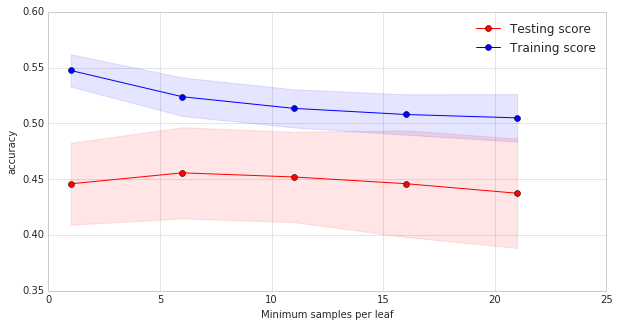

In [419]:
test_arr=[0.4458813369495724, 0.4557006826200351, 0.451994392060139, 0.4460037082803218, 0.4374133525474506]
train_arr=[0.5474330034007819, 0.5238801511737041, 0.5134693898227931, 0.5079877401582915, 0.5049463371025832]
std_test_arr=[0.01836390297233912, 0.020429939320352343, 0.020236511149054445, 0.023900916680622743, 0.024531611076295198]
std_train_arr=[0.007253774644938943, 0.008641050721693303, 0.008564653272858894, 0.009048267853317091, 0.010648259539059587]


plot_cv_tunning(test_arr,train_arr,std_test_arr,std_train_arr,'Minimum samples per leaf',np.arange(5)*5+1,0)

We can observe that with 6 samples per leaf, there appears to be a good compromise between the bias and variance, as there is reduced overfit and a slight reduction in training score.

In [420]:
#test_arr,train_arr,std_test_arr,std_train_arr=ML_random_forest_mss (X_uv,Y_uv)
#print(test_arr)
#print(train_arr)
#print(std_test_arr)
#print(std_train_arr)

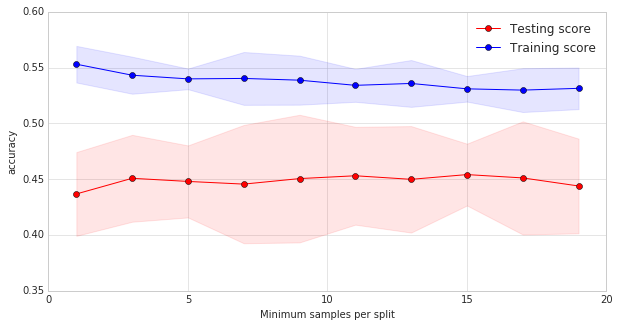

In [421]:
#results from cross-validation
test_arr=[0.43677499146163734, 0.45080981685719046, 0.4480079096718049, 0.4456040714645109, 0.4505438647313123, 0.4530807900505692,
          0.4498831867467342, 0.45413621850279035, 0.45114935054376365, 0.4439267797750402]
train_arr=[0.5530476362772431, 0.5431806769101137, 0.5398999638272318, 0.5402987344056538, 0.5387304133144697, 0.534107313522301,
           0.5357963577608134, 0.530976249693472, 0.5298301154353249, 0.5314212580108864]
std_test_arr=[0.01876463336286928, 0.019462329488871142, 0.016133780186576383, 0.02649847687061913, 0.028589368945447537, 
              0.02191004659421664, 0.023848278560123497, 0.013849398482102157, 0.02534227852721577, 0.021216483397149044]
std_train_arr=[0.008195786380415487, 0.008292939978172752, 0.004632284770613355, 0.011837374742651655, 0.010985268565931771, 
               0.007377891251855958, 0.010492428285785992, 0.005722482522491793, 0.00981486042767452, 0.00930789745883734]

#plot results from cross-validated results for easier visualization
plot_cv_tunning(test_arr,train_arr,std_test_arr,std_train_arr,'Minimum samples per split',np.arange(10)*2+1,0)

Let's evaluate the effects of two parameters at the same time: maximum depth and number of estimators

In [422]:
cv=5;
from mpl_toolkits import mplot3d
depth=np.arange(5)*5+1
estimators=np.arange(5)*100+100
#i=0; j=0;
#test_arr=np.zeros((5,5)); train_arr=np.zeros((5,5))
#for max_depth in depth:
#    j=0;
#    for n_estimators in estimators:
#        test_v=0; train_v=0;
#        reg = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators,)
#        for m in range(cv):
#            reg, TREEREG_test, TREEREG_train=simple_score(reg,X_uv,Y_uv)
#            test_v=test_v+TREEREG_test; train_v=train_v+TREEREG_train;
#        test_arr[i,j]=test_v/cv
#        train_arr[i,j]=train_v/cv
#        j=j+1;
#    i=i+1;

#print(test_arr)
#print(train_arr)

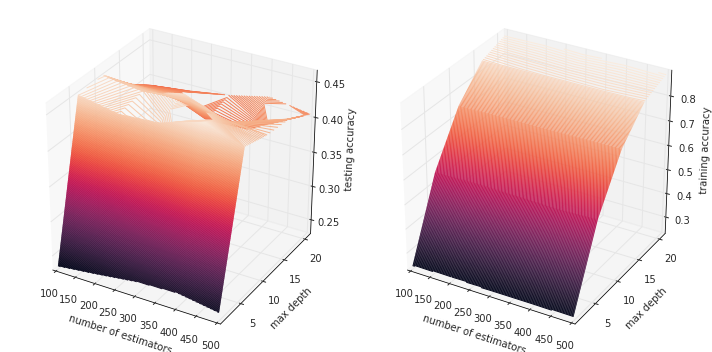

In [423]:
test_arr=[[0.23395221, 0.24048404, 0.24799137, 0.25053241, 0.24117417],
 [0.45057676, 0.43939846, 0.44261615, 0.46138288, 0.44141294],
 [0.45241512, 0.44478667, 0.45576891, 0.43473321, 0.43018745],
 [0.41446318, 0.41720554, 0.39329582, 0.39585926, 0.42549358],
 [0.38714348, 0.3935668, 0.4024958,  0.41523814, 0.40543249]]
train_arr=[[0.2446835,  0.25003819, 0.24324624, 0.24297974, 0.24718847],
 [0.54876452, 0.55233919, 0.55024915, 0.54378668, 0.55127008],
 [0.73959313, 0.74312176, 0.74250956, 0.74409718, 0.74541321],
 [0.85103259, 0.85430825, 0.85562158, 0.85679234, 0.85414815],
 [0.88703557, 0.88626621, 0.8887765,  0.88585202, 0.88789367]]


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.contour3D(estimators,depth,test_arr, 300)
ax.set_ylabel('max depth')
ax.set_xlabel('number of estimators')
ax.set_zlabel('testing accuracy');

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.contour3D(estimators,depth,train_arr,300)
ax.set_ylabel('max depth')
ax.set_xlabel('number of estimators')
ax.set_zlabel('training accuracy');
plt.tight_layout()


As we can observe in the above 3d plots, changing the maximum depth has the most noticeable effects on accuracy. At the range of 5 to 10 nodes of depth leads to a sharp increase, followed by what looks like a unstable plateau for the testing accuracy.  

In the case of the training set, the accuracy increases continuously as a function of the maximum depth of the trees in the random forest. We can threrefore find a good compromise on the maximum depth, while knowing that the number of estimators has little effect on the overall accuracy of the algorithm. We can infer that as we let trees in the random forest to grow larger, the more likely they are to perform better predictions overall. However, there is a limit on the maximum depth of trees in which the model tends to overfit.

In [424]:
feature_importance=pd.Series()
for i in range(10):
    clf = RandomForestRegressor(max_depth=6, n_estimators=100,min_samples_split=15, min_samples_leaf=6)
    clf, test_acc, train_acc=simple_score(clf,X_uv,Y_uv)
    feature_importance=pd.concat([feature_importance,pd.Series(list(clf.feature_importances_))],axis=1)
feature_importance=feature_importance.div(10)
feature_importance=list(feature_importance.sum(axis=1))

pd_feature_importance=pd.DataFrame({'feature_importance':feature_importance, 'features':(list(univariate_data_feat_eng))})
                                    #(list(data_temp.iloc[:,:data_temp.shape[1]-1]))
pd_feature_importance=pd_feature_importance[pd_feature_importance['feature_importance']>0.001]
print('Number of features above threshold is '+str(len(pd_feature_importance)))
pd_feature_importance.nlargest(10, ['feature_importance']) 

Number of features above threshold is 54


feature_importance features
20            0.454913     x1x7
42            0.078074     x3x4
17            0.075834     x1x4
29            0.063900     x2x3
45            0.034584     x3x7
0             0.029577       x1
31            0.021698     x2x5
16            0.013640     x1x3
68            0.012161    x5x14
21            0.010141     x1x8

Feature importance for random forests is similar to that of single decision trees.

### BONUS: Tuning and training a neural network

In order to train a neural network to its best accuracy, the effects of number of neurons and hidden layers will be explored, along with different solvers and learning rates

In [425]:
#cv=10;
#total_test_acc=[]; std_test_acc=[]
#total_train_acc=[]; std_train_acc=[]
#for layer in range(10):
#    train_acc=[]; test_acc=[]; test=0; train=0;
#    for i in range(cv):
#        reg=MLPRegressor(hidden_layer_sizes=layer+1,solver='lbfgs',learning_rate='constant')
#        reg, test, train= simple_score(reg,X_uv,Y_uv)
#        test_acc.append(test)
#        train_acc.append(train)
#    total_train_acc.append(np.mean(train_acc))
#    total_test_acc.append(np.mean(test_acc))
#    std_train_acc.append(np.std(train_acc))
#    std_test_acc.append(np.std(test_acc))
#    #print('l_rate='+rate+', solver='+sol+', hidden_layers='+str(layer)+': Testing acc='+str(round(total_test_acc/cv,4))+' Training acc='+str(round(total_train_acc/cv,4)))
#y_pos=np.arange(10)+1
#plt.plot(y_pos,total_train_acc,"o-",color='r',label="train accuracy")
#plt.plot(y_pos,total_test_acc,"o-",color='b',label="test accuracy")  
#plt.fill_between(y_pos, np.array(total_train_acc) - 2*np.array(std_train_acc), np.array(total_train_acc) + 2*np.array(std_train_acc), alpha=0.1, color="r")
#plt.fill_between(y_pos, np.array(total_test_acc) - 2*np.array(std_test_acc), np.array(total_test_acc) + 2*np.array(std_test_acc), alpha=0.1, color="b")
#plt.legend(loc="best")
#plt.ylabel('Accuracy')
#plt.xlabel('Number of neurons within single hidden layer')    

In [426]:
#print(total_test_acc)
#print(total_train_acc)
#print(std_test_arr)
#print(std_train_arr)

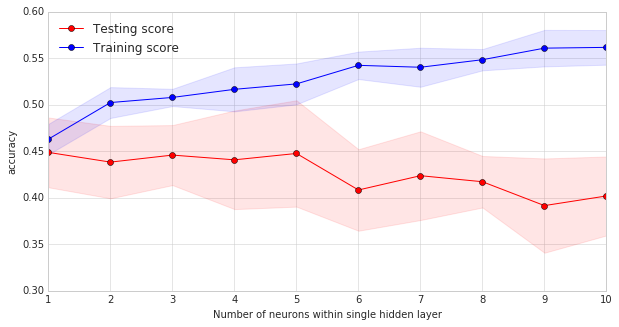

In [427]:
#results from cross-validation
test_arr=[0.44882693339546265, 0.438377161898416, 0.4459271726720152, 0.4408289694359671, 0.44768151401553535, 
          0.40840335852104853, 0.42377487780107836, 0.41728232912295693, 0.3916148837498723, 0.4019845634958264]
train_arr=[0.463125308475985, 0.5024267539181612, 0.5079213065131636, 0.5166359110123365, 0.5224774350410458, 
           0.5424386778455877, 0.5403725015431828, 0.5484879602789138, 0.5609215192731012, 0.5617500454474444]
std_test_arr=[0.01876463336286928, 0.019462329488871142, 0.016133780186576383, 0.02649847687061913, 0.028589368945447537, 
              0.02191004659421664, 0.023848278560123497, 0.013849398482102157, 0.02534227852721577, 0.021216483397149044]
std_train_arr=[0.008195786380415487, 0.008292939978172752, 0.004632284770613355, 0.011837374742651655, 0.010985268565931771, 
               0.007377891251855958, 0.010492428285785992, 0.005722482522491793, 0.00981486042767452, 0.00930789745883734]

#plot results from cross-validated results for easier visualization
plot_cv_tunning(test_arr,train_arr,std_test_arr,std_train_arr,'Number of neurons within single hidden layer',np.arange(10)+1,0)

Increasing the number of neurons using a single hidden layer appears to enhance training accuracy, but tends to increase the gap between training and testing accuracies after a certain number of neurons. We also observe a large variance across the folds when looking at the testing accuracy R2 results. This implies that the cost for greater accuracy using a simple NN means increased overfitting. This means that increased variance in the model  as the number of neurons increases. We can attempt to mitigate this somehow using the regularizing parameter alpha

In [428]:
alpha=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000];
#cv=10;
#total_test_acc=[]; total_test_std=[]
#total_train_acc=[];  total_train_std=[]
#for a in alpha:
#    train_acc=[]; test_acc=[]; test=0; train=0;
#    for i in range(cv):
#        reg=MLPRegressor(hidden_layer_sizes=5,solver='lbfgs',learning_rate='constant',alpha=a)
#        reg, test, train= simple_score(reg,X_uv,Y_uv)
#        test_acc.append(test)
#        train_acc.append(train)
#    total_train_acc.append(np.mean(train_acc))
#    total_test_acc.append(np.mean(test_acc))
#    total_train_std.append(np.std(train_acc))
#    total_test_std.append(np.std(test_acc))
#plt.plot(alpha,total_train_acc,"o-",color='r',label="train accuracy")
#plt.plot(alpha,total_test_acc,"o-",color='b',label="test accuracy")  
#plt.legend(loc="best")
#plt.ylabel('Accuracy')
#plt.xlabel('alpha') 
#plt.xscale('log'); plt.show()

#print(total_train_acc)
#print(total_test_acc)
#print(total_train_std)
#print(total_test_std)

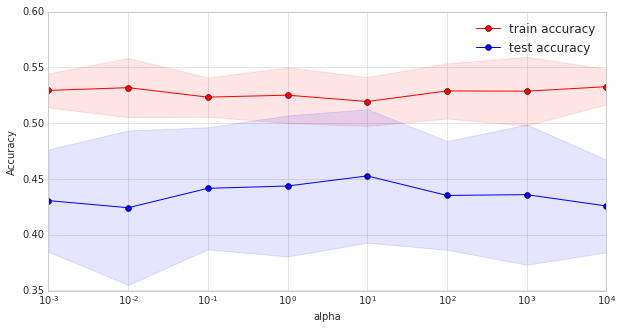

In [429]:
total_train_acc=[0.5292827706193269, 0.5317540943830372, 0.5232802189173289, 0.5250352183006748, 0.5193376565598873, 
 0.5288348524525113, 0.5285917052951431, 0.5326551153500856]
total_test_acc=[0.43056684245881965, 0.42417457183116253, 0.44155820068619767, 0.4436426964869214, 0.4526674088031939, 
 0.43518021021674924, 0.43589709415259403, 0.4257204438493981]
total_train_std=[0.007630674990186766, 0.013267260151995195, 0.00879432892192985, 0.012462225687189658, 0.010976822894491332, 
 0.012380154316244665, 0.015440562991954562, 0.007880796360926316]
total_test_std=[0.022954632829368233, 0.03461595445950274, 0.027359077346587882, 0.03160449087812681, 0.029912753506355905, 
 0.02435365732010163, 0.03142708811974714, 0.020762387337552545]
plt.plot(alpha,total_train_acc,"o-",color='r',label="train accuracy")
plt.plot(alpha,total_test_acc,"o-",color='b',label="test accuracy")  
plt.fill_between(alpha, np.array(total_train_acc) - 2*np.array(total_train_std), 
    np.array(total_train_acc) + 2*np.array(total_train_std), alpha=0.1, color="r")
plt.fill_between(alpha, np.array(total_test_acc) - 2*np.array(total_test_std), 
    np.array(total_test_acc) + 2*np.array(total_test_std), alpha=0.1, color="b")
plt.legend(loc="best")
plt.ylabel('Accuracy')
plt.xlabel('alpha') 
plt.xscale('log'); plt.show()

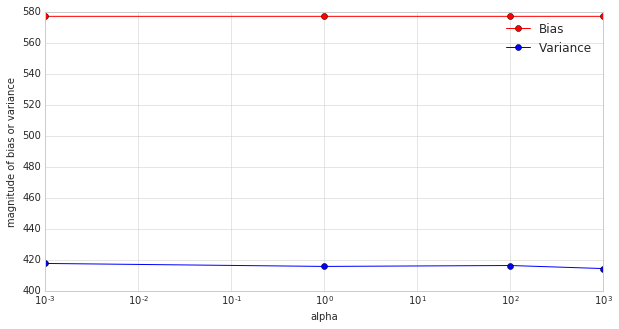

In [430]:
#plot bias-variance for decision trees:
alpha=[0.001, 1, 100, 1000];
bias_v=[]; var_v=[]; bias=[]; var=[]; error=[]
for a in alpha:
    reg=MLPRegressor(hidden_layer_sizes=6,solver='lbfgs',learning_rate='constant',alpha=a)
    bias_v, var_v=bias_var(reg,X_uv,Y_uv)
    y_pred=reg.predict(X_uv)
    bias.append(bias_v); var.append(var_v)
    
fig, ax1 = plt.subplots()    
ax1.plot(alpha,bias,"o-",color='r',label="Bias")
ax1.plot(alpha,var,"o-",color='b',label="Variance")  
plt.legend(loc="best")
plt.ylabel('magnitude of bias or variance')
plt.xlabel('alpha')
plt.xscale('log')

In [431]:
hlayer_sizes=[(10),(10,10),(10,10,10),(20,20,20),(30,30,30)]
solver= ['lbfgs', 'adam',]
learning_rate=['constant', 'invscaling', 'adaptive']



In [432]:
cv=10
#for rate in learning_rate:
#    for sol in solver:
#        for layer in hlayer_sizes:
#            total_test_acc=0
#            total_train_acc=0
#            for i in range(cv):
#                reg=MLPRegressor(hidden_layer_sizes=layer,solver=sol,learning_rate=rate,alpha=1)
#                reg, test_acc, train_acc= simple_score(reg,X_uv,Y_uv)
#                total_test_acc=total_test_acc+test_acc
#                total_train_acc=total_train_acc+train_acc
#            print('l_rate='+rate+', solver='+sol+', hidden_layers='+str(layer)+': Test acc='+str(round(total_test_acc/cv,4))+' Train acc='+str(round(total_train_acc/cv,4)))
    


Results using cross validated optimization of NN:
* l_rate=constant, solver=lbfgs, hidden_layers=10: Test acc=0.4128 Train acc=0.5555
* l_rate=constant, solver=lbfgs, hidden_layers=(10, 10): Test acc=0.4086 Train acc=0.5589
* l_rate=constant, solver=lbfgs, hidden_layers=(10, 10, 10): Test acc=0.35 Train acc=0.5693
* l_rate=constant, solver=lbfgs, hidden_layers=(20, 20, 20): Test acc=0.2792 Train acc=0.6232
* l_rate=constant, solver=lbfgs, hidden_layers=(30, 30, 30): Test acc=-0.0043 Train acc=0.6997
* l_rate=constant, solver=adam, hidden_layers=10: Test acc=-0.4164 Train acc=-0.4032
* l_rate=constant, solver=adam, hidden_layers=(10, 10): Test acc=0.4059 Train acc=0.4211
* l_rate=constant, solver=adam, hidden_layers=(10, 10, 10): Test acc=0.4414 Train acc=0.4742
* l_rate=constant, solver=adam, hidden_layers=(20, 20, 20): Test acc=0.4434 Train acc=0.491
* l_rate=constant, solver=adam, hidden_layers=(30, 30, 30): Test acc=0.4546 Train acc=0.4926
* l_rate=invscaling, solver=lbfgs, hidden_layers=10: Test acc=0.4129 Train acc=0.5554
* l_rate=invscaling, solver=lbfgs, hidden_layers=(10, 10): Test acc=0.4106 Train acc=0.5644
* l_rate=invscaling, solver=lbfgs, hidden_layers=(10, 10, 10): Test acc=0.3903 Train acc=0.57
* l_rate=invscaling, solver=lbfgs, hidden_layers=(20, 20, 20): Test acc=0.2065 Train acc=0.6408
* l_rate=invscaling, solver=lbfgs, hidden_layers=(30, 30, 30): Test acc=0.0762 Train acc=0.6883
* l_rate=invscaling, solver=adam, hidden_layers=10: Test acc=-0.412 Train acc=-0.4197
* l_rate=invscaling, solver=adam, hidden_layers=(10, 10): Test acc=0.4254 Train acc=0.4121
* l_rate=invscaling, solver=adam, hidden_layers=(10, 10, 10): Test acc=0.4511 Train acc=0.4684
* l_rate=invscaling, solver=adam, hidden_layers=(20, 20, 20): Test acc=0.461 Train acc=0.4821
* l_rate=invscaling, solver=adam, hidden_layers=(30, 30, 30): Test acc=0.4678 Train acc=0.4873
* l_rate=adaptive, solver=lbfgs, hidden_layers=10: Test acc=0.407 Train acc=0.5607
* l_rate=adaptive, solver=lbfgs, hidden_layers=(10, 10): Test acc=0.3838 Train acc=0.5774
* l_rate=adaptive, solver=lbfgs, hidden_layers=(10, 10, 10): Test acc=0.404 Train acc=0.5643
* l_rate=adaptive, solver=lbfgs, hidden_layers=(20, 20, 20): Test acc=0.2424 Train acc=0.6337
* l_rate=adaptive, solver=lbfgs, hidden_layers=(30, 30, 30): Test acc=0.1834 Train acc=0.6684
* l_rate=adaptive, solver=adam, hidden_layers=10: Test acc=-0.4416 Train acc=-0.4526
* l_rate=adaptive, solver=adam, hidden_layers=(10, 10): Test acc=0.3872 Train acc=0.4228
* l_rate=adaptive, solver=adam, hidden_layers=(10, 10, 10): Test acc=0.4579 Train acc=0.463
* l_rate=adaptive, solver=adam, hidden_layers=(20, 20, 20): Test acc=0.4576 Train acc=0.4821
* l_rate=adaptive, solver=adam, hidden_layers=(30, 30, 30): Test acc=0.4602 Train acc=0.4928

Let's do further work on optimizing the scores by looking at different number of neurons:

In [433]:
cv=10
hl1=[25, 30, 35, 40];
hl2=[25,30,35,40];
hl3=[25,30,35,40];
### code with cross-validation - results shown in the next cell:
#for h1 in hl1:
#    for h2 in hl2:
#        for h3 in hl3:
#            total_test_acc=0
#            total_train_acc=0
#            for i in range(cv):
#                reg=MLPRegressor(hidden_layer_sizes=(h1,h2,h3),solver='adam' ,learning_rate='invscaling',alpha=1)
#                reg, test_acc, train_acc= simple_score(reg,X_uv,Y_uv)
#                total_test_acc=total_test_acc+test_acc
#                total_train_acc=total_train_acc+train_acc
#            print('h1='+str(h1)+', h2='+str(h2)+', h3='+str(h3)+', test_score='+str(round(total_test_acc/cv,4))+', train_score='+str(round(total_train_acc/cv,4)))
    

* results obtained by running the code above:

* h1=25, h2=25, h3=25, test_score=0.4548, train_score=0.4914
* h1=25, h2=25, h3=30, test_score=0.4597, train_score=0.4889
* h1=25, h2=25, h3=35, test_score=0.4519, train_score=0.4921
* h1=25, h2=25, h3=40, test_score=0.4562, train_score=0.4897
* h1=25, h2=30, h3=25, test_score=0.4713, train_score=0.483
* h1=25, h2=30, h3=30, test_score=0.4684, train_score=0.4853
* h1=25, h2=30, h3=35, test_score=0.4646, train_score=0.4878
* h1=25, h2=30, h3=40, test_score=0.4635, train_score=0.4874
* h1=25, h2=35, h3=25, test_score=0.4653, train_score=0.4874
* h1=25, h2=35, h3=30, test_score=0.4604, train_score=0.4884
* h1=25, h2=35, h3=35, test_score=0.4496, train_score=0.4936
* h1=25, h2=35, h3=40, test_score=0.4687, train_score=0.4862
* h1=25, h2=40, h3=25, test_score=0.4418, train_score=0.4971
* h1=25, h2=40, h3=30, test_score=0.4645, train_score=0.4887
* h1=25, h2=40, h3=35, test_score=0.4549, train_score=0.4914
* h1=25, h2=40, h3=40, test_score=0.4475, train_score=0.4942
* h1=30, h2=25, h3=25, test_score=0.4692, train_score=0.4848
* h1=30, h2=25, h3=30, test_score=0.4461, train_score=0.4963
* h1=30, h2=25, h3=35, test_score=0.4685, train_score=0.4882
* h1=30, h2=25, h3=40, test_score=0.4536, train_score=0.4922
* h1=30, h2=30, h3=25, test_score=0.4615, train_score=0.4871
* h1=30, h2=30, h3=30, test_score=0.4621, train_score=0.4894
* h1=30, h2=30, h3=35, test_score=0.4505, train_score=0.4943
* h1=30, h2=30, h3=40, test_score=0.4576, train_score=0.493
* h1=30, h2=35, h3=25, test_score=0.468, train_score=0.4852
* h1=30, h2=35, h3=30, test_score=0.4587, train_score=0.4887
* h1=30, h2=35, h3=35, test_score=0.4558, train_score=0.4916
* h1=30, h2=35, h3=40, test_score=0.46, train_score=0.4908
* h1=30, h2=40, h3=25, test_score=0.4586, train_score=0.4891
* h1=30, h2=40, h3=30, test_score=0.456, train_score=0.491
* h1=30, h2=40, h3=35, test_score=0.4532, train_score=0.4946
* h1=30, h2=40, h3=40, test_score=0.4631, train_score=0.4932
* h1=35, h2=25, h3=25, test_score=0.4554, train_score=0.493
* h1=35, h2=25, h3=30, test_score=0.471, train_score=0.4849
* h1=35, h2=25, h3=35, test_score=0.465, train_score=0.4923
* h1=35, h2=25, h3=40, test_score=0.4527, train_score=0.4926
* h1=35, h2=30, h3=25, test_score=0.461, train_score=0.4899
* h1=35, h2=30, h3=30, test_score=0.4601, train_score=0.4938
* h1=35, h2=30, h3=35, test_score=0.4523, train_score=0.4927
* h1=35, h2=30, h3=40, test_score=0.465, train_score=0.4911
* h1=35, h2=35, h3=25, test_score=0.4565, train_score=0.493
* h1=35, h2=35, h3=30, test_score=0.4735, train_score=0.4822
* h1=35, h2=35, h3=35, test_score=0.4478, train_score=0.495
* h1=35, h2=35, h3=40, test_score=0.4573, train_score=0.4947
* h1=35, h2=40, h3=25, test_score=0.4673, train_score=0.4894
* h1=35, h2=40, h3=30, test_score=0.4593, train_score=0.4955
* h1=35, h2=40, h3=35, test_score=0.4731, train_score=0.487
* h1=35, h2=40, h3=40, test_score=0.4635, train_score=0.4922
* h1=40, h2=25, h3=25, test_score=0.4619, train_score=0.4889
* h1=40, h2=25, h3=30, test_score=0.4654, train_score=0.4894
* h1=40, h2=25, h3=35, test_score=0.4563, train_score=0.4956
* h1=40, h2=25, h3=40, test_score=0.465, train_score=0.491
* h1=40, h2=30, h3=25, test_score=0.4547, train_score=0.4922
* h1=40, h2=30, h3=30, test_score=0.4614, train_score=0.4894
* h1=40, h2=30, h3=35, test_score=0.4598, train_score=0.4921
* h1=40, h2=30, h3=40, test_score=0.4627, train_score=0.4954
* h1=40, h2=35, h3=25, test_score=0.4527, train_score=0.4918
* h1=40, h2=35, h3=30, test_score=0.4699, train_score=0.49
* h1=40, h2=35, h3=35, test_score=0.4619, train_score=0.4928
* h1=40, h2=35, h3=40, test_score=0.4648, train_score=0.4917
* h1=40, h2=40, h3=25, test_score=0.4671, train_score=0.4886
* h1=40, h2=40, h3=30, test_score=0.4496, train_score=0.4958
* h1=40, h2=40, h3=35, test_score=0.4615, train_score=0.4916
* h1=40, h2=40, h3=40, test_score=0.4683, train_score=0.4918

As we can clearly observe from the results above, the accuracy for the training and testing sets do not appear to vary monotonically with respect to the number of neurons within a specific hidden layer. This may be due to the fact that many factors may affect the performance of neural networks, and it not always find the absolute global maximum, especially as it becomes less and less convex with the addition of more neurons and layers. We can see that the combination (35,35,30) yields the best testing accuracy by a very small extent.

### 7. Discussions

When training a model and choosing the appropriate parameters, it is quite relevant to consider the effects of bias and variance within the model. We can observe that having either a high variance or a high bias may both be undesirable. 

The accuracies (scores) obtained through the different models are quite small for nearly all subsets investigated. This may be an indication tha further hyperparameter tuning and feature engineering are needed to improve predictions. Another plausible reason that the trained models have not performed as well as it would be desired could be due to the fact that important features may be missing. By inspecting the dataset, one set of features that have not been well collected are soft skills. These refer to communication skills, leadership, teamwork, among many others. Since the survey only focuses on the technical side of the work performed by data analytics professional, it may be missing an important set of features that could help determine their success in industry. 

In terms of algorithm performance, we observe that ensemble based methods, such as random forest, appear to improve regression as compared to its non-ensemble counterpart (i.e. decision tree). This demonstrates the superiority of ensemble methods overall at achieving high training accuracy (R^2), combined with less overfitting. 

### Additional Testing and discussions

The following code combines all optimized results together for the six algorithms implemented in this report:

In [434]:
#arr=[]
#reg=LinearRegression()
#reg, LINREG_test_acc, LINREG_train_acc,l_std_test,l_std_train=ml_score_std(reg,X_uv,Y_uv)
#reg = linear_model.Lasso(alpha=1)
#reg, LASREG_test_acc, LASREG_train_acc, l1_std_test,l1_std_train=ml_score_std(reg,X_uv,Y_uv)
#reg=tree.DecisionTreeRegressor(min_samples_leaf=40)
#reg, TREEREG_test_acc, TREEREG_train_acc, t_std_test,t_std_train=ml_score_std(reg,X_uv,Y_uv)
#reg = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10, min_samples_leaf=6)
#reg, RFREG_test_acc, RFREG_train_acc, r_std_test,r_std_train=ml_score_std(reg,X_uv,Y_uv)
#reg = KNeighborsRegressor(n_neighbors=1000)
#reg, knn_test, knn_train,k_std_test,k_std_train=ml_score_std(reg,X_uv,Y_uv)
#reg = MLPRegressor(hidden_layer_sizes=(35, 35, 30),solver='adam' ,learning_rate='invscaling',alpha=1)
#reg, NN_test, NN_train,n_std_test,n_std_train=ml_score_std(reg,X_uv,Y_uv)
#arr=[LINREG_test_acc,LINREG_train_acc,LASREG_test_acc,LASREG_train_acc,TREEREG_test_acc,TREEREG_train_acc,
#RFREG_test_acc,RFREG_train_acc, knn_test, knn_train, NN_test, NN_train]
#arr_std=[l_std_test,l1_std_test,t_std_test,r_std_test,k_std_test,n_std_test,l_std_train,
#         l1_std_train,t_std_train,r_std_train,k_std_train,n_std_train]
#print(arr)
#print(arr_std)

In [435]:
### results obtained from commented code above with scores and standard deviations
arr=[0.46145452551882205, 0.4751083449432435, 0.4634400458699431, 0.4747859955362325, 
     0.41269908210025114, 0.49709214838807814, 0.45303845811477467, 0.5184590324879738, 
     0.2861219112263692, 0.2878791810275887, 0.45148876677030236, 0.4948208556154817]
arr_std=[0.020250693408954315, 0.019710419638078104, 0.023222409102229502, 0.031092295579937736, 
         0.015129670820428777, 0.025041951821832057, 0.008331896169188953, 0.008234828056024282, 
         0.009590671402341872, 0.012476890206945533, 0.00761884693044541, 0.010734482924186236]

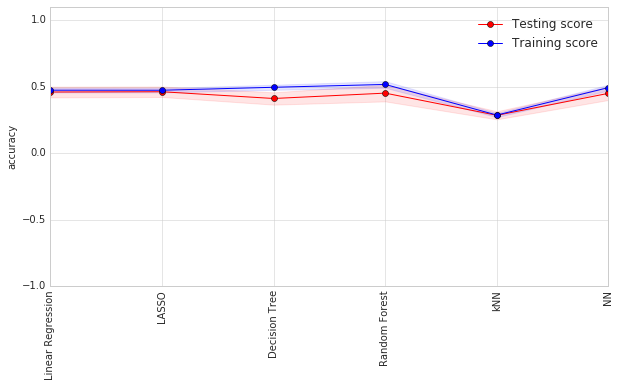

In [436]:
plt.plot([arr[0],arr[2],arr[4],arr[6],arr[8],arr[10]],"o-",color='r', label="Testing score")
plt.plot([arr[1],arr[3],arr[5],arr[7],arr[9],arr[11]],"o-",color='b', label="Training score")
plt.fill_between(np.arange(6), np.array([arr[0],arr[2],arr[4],arr[6],arr[8],arr[10]]) - 2*np.array([arr_std[0],arr_std[1],arr_std[2],arr_std[3],arr_std[4],arr_std[5]]), 
                                             np.array([arr[0],arr[2],arr[4],arr[6],arr[8],arr[10]]) + 2*np.array([arr_std[0],arr_std[1],arr_std[2],arr_std[3],arr_std[4],arr_std[5]]), alpha=0.1, color="r")
plt.fill_between(np.arange(6), np.array([arr[1],arr[3],arr[5],arr[7],arr[9],arr[11]]) - 2*np.array([arr_std[6],arr_std[7],arr_std[8],arr_std[9],arr_std[10],arr_std[11]]),\
                     np.array([arr[1],arr[3],arr[5],arr[7],arr[9],arr[11]]) + 2*np.array([arr_std[6],arr_std[7],arr_std[8],arr_std[9],arr_std[10],arr_std[11]]), alpha=0.1, \
                     color="b")
plt.xticks([0,1,2,3,4,5],['Linear Regression', 'LASSO', 'Decision Tree', 'Random Forest','kNN','NN'], rotation=90)
plt.ylim([-1, 1.1])
plt.ylabel('accuracy')
plt.legend(loc="best")

In [437]:
print('Best accuracies for training and testing:')
print('Training accuracy for Random Forest='+str(arr[7])+', with std='+str(arr_std[9]))
print('Testing accuracy for LASSO='+str(arr[2])+', with std='+str(arr_std[1]))

Best accuracies for training and testing:
Training accuracy for Random Forest=0.5184590324879738, with std=0.012476890206945533
Testing accuracy for LASSO=0.4634400458699431, with std=0.019710419638078104


As we can obsserve in the above plot, several models have been used to try to optimize the accuracy metrics (R^2) for both training and testing sets. It can be seen that most models reach a average coefficient of determination of about 50%. This is not true for k-NN, however. The optimized models have little overfitting in general.


### Appendix: Training ML algorithms using categorical subsets of dataset

Let's look at the subset where only those who took a londer time to answer the survey are considered. We would expect that using a selected subset, the data would be more homogeneous and it would be possible to obtain better predictions overall

7219


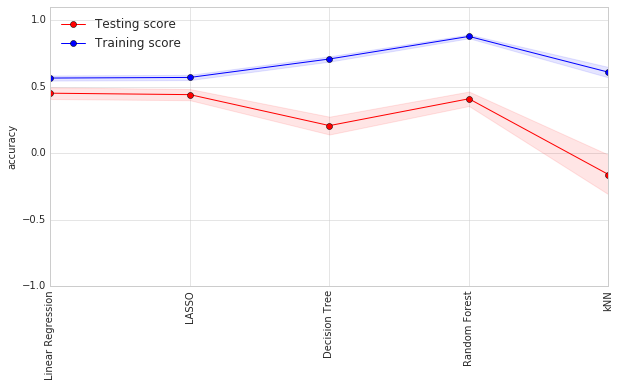

In [290]:
longtime_features=data_temp[data_temp.iloc[:,0]>=1000]
Y=longtime_features['Q9'].values
longtime_features=longtime_features.drop(columns=['Q9'])
X=longtime_features.values
X=StandardScaler().fit_transform(X)
arr=ML_train_test_cv (X,Y)
print(longtime_features.shape[0])

All training scores are higher than 50%, whereas testing scores are under 50%. Let's look at data from male participants, as they represent a majority in this dataset

9026


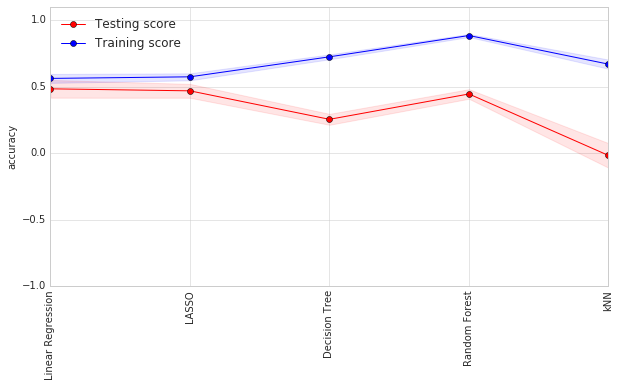

In [291]:
#look at men's data
#longtime_data=data[data.iloc[:,1]>=1000]
male_features=data_temp[data_temp['gender_Male']==1].copy()
Y=male_features['Q9'].values
male_features=male_features.drop(columns=['Q9'])
X=male_features.values
X=StandardScaler().fit_transform(X)
arr=ML_train_test_cv (X,Y)
print(male_features.shape[0])


Let's look at an arbitrary salary range:

4530


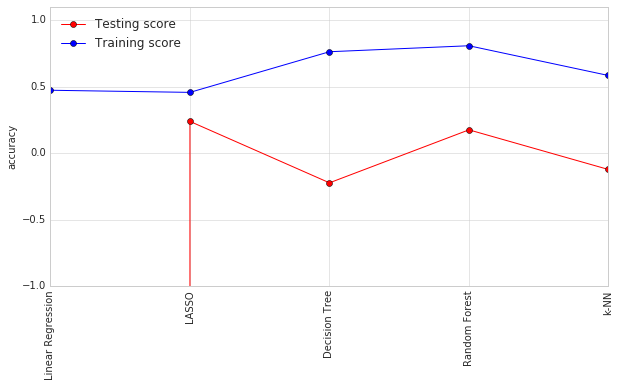

In [292]:
salary_data=data_temp[(data_temp['Q9']>=10000) & (data_temp['Q9']<=60000)].copy()
Y=salary_data['Q9'].values
salary_data=salary_data.drop(columns=['Q9'])
X=salary_data.values
X=StandardScaler().fit_transform(X)
arr=ML_train_test (X,Y)
print(salary_data.shape[0])


We can observe in the above plot that the inacurate predictions are not a result of high salaries which may behave as outliers, but rather an generalized difficulty in the prediction of the dataset as a whole.  

4530


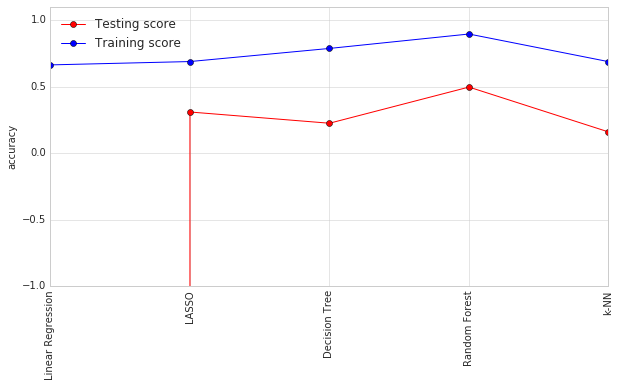

In [293]:
US_data=data_temp[(data_temp['country_United States of America']==1)].copy()
Y=US_data['Q9'].values
US_data=US_data.drop(columns=['Q9'])
X=US_data.values
X=StandardScaler().fit_transform(X)
arr=ML_train_test (X,Y)
print(salary_data.shape[0])